# Anime Recommendations
This project is based on [this dataset](https://www.kaggle.com/CooperUnion/anime-recommendations-database) and it's goal is to make anime recommendations better.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Nadam, SGD, Adagrad
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Dot, Embedding, Concatenate, Dense, Dropout, Activation, Flatten, BatchNormalization, Lambda
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, LabelEncoder, FunctionTransformer, MinMaxScaler

ANIME_PATH = os.path.join("..", "data")

def load_anime_data(filename, anime_path=ANIME_PATH):
    csv_path = os.path.join(anime_path, filename)
    return pd.read_csv(csv_path)

/Users/zengraf/.asdf/installs/python/3.9.1/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
anime = load_anime_data("anime.csv")
rating = load_anime_data("rating.csv")

## Data description
### Anime.csv
- anime_id - myanimelist.net's unique id identifying an anime.
- name - full name of anime.
- genre - comma separated list of genres for this anime.
- type - movie, TV, OVA, etc.
- episodes - how many episodes in this show. (1 if movie).
- rating - average rating out of 10 for this anime.
- members - number of community members that are in this anime's
- "group".

### Rating.csv
- user_id - non identifiable randomly generated user id.
- anime_id - the anime that this user has rated.
- rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

In [3]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [5]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [6]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [7]:
anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [8]:
rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


When `rating` is equal to -1, that means that the user watched the series, but didn't rate it.

In [9]:
(rating["rating"] == -1).sum()

1476496

In [10]:
rating.groupby("user_id")[["anime_id"]].count().describe()

,anime_id
count,73515.000000
mean,106.287656
std,153.086558
min,1.000000
25%,18.000000
50%,57.000000
75%,136.000000
max,10227.000000


Missing data inside `episodes` column is indicated as `Unknown`, not `NaN`

Probably, this is true for ongoing anime

In [11]:
anime.loc[anime["episodes"] == "Unknown", "episodes"].count()

340

If `rating` is set to `NaN`, the anime hasn't probably been aired yet

In [12]:
anime.loc[anime["rating"].isnull()].count()

anime_id    230
name        230
genre       215
type        205
episodes    230
rating        0
members     230
dtype: int64

In [13]:
anime["type"].value_counts()

TV         3787
OVA        3311
Movie      2348
Special    1676
ONA         659
Music       488
Name: type, dtype: int64

In [14]:
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        output = X.copy()
        for name, column in output.iteritems():
            output[name] = LabelEncoder().fit_transform(column)
        return output

In [15]:
rating_preprocessing = ColumnTransformer([
    ("encoder", MultiColumnLabelEncoder(), ["user_id", "anime_id"])
])

In [16]:
filtered = rating[(rating["rating"] != -1) & (rating["user_id"] < 5000)]
X = rating_preprocessing.fit_transform(filtered)
y = filtered["rating"].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [17]:
def CollaborativeModel(n_factors, n_users, n_anime):
    user_in = Input(shape=[1], name="user_input")
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user_in)
    u = Flatten()(u)

    anime_in = Input(shape=[1], name="anime_input")
    a = Embedding(n_anime, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(anime_in)
    a = Flatten()(a)

    x = Dot(axes=1)([u, a])
    result = Model(inputs=[user_in, anime_in], outputs=x)
    result.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
    return result

In [18]:
model = CollaborativeModel(50, filtered["user_id"].nunique(), filtered["anime_id"].nunique())
model.summary()
history = model.fit({
        "user_input": X_train[:, 0],
        "anime_input": X_train[:, 1]
    },
    y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=({
        "user_input": X_test[:, 0],
        "anime_input": X_test[:, 1]
    }, y_test)
)

/Users/zengraf/.asdf/installs/python/3.9.1/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
anime_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        235000      user_input[0][0]                 
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        330550      anime_input[0][0]                
______________________________________________________________________________________________

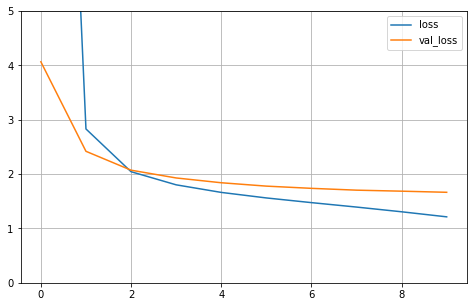

In [19]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5)
plt.show()

In [20]:
def CollaborativeModelV2(n_factors, n_users, n_anime):
    user_in = Input(shape=(1,), name="user_input")
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user_in)
    u = Flatten()(u)

    anime_in = Input(shape=(1,), name="anime_input")
    a = Embedding(n_anime, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(anime_in)
    a = Flatten()(a)

    x = Concatenate()([u, a])
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1)(x)
    x = Activation('relu')(x)
    result = Model(inputs=[user_in, anime_in], outputs=x)
    result.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
    return result

In [21]:
model_2 = CollaborativeModelV2(50, filtered["user_id"].nunique(), filtered["anime_id"].nunique())
model_2.summary()
history_2 = model_2.fit({
        "user_input": X_train[:, 0],
        "anime_input": X_train[:, 1]
    },
    y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=({
        "user_input": X_test[:, 0],
        "anime_input": X_test[:, 1]
    }, y_test)
)

/Users/zengraf/.asdf/installs/python/3.9.1/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
anime_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        235000      user_input[0][0]                 
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        330550      anime_input[0][0]                
____________________________________________________________________________________________

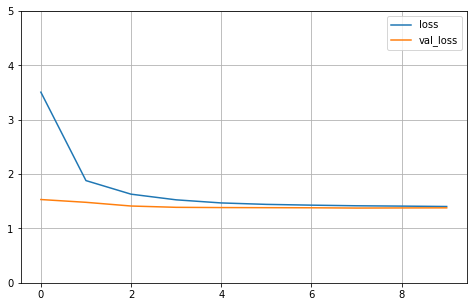

In [22]:
pd.DataFrame(history_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5)
plt.show()

In [23]:
class MultiLabelTransformer(BaseEstimator, TransformerMixin):
    """
    Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`
    """
    def __init__(self, column):
        self.column = column
        self.mlb = MultiLabelBinarizer(sparse_output=False)
    def fit(self, X, y=None):
        self.mlb.fit(X[self.column])
        return self
    def transform(self, X):
        return self.mlb.transform(X.loc[X[self.column].notnull(),  self.column])

class StringSplitter(BaseEstimator, TransformerMixin):
    def __init__(self, sep=","):
        self.sep = sep
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return pd.DataFrame(data=X).apply(lambda c: c.map(lambda s: s.split(self.sep)))

In [24]:
anime_preprocessing = ColumnTransformer([
    ("genre", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
        ("splitter", StringSplitter()),
        ("binarizer", MultiLabelTransformer(0))
    ]), ["genre"]),
    ("type", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]), ["type"]),
    ("episodes", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("unknown_imputer", SimpleImputer(missing_values="Unknown", strategy="most_frequent")),
        ("transformer", FunctionTransformer(lambda e: e.astype(int))),
    ]), ["episodes"]),
    ("popularity", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler())
    ]), ["members"]),
    ("rating", SimpleImputer(strategy="median"), ["rating_avg"])
])

In [25]:
preprocessing = FeatureUnion([
    ("rating", rating_preprocessing),
    ("anime", anime_preprocessing)
])

In [26]:
joined = filtered.join(anime.set_index("anime_id"), on="anime_id", rsuffix="_avg")

In [27]:
X = preprocessing.fit_transform(joined)
y = joined["rating"].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [28]:
def ContentCollaborativeModel(n_factors_u, n_factors_a, n_users, n_anime, n_content_params):
    user_in = Input(shape=[1], name="user_input")
    u = Embedding(n_users, n_factors_u, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user_in)
    u = Flatten()(u)

    anime_in = Input(shape=[1], name="anime_input")
    a = Embedding(n_anime, n_factors_a, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(anime_in)
    a = Flatten()(a)

    content_in = Input(shape=[n_content_params], name="content_input")
    c = Flatten()(content_in)

    x = Concatenate()([u, a, c])
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1)(x)
    x = Activation('relu')(x)
    result = Model(inputs=[user_in, anime_in, content_in], outputs=x)
    result.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
    return result

In [29]:
model_3 = ContentCollaborativeModel(50, 50, joined["user_id"].nunique(), joined["anime_id"].nunique(), X.shape[1] - 2)
model_3.summary()
history_3 = model_3.fit({
        "user_input": X_train[:, 0],
        "anime_input": X_train[:, 1],
        "content_input": X_train[:, 2:]
    },
    y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=({
        "user_input": X_test[:, 0],
        "anime_input": X_test[:, 1],
        "content_input": X_test[:, 2:]
    }, y_test)
)

/Users/zengraf/.asdf/installs/python/3.9.1/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
anime_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        235000      user_input[0][0]                 
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 50)        330550      anime_input[0][0]                
____________________________________________________________________________________________

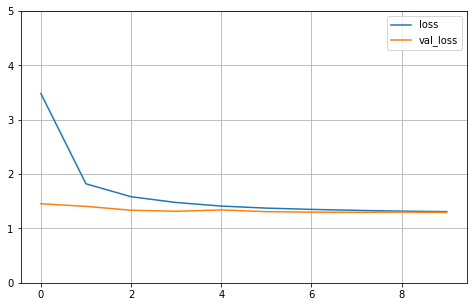

In [30]:
pd.DataFrame(history_3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5)
plt.show()

In [31]:
def build_model(n_factors_u = 50, n_factors_a = 50, n_neurons = 128, dropout = 0.5, optimizer=Adam(learning_rate=0.001), n_users = joined["user_id"].nunique(), n_anime = joined["anime_id"].nunique()):
    combi_input = Input([X.shape[1]])
    user_in = Lambda(lambda x: tf.expand_dims(x[:,0],-1))(combi_input)
    anime_in = Lambda(lambda x: tf.expand_dims(x[:,1],-1))(combi_input)
    content_in = Lambda(lambda x: tf.expand_dims(x[:,2:],-1))(combi_input)
    u = Embedding(n_users, n_factors_u, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user_in)
    u = Flatten()(u)

    a = Embedding(n_anime, n_factors_a, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(anime_in)
    a = Flatten()(a)

    c = Flatten()(content_in)

    x = Concatenate()([u, a, c])
    x = Dense(n_neurons)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    x = Activation('relu')(x)
    result = Model(combi_input, outputs=x)
    result.compile(loss='mean_squared_error', optimizer=optimizer)
    return result

In [32]:
filtered_small = rating[(rating["rating"] != -1) & (rating["user_id"] < 500)]
joined_small = filtered_small.join(anime.set_index("anime_id"), on="anime_id", rsuffix="_avg")

In [42]:
X = preprocessing.fit_transform(joined_small)
y = joined_small["rating"].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [44]:
keras_clf = KerasRegressor(build_model)

params = {
    "n_factors_u": [5, 20, 50, 100],
    "n_factors_a": [5, 20, 50, 100],
    "n_neurons": [95, 190, 380],
    "dropout": [0.2, 0.5, 0.7],
    "optimizer": [Adam(), Nadam(), SGD(), Adagrad(learning_rate=0.01)],
    "n_users": [joined_small["user_id"].nunique() + 1],
    "n_anime": [joined_small["anime_id"].nunique() + 1],
}

rnd_search_cv = RandomizedSearchCV(keras_clf, params, n_iter=250, cv=5, verbose=1, scoring='neg_mean_squared_error')
rnd_search_cv.fit(
    X_train,
    y_train,
    epochs=100,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1),
        ModelCheckpoint("best_model.h5py",save_best_only=True)
    ]
)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 4.1642 - val_loss: 2.6378
INFO:tensorflow:Assets written to: best_model.h5py/assets
Epoch 2/100
741/741 [==============================] - 1s 898us/step - loss: 2.6259 - val_loss: 2.4342
INFO:tensorflow:Assets written to: best_model.h5py/assets
Epoch 3/100
741/741 [==============================] - 1s 892us/step - loss: 2.4817 - val_loss: 2.2794
INFO:tensorflow:Assets written to: best_model.h5py/assets
Epoch 4/100
741/741 [==============================] - 1s 898us/step - loss: 2.3864 - val_loss: 2.2659
INFO:tensorflow:Assets written to: best_model.h5py/assets
Epoch 5/100
741/741 [==============================] - 1s 913us/step - loss: 2.3174 - val_loss: 2.2217
INFO:tensorflow:Assets written to: best_model.h5py/assets
Epoch 6/100
741/741 [==============================] - 1s 888us/step - loss: 2.2515 - val_loss: 2.7789
Epoch 7/100
741/741 [=========

741/741 [==============================] - 1s 894us/step - loss: 2.2042 - val_loss: 2.1420
Epoch 9/100
741/741 [==============================] - 1s 900us/step - loss: 2.1892 - val_loss: 2.1537
Epoch 10/100
741/741 [==============================] - 1s 894us/step - loss: 2.1465 - val_loss: 2.1728
Epoch 11/100
741/741 [==============================] - 1s 927us/step - loss: 2.0725 - val_loss: 2.0934
Epoch 12/100
741/741 [==============================] - 1s 916us/step - loss: 2.0636 - val_loss: 2.0215
Epoch 13/100
741/741 [==============================] - 1s 882us/step - loss: 2.0249 - val_loss: 1.9968
Epoch 14/100
741/741 [==============================] - 1s 905us/step - loss: 2.0313 - val_loss: 2.0448
Epoch 15/100
741/741 [==============================] - 1s 884us/step - loss: 1.9794 - val_loss: 2.0412
Epoch 16/100
741/741 [==============================] - 1s 890us/step - loss: 1.9349 - val_loss: 1.8718
Epoch 17/100
741/741 [==============================] - 1s 886us/step - loss: 

741/741 [==============================] - 1s 882us/step - loss: 1.8137 - val_loss: 1.7882
Epoch 22/100
741/741 [==============================] - 1s 880us/step - loss: 1.8128 - val_loss: 1.7181
Epoch 23/100
741/741 [==============================] - 1s 888us/step - loss: 1.8018 - val_loss: 1.6848
Epoch 24/100
741/741 [==============================] - 1s 908us/step - loss: 1.7904 - val_loss: 1.5822
Epoch 25/100
741/741 [==============================] - 1s 884us/step - loss: 1.8239 - val_loss: 1.7209
Epoch 26/100
741/741 [==============================] - 1s 889us/step - loss: 1.7733 - val_loss: 1.6781
Epoch 27/100
741/741 [==============================] - 1s 890us/step - loss: 1.7634 - val_loss: 1.7108
Epoch 28/100
741/741 [==============================] - 1s 880us/step - loss: 1.7408 - val_loss: 1.6746
Epoch 29/100
741/741 [==============================] - 1s 916us/step - loss: 1.7540 - val_loss: 1.6172
Epoch 00029: early stopping
Epoch 1/100
741/741 [============================

Epoch 14/100
741/741 [==============================] - 2s 2ms/step - loss: 1.3168 - val_loss: 1.4467
Epoch 15/100
741/741 [==============================] - 2s 2ms/step - loss: 1.2783 - val_loss: 1.4382
Epoch 16/100
741/741 [==============================] - 2s 2ms/step - loss: 1.2413 - val_loss: 1.5228
Epoch 17/100
741/741 [==============================] - 2s 2ms/step - loss: 1.2071 - val_loss: 1.4278
INFO:tensorflow:Assets written to: best_model.h5py/assets
Epoch 18/100
741/741 [==============================] - 2s 2ms/step - loss: 1.1912 - val_loss: 1.4921
Epoch 19/100
741/741 [==============================] - 2s 2ms/step - loss: 1.1479 - val_loss: 1.4696
Epoch 20/100
741/741 [==============================] - 2s 2ms/step - loss: 1.1270 - val_loss: 1.5089
Epoch 21/100
741/741 [==============================] - 2s 2ms/step - loss: 1.0968 - val_loss: 1.6993
Epoch 22/100
741/741 [==============================] - 2s 2ms/step - loss: 1.0882 - val_loss: 1.5408
Epoch 00022: early stopp

Epoch 33/100
741/741 [==============================] - 1s 922us/step - loss: 1.8208 - val_loss: 2.0386
Epoch 34/100
741/741 [==============================] - 1s 874us/step - loss: 1.8133 - val_loss: 1.7730
Epoch 35/100
741/741 [==============================] - 1s 864us/step - loss: 1.8631 - val_loss: 1.8259
Epoch 36/100
741/741 [==============================] - 1s 879us/step - loss: 1.8306 - val_loss: 1.6967
Epoch 37/100
741/741 [==============================] - 1s 880us/step - loss: 1.8095 - val_loss: 1.6953
Epoch 38/100
741/741 [==============================] - 1s 875us/step - loss: 1.7840 - val_loss: 1.6608
Epoch 39/100
741/741 [==============================] - 1s 865us/step - loss: 1.7641 - val_loss: 1.7861
Epoch 40/100
741/741 [==============================] - 1s 865us/step - loss: 1.7773 - val_loss: 1.6813
Epoch 41/100
741/741 [==============================] - 1s 868us/step - loss: 1.7908 - val_loss: 1.7783
Epoch 42/100
741/741 [==============================] - 1s 908us

741/741 [==============================] - 1s 858us/step - loss: 2.2889 - val_loss: 2.2671
Epoch 8/100
741/741 [==============================] - 1s 907us/step - loss: 2.2530 - val_loss: 2.2386
Epoch 9/100
741/741 [==============================] - 1s 865us/step - loss: 2.2186 - val_loss: 2.3008
Epoch 10/100
741/741 [==============================] - 1s 878us/step - loss: 2.2094 - val_loss: 2.4280
Epoch 11/100
741/741 [==============================] - 1s 859us/step - loss: 2.1683 - val_loss: 2.3146
Epoch 12/100
741/741 [==============================] - 1s 856us/step - loss: 2.1384 - val_loss: 2.5572
Epoch 13/100
741/741 [==============================] - 1s 899us/step - loss: 2.0742 - val_loss: 2.0891
Epoch 14/100
741/741 [==============================] - 1s 878us/step - loss: 2.0472 - val_loss: 2.0315
Epoch 15/100
741/741 [==============================] - 1s 896us/step - loss: 1.9840 - val_loss: 2.5303
Epoch 16/100
741/741 [==============================] - 1s 869us/step - loss: 1

741/741 [==============================] - 1s 868us/step - loss: 2.3948 - val_loss: 2.3325
Epoch 6/100
741/741 [==============================] - 1s 879us/step - loss: 2.3544 - val_loss: 2.3631
Epoch 7/100
741/741 [==============================] - 1s 857us/step - loss: 2.3399 - val_loss: 2.3136
Epoch 8/100
741/741 [==============================] - 1s 843us/step - loss: 2.3037 - val_loss: 2.6942
Epoch 9/100
741/741 [==============================] - 1s 852us/step - loss: 2.2399 - val_loss: 2.2819
Epoch 10/100
741/741 [==============================] - 1s 877us/step - loss: 2.2093 - val_loss: 2.2360
Epoch 11/100
741/741 [==============================] - 1s 851us/step - loss: 2.1572 - val_loss: 2.4862
Epoch 12/100
741/741 [==============================] - 1s 853us/step - loss: 2.1050 - val_loss: 2.7807
Epoch 13/100
741/741 [==============================] - 1s 877us/step - loss: 2.1038 - val_loss: 2.1016
Epoch 14/100
741/741 [==============================] - 1s 852us/step - loss: 2.0

741/741 [==============================] - 1s 866us/step - loss: 2.2408 - val_loss: 2.2630
Epoch 10/100
741/741 [==============================] - 1s 845us/step - loss: 2.1726 - val_loss: 2.0437
Epoch 11/100
741/741 [==============================] - 1s 843us/step - loss: 2.1851 - val_loss: 2.4687
Epoch 12/100
741/741 [==============================] - 1s 848us/step - loss: 2.1603 - val_loss: 2.4138
Epoch 13/100
741/741 [==============================] - 1s 855us/step - loss: 2.1126 - val_loss: 2.1892
Epoch 14/100
741/741 [==============================] - 1s 867us/step - loss: 2.0725 - val_loss: 2.0629
Epoch 15/100
741/741 [==============================] - 1s 852us/step - loss: 2.0351 - val_loss: 2.0827
Epoch 00015: early stopping
Epoch 1/100
741/741 [==============================] - 2s 1ms/step - loss: 13.3112 - val_loss: 3.0081
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 5.8745 - val_loss: 2.1407
Epoch 3/100
741/741 [==============================] -

741/741 [==============================] - 2s 1ms/step - loss: 13.4721 - val_loss: 2.6426
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 5.9751 - val_loss: 1.9813
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 4.6906 - val_loss: 2.0846
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 3.9255 - val_loss: 1.7797
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 3.4908 - val_loss: 1.7699
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 3.0925 - val_loss: 1.6087
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8237 - val_loss: 1.5844
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5864 - val_loss: 1.4945
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3837 - val_loss: 1.4911
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2700 - val_loss: 1.4899


Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6037 - val_loss: 1.4729
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5340 - val_loss: 1.5700
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5226 - val_loss: 1.4625
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4810 - val_loss: 1.5679
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4690 - val_loss: 1.5560
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4372 - val_loss: 1.5438
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3863 - val_loss: 1.4916
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3958 - val_loss: 1.4403
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3665 - val_loss: 1.4815
Epoch 21/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3604

741/741 [==============================] - 1s 2ms/step - loss: 2.0139 - val_loss: 2.2140
Epoch 16/100
741/741 [==============================] - 1s 2ms/step - loss: 1.9782 - val_loss: 3.0545
Epoch 17/100
741/741 [==============================] - 1s 2ms/step - loss: 1.9756 - val_loss: 2.2188
Epoch 18/100
741/741 [==============================] - 1s 2ms/step - loss: 1.9404 - val_loss: 1.9817
Epoch 19/100
741/741 [==============================] - 1s 2ms/step - loss: 1.9140 - val_loss: 1.8462
Epoch 20/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8796 - val_loss: 1.8610
Epoch 21/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8612 - val_loss: 1.8444
Epoch 22/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8084 - val_loss: 1.7759
Epoch 23/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8209 - val_loss: 1.7687
Epoch 24/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8075 - val_loss: 

Epoch 16/100
741/741 [==============================] - 2s 2ms/step - loss: 2.0804 - val_loss: 2.1455
Epoch 17/100
741/741 [==============================] - 1s 2ms/step - loss: 2.1028 - val_loss: 2.0472
Epoch 18/100
741/741 [==============================] - 2s 2ms/step - loss: 2.0487 - val_loss: 2.0025
Epoch 19/100
741/741 [==============================] - 2s 2ms/step - loss: 2.0057 - val_loss: 1.8393
Epoch 20/100
741/741 [==============================] - 2s 2ms/step - loss: 1.9741 - val_loss: 1.8469
Epoch 21/100
741/741 [==============================] - 2s 2ms/step - loss: 1.9204 - val_loss: 2.0903
Epoch 22/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8886 - val_loss: 1.8831
Epoch 23/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8762 - val_loss: 2.0390
Epoch 24/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8463 - val_loss: 1.8443
Epoch 00024: early stopping
Epoch 1/100
741/741 [==============================] -

741/741 [==============================] - 1s 923us/step - loss: 2.4255 - val_loss: 2.3839
Epoch 15/100
741/741 [==============================] - 1s 913us/step - loss: 2.4211 - val_loss: 2.3911
Epoch 16/100
741/741 [==============================] - 1s 919us/step - loss: 2.3909 - val_loss: 2.3240
Epoch 17/100
741/741 [==============================] - 1s 927us/step - loss: 2.3751 - val_loss: 2.3247
Epoch 18/100
741/741 [==============================] - 1s 920us/step - loss: 2.3840 - val_loss: 2.3870
Epoch 19/100
741/741 [==============================] - 1s 916us/step - loss: 2.4047 - val_loss: 2.3195
Epoch 20/100
741/741 [==============================] - 1s 919us/step - loss: 2.3771 - val_loss: 2.3363
Epoch 21/100
741/741 [==============================] - 1s 917us/step - loss: 2.3386 - val_loss: 2.2690
Epoch 22/100
741/741 [==============================] - 1s 918us/step - loss: 2.2933 - val_loss: 2.3126
Epoch 23/100
741/741 [==============================] - 1s 925us/step - loss:

741/741 [==============================] - 2s 2ms/step - loss: 2.5545 - val_loss: 2.4000
Epoch 7/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5421 - val_loss: 2.4487
Epoch 8/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5028 - val_loss: 2.3816
Epoch 9/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4769 - val_loss: 2.3862
Epoch 10/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4608 - val_loss: 2.3866
Epoch 11/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4608 - val_loss: 2.3750
Epoch 12/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4385 - val_loss: 2.4228
Epoch 13/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4544 - val_loss: 2.4055
Epoch 14/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4599 - val_loss: 2.5080
Epoch 15/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4330 - val_loss: 2.3

Epoch 6/100
741/741 [==============================] - 1s 2ms/step - loss: 2.7235 - val_loss: 2.8632
Epoch 7/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5990 - val_loss: 2.5883
Epoch 8/100
741/741 [==============================] - 1s 2ms/step - loss: 2.5723 - val_loss: 2.5890
Epoch 9/100
741/741 [==============================] - 1s 2ms/step - loss: 2.5413 - val_loss: 2.7285
Epoch 10/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5309 - val_loss: 2.6589
Epoch 11/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5112 - val_loss: 2.5257
Epoch 12/100
741/741 [==============================] - 1s 2ms/step - loss: 2.4872 - val_loss: 2.4062
Epoch 13/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4543 - val_loss: 2.4578
Epoch 14/100
741/741 [==============================] - 1s 2ms/step - loss: 2.4428 - val_loss: 2.8179
Epoch 15/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4128 - v

741/741 [==============================] - 1s 1ms/step - loss: 1.5989 - val_loss: 1.5306
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5699 - val_loss: 1.5534
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5574 - val_loss: 1.5140
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5331 - val_loss: 1.5983
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5129 - val_loss: 1.5509
Epoch 00020: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 8.2489 - val_loss: 2.3592
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 3.5532 - val_loss: 1.9478
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8453 - val_loss: 2.1449
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5670 - val_loss: 1.9125
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - lo

741/741 [==============================] - 1s 1ms/step - loss: 3.4254 - val_loss: 2.3468
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8920 - val_loss: 1.6718
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5587 - val_loss: 1.7015
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3127 - val_loss: 1.7160
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1857 - val_loss: 1.6092
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0564 - val_loss: 1.6207
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9698 - val_loss: 1.5237
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8892 - val_loss: 1.4778
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8615 - val_loss: 1.5770
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8130 - val_loss: 1.5335


Epoch 00021: early stopping
Epoch 1/100
741/741 [==============================] - 3s 2ms/step - loss: 10.2508 - val_loss: 2.6465
Epoch 2/100
741/741 [==============================] - 2s 2ms/step - loss: 4.6767 - val_loss: 1.9122
Epoch 3/100
741/741 [==============================] - 2s 2ms/step - loss: 3.7263 - val_loss: 1.9919
Epoch 4/100
741/741 [==============================] - 2s 2ms/step - loss: 3.2483 - val_loss: 1.7777
Epoch 5/100
741/741 [==============================] - 2s 2ms/step - loss: 2.8812 - val_loss: 1.9574
Epoch 6/100
741/741 [==============================] - 2s 2ms/step - loss: 2.6355 - val_loss: 1.8202
Epoch 7/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4517 - val_loss: 1.6615
Epoch 8/100
741/741 [==============================] - 2s 2ms/step - loss: 2.3057 - val_loss: 1.6106
Epoch 9/100
741/741 [==============================] - 2s 2ms/step - loss: 2.2222 - val_loss: 1.6022
Epoch 10/100
741/741 [==============================] - 2s 2ms

741/741 [==============================] - 2s 3ms/step - loss: 2.4737 - val_loss: 1.7694
Epoch 14/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4388 - val_loss: 1.6782
Epoch 15/100
741/741 [==============================] - 2s 2ms/step - loss: 2.3808 - val_loss: 1.6688
Epoch 16/100
741/741 [==============================] - 2s 3ms/step - loss: 2.3402 - val_loss: 1.6741
Epoch 17/100
741/741 [==============================] - 2s 3ms/step - loss: 2.3487 - val_loss: 1.6154
Epoch 18/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2981 - val_loss: 1.6761
Epoch 19/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2560 - val_loss: 1.6554
Epoch 20/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2558 - val_loss: 1.7443
Epoch 21/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2436 - val_loss: 1.6702
Epoch 22/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2404 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 2.4971 - val_loss: 1.5945
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2395 - val_loss: 1.6694
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1549 - val_loss: 1.5766
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0669 - val_loss: 1.5429
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0104 - val_loss: 1.5197
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9512 - val_loss: 1.5557
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9220 - val_loss: 1.5148
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8810 - val_loss: 1.5381
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8486 - val_loss: 1.6011
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8391 - val_loss: 1.6490


741/741 [==============================] - 4s 5ms/step - loss: 1.5853 - val_loss: 1.7775
Epoch 8/100
741/741 [==============================] - 4s 5ms/step - loss: 1.5203 - val_loss: 1.5077
Epoch 9/100
741/741 [==============================] - 4s 5ms/step - loss: 1.4541 - val_loss: 1.6113
Epoch 10/100
741/741 [==============================] - 4s 5ms/step - loss: 1.4146 - val_loss: 1.8971
Epoch 11/100
741/741 [==============================] - 4s 5ms/step - loss: 1.3682 - val_loss: 1.5442
Epoch 12/100
741/741 [==============================] - 4s 5ms/step - loss: 1.3380 - val_loss: 1.5055
Epoch 13/100
741/741 [==============================] - 4s 5ms/step - loss: 1.3104 - val_loss: 1.5583
Epoch 14/100
741/741 [==============================] - 4s 5ms/step - loss: 1.2761 - val_loss: 1.5764
Epoch 15/100
741/741 [==============================] - 4s 5ms/step - loss: 1.2180 - val_loss: 1.5121
Epoch 16/100
741/741 [==============================] - 4s 5ms/step - loss: 1.2307 - val_loss: 1.

741/741 [==============================] - 2s 3ms/step - loss: 2.3096 - val_loss: 1.6244
Epoch 19/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2695 - val_loss: 1.6079
Epoch 20/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2827 - val_loss: 1.6420
Epoch 21/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2394 - val_loss: 1.6097
Epoch 00021: early stopping
Epoch 1/100
741/741 [==============================] - 3s 3ms/step - loss: 7.0614 - val_loss: 2.3550
Epoch 2/100
741/741 [==============================] - 2s 3ms/step - loss: 4.7523 - val_loss: 2.0031
Epoch 3/100
741/741 [==============================] - 2s 3ms/step - loss: 4.1340 - val_loss: 1.8373
Epoch 4/100
741/741 [==============================] - 2s 3ms/step - loss: 3.6140 - val_loss: 1.9914
Epoch 5/100
741/741 [==============================] - 2s 3ms/step - loss: 3.3491 - val_loss: 1.8997
Epoch 6/100
741/741 [==============================] - 2s 3ms/step - los

741/741 [==============================] - 1s 1ms/step - loss: 2.0921 - val_loss: 1.6947
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9954 - val_loss: 1.6059
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8869 - val_loss: 1.6830
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8165 - val_loss: 1.5357
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7742 - val_loss: 1.4965
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6949 - val_loss: 1.6819
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6794 - val_loss: 1.5080
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6447 - val_loss: 1.5166
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5841 - val_loss: 1.4777
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5609 - val_loss: 1.4

741/741 [==============================] - 4s 6ms/step - loss: 1.7196 - val_loss: 1.5410
Epoch 9/100
741/741 [==============================] - 5s 6ms/step - loss: 1.6624 - val_loss: 1.5287
Epoch 10/100
741/741 [==============================] - 4s 6ms/step - loss: 1.6023 - val_loss: 1.5751
Epoch 11/100
741/741 [==============================] - 4s 6ms/step - loss: 1.5415 - val_loss: 1.5804
Epoch 12/100
741/741 [==============================] - 4s 6ms/step - loss: 1.5200 - val_loss: 1.5227
Epoch 00012: early stopping
Epoch 1/100
741/741 [==============================] - 5s 6ms/step - loss: 6.3043 - val_loss: 2.9685
Epoch 2/100
741/741 [==============================] - 4s 6ms/step - loss: 2.9343 - val_loss: 2.2416
Epoch 3/100
741/741 [==============================] - 4s 5ms/step - loss: 2.4740 - val_loss: 1.8325
Epoch 4/100
741/741 [==============================] - 4s 6ms/step - loss: 2.2057 - val_loss: 1.5667
Epoch 5/100
741/741 [==============================] - 5s 6ms/step - los

741/741 [==============================] - 1s 1ms/step - loss: 1.9222 - val_loss: 1.5208
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8585 - val_loss: 1.5155
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8136 - val_loss: 1.5805
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7599 - val_loss: 1.5213
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7089 - val_loss: 1.5171
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6781 - val_loss: 1.5361
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6237 - val_loss: 1.5062
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5888 - val_loss: 1.4840
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5403 - val_loss: 1.4748
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5250 - val_loss: 

741/741 [==============================] - 2s 2ms/step - loss: 10.5578 - val_loss: 2.2921
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 4.7853 - val_loss: 2.0665
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 3.8017 - val_loss: 1.9901
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 3.2566 - val_loss: 1.6448
Epoch 5/100
741/741 [==============================] - 1s 2ms/step - loss: 2.8583 - val_loss: 1.5761
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6413 - val_loss: 1.5747
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4255 - val_loss: 1.5998
Epoch 8/100
741/741 [==============================] - 1s 2ms/step - loss: 2.2513 - val_loss: 1.6079
Epoch 9/100
741/741 [==============================] - 1s 2ms/step - loss: 2.1462 - val_loss: 1.5050
Epoch 10/100
741/741 [==============================] - 1s 2ms/step - loss: 2.0377 - val_loss: 1.4868


Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 1.2158 - val_loss: 1.5257
Epoch 00020: early stopping
Epoch 1/100
741/741 [==============================] - 2s 1ms/step - loss: 8.0695 - val_loss: 2.0631
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4508 - val_loss: 2.1998
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1505 - val_loss: 1.8252
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9806 - val_loss: 1.5555
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8332 - val_loss: 1.5881
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7784 - val_loss: 1.7550
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6819 - val_loss: 1.4961
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6049 - val_loss: 1.7717
Epoch 9/100
741/741 [==============================] - 1s 1ms/

741/741 [==============================] - 1s 2ms/step - loss: 4.6952 - val_loss: 2.2128
Epoch 3/100
741/741 [==============================] - 1s 2ms/step - loss: 4.0604 - val_loss: 1.7077
Epoch 4/100
741/741 [==============================] - 1s 2ms/step - loss: 3.6373 - val_loss: 1.8514
Epoch 5/100
741/741 [==============================] - 1s 2ms/step - loss: 3.3432 - val_loss: 1.7863
Epoch 6/100
741/741 [==============================] - 1s 2ms/step - loss: 3.1013 - val_loss: 1.6389
Epoch 7/100
741/741 [==============================] - 1s 2ms/step - loss: 2.9782 - val_loss: 1.6581
Epoch 8/100
741/741 [==============================] - 1s 2ms/step - loss: 2.8084 - val_loss: 1.6284
Epoch 9/100
741/741 [==============================] - 1s 2ms/step - loss: 2.7548 - val_loss: 1.6190
Epoch 10/100
741/741 [==============================] - 1s 2ms/step - loss: 2.6495 - val_loss: 1.6313
Epoch 11/100
741/741 [==============================] - 1s 2ms/step - loss: 2.6247 - val_loss: 1.6263


Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4065 - val_loss: 1.5799
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3772 - val_loss: 1.5290
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3524 - val_loss: 1.5406
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3241 - val_loss: 1.5845
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3063 - val_loss: 1.7237
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3022 - val_loss: 1.7266
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.2796 - val_loss: 1.6672
Epoch 00017: early stopping
Epoch 1/100
741/741 [==============================] - 2s 2ms/step - loss: 4.8863 - val_loss: 9.2085
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2388 - val_loss: 1.7965
Epoch 3/100
741/741 [==============================] - 1

741/741 [==============================] - 1s 1ms/step - loss: 2.5368 - val_loss: 2.3927
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4783 - val_loss: 2.4184
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4858 - val_loss: 3.1188
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4659 - val_loss: 2.3910
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4093 - val_loss: 2.2838
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3666 - val_loss: 2.2787
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3180 - val_loss: 2.3607
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2761 - val_loss: 2.2491
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2588 - val_loss: 2.3382
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2335 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 1.9058 - val_loss: 1.9498
Epoch 37/100
741/741 [==============================] - 1s 2ms/step - loss: 1.9010 - val_loss: 1.8087
Epoch 38/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8226 - val_loss: 1.7636
Epoch 39/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8121 - val_loss: 1.7841
Epoch 40/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8147 - val_loss: 1.7490
Epoch 41/100
741/741 [==============================] - 1s 2ms/step - loss: 1.7792 - val_loss: 1.6918
Epoch 42/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8082 - val_loss: 1.7709
Epoch 43/100
741/741 [==============================] - 1s 2ms/step - loss: 1.7693 - val_loss: 1.7945
Epoch 44/100
741/741 [==============================] - 1s 2ms/step - loss: 1.7546 - val_loss: 1.7221
Epoch 45/100
741/741 [==============================] - 1s 2ms/step - loss: 1.7465 - val_loss: 

741/741 [==============================] - 1s 953us/step - loss: 2.7166 - val_loss: 1.7257
Epoch 6/100
741/741 [==============================] - 1s 952us/step - loss: 2.5090 - val_loss: 1.7794
Epoch 7/100
741/741 [==============================] - 1s 956us/step - loss: 2.3290 - val_loss: 1.6087
Epoch 8/100
741/741 [==============================] - 1s 937us/step - loss: 2.1841 - val_loss: 1.6749
Epoch 9/100
741/741 [==============================] - 1s 958us/step - loss: 2.0902 - val_loss: 1.6936
Epoch 10/100
741/741 [==============================] - 1s 951us/step - loss: 2.0018 - val_loss: 1.5607
Epoch 11/100
741/741 [==============================] - 1s 952us/step - loss: 1.9324 - val_loss: 1.6037
Epoch 12/100
741/741 [==============================] - 1s 945us/step - loss: 1.8680 - val_loss: 1.5304
Epoch 13/100
741/741 [==============================] - 1s 950us/step - loss: 1.8154 - val_loss: 1.6228
Epoch 14/100
741/741 [==============================] - 1s 962us/step - loss: 1.7

741/741 [==============================] - 1s 1ms/step - loss: 1.7352 - val_loss: 1.7767
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6801 - val_loss: 1.5567
Epoch 9/100
741/741 [==============================] - 1s 2ms/step - loss: 1.6287 - val_loss: 1.6347
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5588 - val_loss: 1.5305
Epoch 11/100
741/741 [==============================] - 1s 2ms/step - loss: 1.5235 - val_loss: 1.5532
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4796 - val_loss: 1.5896
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4487 - val_loss: 1.5617
Epoch 14/100
741/741 [==============================] - 1s 2ms/step - loss: 1.4098 - val_loss: 1.5250
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3710 - val_loss: 1.5229
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3565 - val_loss: 1.

741/741 [==============================] - 1s 922us/step - loss: 2.3244 - val_loss: 2.5781
Epoch 14/100
741/741 [==============================] - 1s 926us/step - loss: 2.3176 - val_loss: 2.3533
Epoch 15/100
741/741 [==============================] - 1s 933us/step - loss: 2.2995 - val_loss: 2.2933
Epoch 16/100
741/741 [==============================] - 1s 925us/step - loss: 2.2771 - val_loss: 2.4707
Epoch 00016: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 5.8054 - val_loss: 2.5736
Epoch 2/100
741/741 [==============================] - 1s 930us/step - loss: 2.6314 - val_loss: 2.4846
Epoch 3/100
741/741 [==============================] - 1s 944us/step - loss: 2.5012 - val_loss: 2.8374
Epoch 4/100
741/741 [==============================] - 1s 934us/step - loss: 2.4484 - val_loss: 2.3379
Epoch 5/100
741/741 [==============================] - 1s 942us/step - loss: 2.4033 - val_loss: 2.4711
Epoch 6/100
741/741 [==============================] - 1

741/741 [==============================] - 1s 932us/step - loss: 1.7027 - val_loss: 1.5535
Epoch 53/100
741/741 [==============================] - 1s 930us/step - loss: 1.7297 - val_loss: 1.7067
Epoch 54/100
741/741 [==============================] - 1s 921us/step - loss: 1.7119 - val_loss: 1.5788
Epoch 55/100
741/741 [==============================] - 1s 916us/step - loss: 1.7242 - val_loss: 1.7261
Epoch 56/100
741/741 [==============================] - 1s 935us/step - loss: 1.7167 - val_loss: 1.6576
Epoch 57/100
741/741 [==============================] - 1s 925us/step - loss: 1.7114 - val_loss: 1.5714
Epoch 00057: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 5.2875 - val_loss: 2.5392
Epoch 2/100
741/741 [==============================] - 1s 950us/step - loss: 2.6618 - val_loss: 2.4218
Epoch 3/100
741/741 [==============================] - 1s 925us/step - loss: 2.5339 - val_loss: 2.4190
Epoch 4/100
741/741 [==============================] -

741/741 [==============================] - 1s 920us/step - loss: 1.9412 - val_loss: 1.8244
Epoch 33/100
741/741 [==============================] - 1s 909us/step - loss: 1.8911 - val_loss: 1.6786
Epoch 34/100
741/741 [==============================] - 1s 918us/step - loss: 1.9005 - val_loss: 1.8006
Epoch 35/100
741/741 [==============================] - 1s 918us/step - loss: 1.9389 - val_loss: 1.7550
Epoch 36/100
741/741 [==============================] - 1s 913us/step - loss: 1.8774 - val_loss: 1.7914
Epoch 37/100
741/741 [==============================] - 1s 922us/step - loss: 1.8630 - val_loss: 1.7799
Epoch 38/100
741/741 [==============================] - 1s 932us/step - loss: 1.8535 - val_loss: 1.6432
Epoch 39/100
741/741 [==============================] - 1s 930us/step - loss: 1.8621 - val_loss: 1.6892
Epoch 40/100
741/741 [==============================] - 1s 915us/step - loss: 1.8733 - val_loss: 1.7489
Epoch 41/100
741/741 [==============================] - 1s 916us/step - loss:

741/741 [==============================] - 2s 2ms/step - loss: 2.1451 - val_loss: 1.5969
Epoch 10/100
741/741 [==============================] - 2s 2ms/step - loss: 2.0452 - val_loss: 1.5730
Epoch 11/100
741/741 [==============================] - 2s 2ms/step - loss: 1.9736 - val_loss: 1.5930
Epoch 12/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8970 - val_loss: 1.5945
Epoch 13/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8439 - val_loss: 1.5576
Epoch 14/100
741/741 [==============================] - 2s 2ms/step - loss: 1.7801 - val_loss: 1.5554
Epoch 15/100
741/741 [==============================] - 2s 2ms/step - loss: 1.7336 - val_loss: 1.5391
Epoch 16/100
741/741 [==============================] - 2s 2ms/step - loss: 1.6984 - val_loss: 1.5541
Epoch 17/100
741/741 [==============================] - 2s 2ms/step - loss: 1.6563 - val_loss: 1.5270
Epoch 18/100
741/741 [==============================] - 2s 2ms/step - loss: 1.6168 - val_loss: 

741/741 [==============================] - 2s 2ms/step - loss: 2.6581 - val_loss: 2.4846
Epoch 3/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5571 - val_loss: 2.4578
Epoch 4/100
741/741 [==============================] - 1s 2ms/step - loss: 2.5353 - val_loss: 2.4699
Epoch 5/100
741/741 [==============================] - 1s 2ms/step - loss: 2.5333 - val_loss: 2.3928
Epoch 6/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5294 - val_loss: 2.3954
Epoch 7/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5142 - val_loss: 2.4193
Epoch 8/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4893 - val_loss: 2.3982
Epoch 9/100
741/741 [==============================] - 1s 2ms/step - loss: 2.4612 - val_loss: 2.3798
Epoch 10/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4553 - val_loss: 2.3628
Epoch 11/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4451 - val_loss: 2.4110


741/741 [==============================] - 1s 1ms/step - loss: 2.3083 - val_loss: 2.2766
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3411 - val_loss: 2.3518
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2852 - val_loss: 2.2113
Epoch 16/100
741/741 [==============================] - 1s 2ms/step - loss: 2.2890 - val_loss: 2.1899
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1971 - val_loss: 2.0877
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1651 - val_loss: 2.1274
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1405 - val_loss: 1.9991
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1001 - val_loss: 2.0389
Epoch 21/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0497 - val_loss: 1.9578
Epoch 22/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1114 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 2.0530 - val_loss: 2.1106
Epoch 24/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0296 - val_loss: 1.9424
Epoch 25/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9976 - val_loss: 1.8722
Epoch 26/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9615 - val_loss: 2.0325
Epoch 27/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9554 - val_loss: 1.8789
Epoch 28/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9352 - val_loss: 1.8798
Epoch 29/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9373 - val_loss: 1.8046
Epoch 30/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8899 - val_loss: 1.9508
Epoch 31/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8730 - val_loss: 1.7593
Epoch 32/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8702 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 2.0127 - val_loss: 1.9700
Epoch 29/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9736 - val_loss: 1.9374
Epoch 30/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0023 - val_loss: 1.8215
Epoch 31/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9635 - val_loss: 1.7390
Epoch 32/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9463 - val_loss: 1.8161
Epoch 33/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9580 - val_loss: 1.7522
Epoch 34/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9513 - val_loss: 1.7582
Epoch 35/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9069 - val_loss: 1.7970
Epoch 36/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8692 - val_loss: 1.6469
Epoch 37/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8467 - val_loss: 

741/741 [==============================] - 2s 3ms/step - loss: 2.7448 - val_loss: 1.7895
Epoch 14/100
741/741 [==============================] - 2s 3ms/step - loss: 2.7230 - val_loss: 1.6638
Epoch 15/100
741/741 [==============================] - 2s 3ms/step - loss: 2.6983 - val_loss: 1.6467
Epoch 16/100
741/741 [==============================] - 2s 3ms/step - loss: 2.6284 - val_loss: 1.6614
Epoch 17/100
741/741 [==============================] - 2s 3ms/step - loss: 2.5782 - val_loss: 1.6942
Epoch 18/100
741/741 [==============================] - 2s 3ms/step - loss: 2.6205 - val_loss: 1.6520
Epoch 19/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5375 - val_loss: 1.6289
Epoch 20/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4846 - val_loss: 1.6241
Epoch 21/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4658 - val_loss: 1.6470
Epoch 22/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4663 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 3.3239 - val_loss: 1.8359
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 3.1852 - val_loss: 1.6978
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 3.1200 - val_loss: 1.6394
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 3.0468 - val_loss: 1.7020
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.9147 - val_loss: 1.6074
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8995 - val_loss: 1.6014
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8244 - val_loss: 1.6211
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7971 - val_loss: 1.6274
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7901 - val_loss: 1.6678
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7050 - val_loss: 1.5

Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5838 - val_loss: 1.5165
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5452 - val_loss: 1.5041
Epoch 21/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5245 - val_loss: 1.5230
Epoch 22/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5023 - val_loss: 1.5440
Epoch 00022: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 9.9881 - val_loss: 3.2742
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 4.5910 - val_loss: 2.0568
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 3.6426 - val_loss: 2.0311
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 3.1606 - val_loss: 1.9255
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8432 - val_loss: 1.6670
Epoch 6/100
741/741 [==============================] - 1s 1

741/741 [==============================] - 1s 1ms/step - loss: 1.6262 - val_loss: 1.4277
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5794 - val_loss: 1.4795
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5780 - val_loss: 1.4657
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5253 - val_loss: 1.4404
Epoch 21/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5034 - val_loss: 1.4474
Epoch 00021: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 7.1692 - val_loss: 2.0113
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 4.7002 - val_loss: 1.7397
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 4.0817 - val_loss: 1.7838
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 3.6794 - val_loss: 1.9977
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - lo

741/741 [==============================] - 1s 1ms/step - loss: 2.5268 - val_loss: 1.7474
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4413 - val_loss: 1.6710
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4241 - val_loss: 1.6667
Epoch 00014: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 6.8812 - val_loss: 2.0794
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 4.6456 - val_loss: 1.8937
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 4.0376 - val_loss: 1.9641
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 3.6551 - val_loss: 1.6635
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 3.3282 - val_loss: 1.6662
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 3.1723 - val_loss: 1.5460
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss

Epoch 22/100
741/741 [==============================] - 1s 2ms/step - loss: 2.2536 - val_loss: 2.2271
Epoch 23/100
741/741 [==============================] - 2s 2ms/step - loss: 2.2215 - val_loss: 2.1692
Epoch 24/100
741/741 [==============================] - 1s 2ms/step - loss: 2.2171 - val_loss: 2.1727
Epoch 25/100
741/741 [==============================] - 2s 2ms/step - loss: 2.1969 - val_loss: 2.1378
Epoch 26/100
741/741 [==============================] - 2s 2ms/step - loss: 2.1822 - val_loss: 2.0906
Epoch 27/100
741/741 [==============================] - 2s 2ms/step - loss: 2.1610 - val_loss: 2.1070
Epoch 28/100
741/741 [==============================] - 2s 2ms/step - loss: 2.1401 - val_loss: 2.1049
Epoch 29/100
741/741 [==============================] - 2s 2ms/step - loss: 2.1115 - val_loss: 1.9822
Epoch 30/100
741/741 [==============================] - 2s 2ms/step - loss: 2.0880 - val_loss: 2.0474
Epoch 31/100
741/741 [==============================] - 2s 2ms/step - loss: 2.0820

741/741 [==============================] - 1s 2ms/step - loss: 1.8966 - val_loss: 1.8647
Epoch 41/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8860 - val_loss: 1.7774
Epoch 42/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8803 - val_loss: 1.7532
Epoch 43/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8821 - val_loss: 1.7660
Epoch 44/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8716 - val_loss: 1.7269
Epoch 45/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8208 - val_loss: 1.7198
Epoch 46/100
741/741 [==============================] - 1s 2ms/step - loss: 1.7803 - val_loss: 1.7637
Epoch 47/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8106 - val_loss: 1.7200
Epoch 48/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8040 - val_loss: 1.9167
Epoch 49/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8072 - val_loss: 

741/741 [==============================] - 1s 901us/step - loss: 4.2997 - val_loss: 1.8747
Epoch 11/100
741/741 [==============================] - 1s 943us/step - loss: 4.1394 - val_loss: 1.9585
Epoch 12/100
741/741 [==============================] - 1s 883us/step - loss: 4.0392 - val_loss: 1.8810
Epoch 13/100
741/741 [==============================] - 1s 907us/step - loss: 3.9659 - val_loss: 1.8455
Epoch 14/100
741/741 [==============================] - 1s 938us/step - loss: 3.9293 - val_loss: 1.7787
Epoch 15/100
741/741 [==============================] - 1s 891us/step - loss: 3.8396 - val_loss: 1.8580
Epoch 16/100
741/741 [==============================] - 1s 886us/step - loss: 3.7418 - val_loss: 1.7686
Epoch 17/100
741/741 [==============================] - 1s 930us/step - loss: 3.7149 - val_loss: 1.7780
Epoch 18/100
741/741 [==============================] - 1s 935us/step - loss: 3.6500 - val_loss: 1.7499
Epoch 19/100
741/741 [==============================] - 1s 905us/step - loss:

741/741 [==============================] - 1s 940us/step - loss: 4.9081 - val_loss: 1.9561
Epoch 7/100
741/741 [==============================] - 1s 941us/step - loss: 4.6198 - val_loss: 2.0277
Epoch 8/100
741/741 [==============================] - 1s 912us/step - loss: 4.4678 - val_loss: 2.0300
Epoch 9/100
741/741 [==============================] - 1s 919us/step - loss: 4.2899 - val_loss: 1.7442
Epoch 10/100
741/741 [==============================] - 1s 944us/step - loss: 4.2677 - val_loss: 1.8299
Epoch 11/100
741/741 [==============================] - 1s 887us/step - loss: 4.1325 - val_loss: 1.7118
Epoch 12/100
741/741 [==============================] - 1s 936us/step - loss: 3.9722 - val_loss: 1.7544
Epoch 13/100
741/741 [==============================] - 1s 896us/step - loss: 3.9480 - val_loss: 1.7645
Epoch 14/100
741/741 [==============================] - 1s 934us/step - loss: 3.9122 - val_loss: 1.7634
Epoch 15/100
741/741 [==============================] - 1s 906us/step - loss: 3.

Epoch 5/100
741/741 [==============================] - 2s 3ms/step - loss: 5.1178 - val_loss: 2.3121
Epoch 6/100
741/741 [==============================] - 2s 3ms/step - loss: 4.9172 - val_loss: 2.0441
Epoch 7/100
741/741 [==============================] - 3s 3ms/step - loss: 4.7120 - val_loss: 1.9410
Epoch 8/100
741/741 [==============================] - 2s 3ms/step - loss: 4.5139 - val_loss: 2.0849
Epoch 9/100
741/741 [==============================] - 2s 3ms/step - loss: 4.3937 - val_loss: 1.8475
Epoch 10/100
741/741 [==============================] - 2s 3ms/step - loss: 4.2400 - val_loss: 1.9427
Epoch 11/100
741/741 [==============================] - 2s 3ms/step - loss: 4.1238 - val_loss: 1.8911
Epoch 12/100
741/741 [==============================] - 2s 3ms/step - loss: 3.9557 - val_loss: 1.8741
Epoch 13/100
741/741 [==============================] - 2s 3ms/step - loss: 3.9114 - val_loss: 1.8636
Epoch 14/100
741/741 [==============================] - 2s 3ms/step - loss: 3.9152 - va

741/741 [==============================] - 1s 913us/step - loss: 1.7737 - val_loss: 2.0752
Epoch 24/100
741/741 [==============================] - 1s 956us/step - loss: 1.7548 - val_loss: 1.7244
Epoch 25/100
741/741 [==============================] - 1s 925us/step - loss: 1.7263 - val_loss: 1.7189
Epoch 26/100
741/741 [==============================] - 1s 913us/step - loss: 1.7391 - val_loss: 1.7674
Epoch 27/100
741/741 [==============================] - 1s 955us/step - loss: 1.7386 - val_loss: 1.9369
Epoch 28/100
741/741 [==============================] - 1s 955us/step - loss: 1.7283 - val_loss: 1.8248
Epoch 29/100
741/741 [==============================] - 1s 966us/step - loss: 1.7399 - val_loss: 1.9571
Epoch 30/100
741/741 [==============================] - 1s 959us/step - loss: 1.6819 - val_loss: 1.6792
Epoch 31/100
741/741 [==============================] - 1s 942us/step - loss: 1.6916 - val_loss: 1.6915
Epoch 32/100
741/741 [==============================] - 1s 921us/step - loss:

741/741 [==============================] - 1s 963us/step - loss: 2.0651 - val_loss: 1.9675
Epoch 13/100
741/741 [==============================] - 1s 958us/step - loss: 1.9814 - val_loss: 1.8607
Epoch 14/100
741/741 [==============================] - 1s 937us/step - loss: 1.9371 - val_loss: 1.9222
Epoch 15/100
741/741 [==============================] - 1s 953us/step - loss: 1.9330 - val_loss: 1.9638
Epoch 16/100
741/741 [==============================] - 1s 925us/step - loss: 1.9338 - val_loss: 1.9311
Epoch 17/100
741/741 [==============================] - 1s 938us/step - loss: 1.8794 - val_loss: 1.8482
Epoch 18/100
741/741 [==============================] - 1s 906us/step - loss: 1.8785 - val_loss: 1.9654
Epoch 19/100
741/741 [==============================] - 1s 958us/step - loss: 1.8570 - val_loss: 1.7301
Epoch 20/100
741/741 [==============================] - 1s 962us/step - loss: 1.8301 - val_loss: 1.7549
Epoch 21/100
741/741 [==============================] - 1s 908us/step - loss:

741/741 [==============================] - 1s 1ms/step - loss: 1.8384 - val_loss: 1.7710
Epoch 39/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8454 - val_loss: 1.7400
Epoch 40/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7849 - val_loss: 1.8646
Epoch 41/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7747 - val_loss: 1.7120
Epoch 42/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7532 - val_loss: 1.7866
Epoch 43/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7534 - val_loss: 1.6995
Epoch 44/100
741/741 [==============================] - 1s 986us/step - loss: 1.7342 - val_loss: 1.5954
Epoch 45/100
741/741 [==============================] - 1s 985us/step - loss: 1.7366 - val_loss: 1.6763
Epoch 46/100
741/741 [==============================] - 1s 960us/step - loss: 1.7310 - val_loss: 1.7344
Epoch 47/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7204 - val_

741/741 [==============================] - 1s 949us/step - loss: 1.7183 - val_loss: 1.7089
Epoch 58/100
741/741 [==============================] - 1s 946us/step - loss: 1.7045 - val_loss: 1.5337
Epoch 59/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6925 - val_loss: 1.6235
Epoch 60/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6910 - val_loss: 1.6107
Epoch 61/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6928 - val_loss: 1.7336
Epoch 62/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6924 - val_loss: 1.6404
Epoch 63/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7007 - val_loss: 1.9449
Epoch 00063: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 6.8999 - val_loss: 3.5393
Epoch 2/100
741/741 [==============================] - 1s 935us/step - loss: 3.3235 - val_loss: 3.0989
Epoch 3/100
741/741 [==============================] - 1s 977us

741/741 [==============================] - 1s 1ms/step - loss: 2.3542 - val_loss: 2.2479
Epoch 16/100
741/741 [==============================] - 1s 991us/step - loss: 2.3606 - val_loss: 2.2090
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3533 - val_loss: 2.1589
Epoch 18/100
741/741 [==============================] - 1s 952us/step - loss: 2.3206 - val_loss: 2.1619
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3158 - val_loss: 2.2332
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3133 - val_loss: 3.9703
Epoch 21/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2955 - val_loss: 2.1412
Epoch 22/100
741/741 [==============================] - 1s 993us/step - loss: 2.2880 - val_loss: 2.1634
Epoch 23/100
741/741 [==============================] - 1s 981us/step - loss: 2.2863 - val_loss: 2.1137
Epoch 24/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2761 - va

Epoch 7/100
741/741 [==============================] - 1s 939us/step - loss: 3.1854 - val_loss: 1.6508
Epoch 8/100
741/741 [==============================] - 1s 938us/step - loss: 3.0909 - val_loss: 1.6314
Epoch 9/100
741/741 [==============================] - 1s 944us/step - loss: 2.9457 - val_loss: 1.6189
Epoch 10/100
741/741 [==============================] - 1s 938us/step - loss: 2.9213 - val_loss: 1.5960
Epoch 11/100
741/741 [==============================] - 1s 948us/step - loss: 2.9031 - val_loss: 1.6220
Epoch 12/100
741/741 [==============================] - 1s 896us/step - loss: 2.7836 - val_loss: 1.5663
Epoch 13/100
741/741 [==============================] - 1s 937us/step - loss: 2.7720 - val_loss: 1.5907
Epoch 14/100
741/741 [==============================] - 1s 939us/step - loss: 2.6796 - val_loss: 1.5679
Epoch 15/100
741/741 [==============================] - 1s 932us/step - loss: 2.7146 - val_loss: 1.5495
Epoch 16/100
741/741 [==============================] - 1s 939us/st

741/741 [==============================] - 1s 925us/step - loss: 3.1558 - val_loss: 1.8221
Epoch 9/100
741/741 [==============================] - 1s 927us/step - loss: 3.0918 - val_loss: 1.8022
Epoch 10/100
741/741 [==============================] - 1s 902us/step - loss: 2.9911 - val_loss: 1.6853
Epoch 11/100
741/741 [==============================] - 1s 921us/step - loss: 2.9114 - val_loss: 1.6453
Epoch 12/100
741/741 [==============================] - 1s 931us/step - loss: 2.8624 - val_loss: 1.6406
Epoch 13/100
741/741 [==============================] - 1s 926us/step - loss: 2.7999 - val_loss: 1.6145
Epoch 14/100
741/741 [==============================] - 1s 904us/step - loss: 2.7774 - val_loss: 1.6387
Epoch 15/100
741/741 [==============================] - 1s 869us/step - loss: 2.7300 - val_loss: 1.6384
Epoch 16/100
741/741 [==============================] - 1s 926us/step - loss: 2.6860 - val_loss: 1.6890
Epoch 17/100
741/741 [==============================] - 1s 930us/step - loss: 

741/741 [==============================] - 1s 2ms/step - loss: 1.5564 - val_loss: 1.5158
Epoch 13/100
741/741 [==============================] - 1s 2ms/step - loss: 1.5365 - val_loss: 1.5068
Epoch 14/100
741/741 [==============================] - 1s 2ms/step - loss: 1.5159 - val_loss: 1.5242
Epoch 15/100
741/741 [==============================] - 1s 2ms/step - loss: 1.4969 - val_loss: 1.5594
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4906 - val_loss: 1.5542
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4551 - val_loss: 1.5411
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4564 - val_loss: 1.5071
Epoch 00018: early stopping
Epoch 1/100
741/741 [==============================] - 2s 2ms/step - loss: 4.1017 - val_loss: 2.2199
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2850 - val_loss: 1.5666
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - 

741/741 [==============================] - 4s 6ms/step - loss: 1.3879 - val_loss: 1.5426
Epoch 12/100
741/741 [==============================] - 4s 5ms/step - loss: 1.3734 - val_loss: 1.5910
Epoch 13/100
741/741 [==============================] - 4s 5ms/step - loss: 1.3532 - val_loss: 1.6082
Epoch 14/100
741/741 [==============================] - 4s 5ms/step - loss: 1.3188 - val_loss: 1.6006
Epoch 15/100
741/741 [==============================] - 4s 5ms/step - loss: 1.3158 - val_loss: 1.6043
Epoch 00015: early stopping
Epoch 1/100
741/741 [==============================] - 5s 6ms/step - loss: 4.7512 - val_loss: 2.9870
Epoch 2/100
741/741 [==============================] - 5s 6ms/step - loss: 2.1812 - val_loss: 1.8660
Epoch 3/100
741/741 [==============================] - 5s 6ms/step - loss: 1.9716 - val_loss: 1.8001
Epoch 4/100
741/741 [==============================] - 5s 6ms/step - loss: 1.8209 - val_loss: 1.6102
Epoch 5/100
741/741 [==============================] - 4s 6ms/step - lo

741/741 [==============================] - 1s 1ms/step - loss: 2.4173 - val_loss: 1.7457
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4203 - val_loss: 1.6712
Epoch 00016: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 7.1948 - val_loss: 3.0206
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 4.8925 - val_loss: 2.1378
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 4.0634 - val_loss: 1.8162
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 3.6236 - val_loss: 1.7453
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 3.4093 - val_loss: 1.7657
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 3.1920 - val_loss: 1.8227
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 3.0288 - val_loss: 1.9163
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss:

741/741 [==============================] - 1s 1ms/step - loss: 2.9268 - val_loss: 1.8190
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6240 - val_loss: 1.6712
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3959 - val_loss: 1.5696
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2656 - val_loss: 1.7898
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1489 - val_loss: 1.6345
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0290 - val_loss: 1.5144
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9312 - val_loss: 1.5483
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8763 - val_loss: 1.5363
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8209 - val_loss: 1.5469
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7539 - val_loss: 1.498

741/741 [==============================] - 1s 1ms/step - loss: 3.7391 - val_loss: 1.8896
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 3.5724 - val_loss: 1.9546
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 3.4182 - val_loss: 1.8398
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 3.3762 - val_loss: 1.8753
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 3.2792 - val_loss: 1.7904
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 3.1936 - val_loss: 1.7648
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 3.0819 - val_loss: 1.8124
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 2.9966 - val_loss: 1.7356
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 3.0031 - val_loss: 1.7857
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8904 - val_loss: 1.6

Epoch 13/100
741/741 [==============================] - 1s 2ms/step - loss: 2.9939 - val_loss: 1.8085
Epoch 14/100
741/741 [==============================] - 1s 2ms/step - loss: 2.8994 - val_loss: 1.7797
Epoch 00014: early stopping
Epoch 1/100
741/741 [==============================] - 2s 2ms/step - loss: 7.9412 - val_loss: 2.2167
Epoch 2/100
741/741 [==============================] - 1s 2ms/step - loss: 5.3451 - val_loss: 2.4165
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 4.6777 - val_loss: 1.8768
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 4.3112 - val_loss: 2.1545
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 3.9850 - val_loss: 1.8760
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 3.7838 - val_loss: 1.8251
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 3.6234 - val_loss: 1.6629
Epoch 8/100
741/741 [==============================] - 1s 1ms

741/741 [==============================] - 1s 1ms/step - loss: 3.1096 - val_loss: 1.6486
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 3.0400 - val_loss: 1.7056
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 3.0136 - val_loss: 1.7351
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.9259 - val_loss: 1.7314
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8410 - val_loss: 1.7651
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8517 - val_loss: 1.7268
Epoch 00013: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 7.4554 - val_loss: 2.7833
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 4.5247 - val_loss: 2.0180
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 4.0737 - val_loss: 2.0224
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - lo

741/741 [==============================] - 1s 1ms/step - loss: 2.3325 - val_loss: 1.6229
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2828 - val_loss: 1.5615
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2170 - val_loss: 1.7004
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1411 - val_loss: 1.5864
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0927 - val_loss: 1.5871
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0663 - val_loss: 1.5749
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0360 - val_loss: 1.6365
Epoch 00013: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 4.8444 - val_loss: 2.1494
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 3.2562 - val_loss: 1.7376
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - lo

741/741 [==============================] - 1s 1ms/step - loss: 2.0926 - val_loss: 1.5793
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0353 - val_loss: 1.7057
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0116 - val_loss: 1.6381
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9833 - val_loss: 1.6069
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9330 - val_loss: 1.5959
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9088 - val_loss: 1.5870
Epoch 00011: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 4.8514 - val_loss: 1.7547
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4726 - val_loss: 1.6902
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3497 - val_loss: 1.5495
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss

741/741 [==============================] - 1s 1ms/step - loss: 1.5317 - val_loss: 1.6960
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4992 - val_loss: 1.4706
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4425 - val_loss: 1.5545
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3979 - val_loss: 1.4784
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3663 - val_loss: 2.0080
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3302 - val_loss: 1.7249
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3111 - val_loss: 1.6271
Epoch 00012: early stopping
Epoch 1/100
741/741 [==============================] - 2s 2ms/step - loss: 4.5834 - val_loss: 1.9601
Epoch 2/100
741/741 [==============================] - 1s 2ms/step - loss: 3.0715 - val_loss: 2.9988
Epoch 3/100
741/741 [==============================] - 1s 2ms/step - los

741/741 [==============================] - 2s 2ms/step - loss: 2.2564 - val_loss: 2.2618
Epoch 3/100
741/741 [==============================] - 2s 2ms/step - loss: 2.0495 - val_loss: 2.0159
Epoch 4/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8531 - val_loss: 1.5710
Epoch 5/100
741/741 [==============================] - 2s 2ms/step - loss: 1.7454 - val_loss: 1.9838
Epoch 6/100
741/741 [==============================] - 2s 2ms/step - loss: 1.6374 - val_loss: 1.6403
Epoch 7/100
741/741 [==============================] - 2s 2ms/step - loss: 1.5893 - val_loss: 1.6248
Epoch 8/100
741/741 [==============================] - 2s 2ms/step - loss: 1.5236 - val_loss: 1.6467
Epoch 9/100
741/741 [==============================] - 2s 2ms/step - loss: 1.4676 - val_loss: 1.7415
Epoch 00009: early stopping
Epoch 1/100
741/741 [==============================] - 3s 2ms/step - loss: 5.9910 - val_loss: 2.5928
Epoch 2/100
741/741 [==============================] - 2s 2ms/step - loss: 

741/741 [==============================] - 1s 996us/step - loss: 3.2736 - val_loss: 1.7585
Epoch 4/100
741/741 [==============================] - 1s 993us/step - loss: 2.9203 - val_loss: 1.8332
Epoch 5/100
741/741 [==============================] - 1s 984us/step - loss: 2.6463 - val_loss: 1.6500
Epoch 6/100
741/741 [==============================] - 1s 977us/step - loss: 2.4635 - val_loss: 1.7436
Epoch 7/100
741/741 [==============================] - 1s 982us/step - loss: 2.2705 - val_loss: 1.6402
Epoch 8/100
741/741 [==============================] - 1s 998us/step - loss: 2.1385 - val_loss: 1.5607
Epoch 9/100
741/741 [==============================] - 1s 981us/step - loss: 2.0527 - val_loss: 1.5613
Epoch 10/100
741/741 [==============================] - 1s 996us/step - loss: 1.9506 - val_loss: 1.6094
Epoch 11/100
741/741 [==============================] - 1s 994us/step - loss: 1.8811 - val_loss: 1.5545
Epoch 12/100
741/741 [==============================] - 1s 984us/step - loss: 1.809

741/741 [==============================] - 1s 915us/step - loss: 2.2817 - val_loss: 1.4937
Epoch 8/100
741/741 [==============================] - 1s 935us/step - loss: 2.1754 - val_loss: 1.5083
Epoch 9/100
741/741 [==============================] - 1s 916us/step - loss: 2.0708 - val_loss: 1.4936
Epoch 10/100
741/741 [==============================] - 1s 918us/step - loss: 1.9819 - val_loss: 1.4466
Epoch 11/100
741/741 [==============================] - 1s 924us/step - loss: 1.8959 - val_loss: 1.4638
Epoch 12/100
741/741 [==============================] - 1s 920us/step - loss: 1.8510 - val_loss: 1.4580
Epoch 13/100
741/741 [==============================] - 1s 910us/step - loss: 1.8031 - val_loss: 1.4414
Epoch 14/100
741/741 [==============================] - 1s 916us/step - loss: 1.7266 - val_loss: 1.4375
Epoch 15/100
741/741 [==============================] - 1s 918us/step - loss: 1.6640 - val_loss: 1.4366
Epoch 16/100
741/741 [==============================] - 1s 915us/step - loss: 1

741/741 [==============================] - 2s 3ms/step - loss: 2.2359 - val_loss: 1.6315
Epoch 8/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0963 - val_loss: 1.7121
Epoch 9/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0063 - val_loss: 1.6826
Epoch 10/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8849 - val_loss: 1.5087
Epoch 11/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8419 - val_loss: 1.5352
Epoch 12/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7785 - val_loss: 1.5457
Epoch 13/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7114 - val_loss: 1.5470
Epoch 14/100
741/741 [==============================] - 2s 3ms/step - loss: 1.6376 - val_loss: 1.5204
Epoch 15/100
741/741 [==============================] - 2s 3ms/step - loss: 1.6038 - val_loss: 1.5570
Epoch 00015: early stopping
Epoch 1/100
741/741 [==============================] - 3s 4ms/step - 

741/741 [==============================] - 2s 2ms/step - loss: 2.5945 - val_loss: 1.7432
Epoch 7/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5047 - val_loss: 1.5743
Epoch 8/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4322 - val_loss: 1.6727
Epoch 9/100
741/741 [==============================] - 2s 2ms/step - loss: 2.3802 - val_loss: 1.6198
Epoch 10/100
741/741 [==============================] - 2s 2ms/step - loss: 2.3329 - val_loss: 1.6376
Epoch 11/100
741/741 [==============================] - 2s 2ms/step - loss: 2.2267 - val_loss: 1.6360
Epoch 12/100
741/741 [==============================] - 2s 2ms/step - loss: 2.2315 - val_loss: 1.6796
Epoch 00012: early stopping
Epoch 1/100
741/741 [==============================] - 2s 2ms/step - loss: 5.8344 - val_loss: 2.6864
Epoch 2/100
741/741 [==============================] - 2s 2ms/step - loss: 3.5988 - val_loss: 2.4328
Epoch 3/100
741/741 [==============================] - 2s 2ms/step - los

Epoch 13/100
741/741 [==============================] - 1s 2ms/step - loss: 2.2681 - val_loss: 3.0087
Epoch 14/100
741/741 [==============================] - 1s 2ms/step - loss: 2.3030 - val_loss: 2.2574
Epoch 15/100
741/741 [==============================] - 1s 2ms/step - loss: 2.2391 - val_loss: 2.3008
Epoch 16/100
741/741 [==============================] - 1s 2ms/step - loss: 2.2053 - val_loss: 2.0762
Epoch 17/100
741/741 [==============================] - 1s 2ms/step - loss: 2.1922 - val_loss: 2.2330
Epoch 18/100
741/741 [==============================] - 1s 2ms/step - loss: 2.1383 - val_loss: 2.0608
Epoch 19/100
741/741 [==============================] - 1s 2ms/step - loss: 2.1033 - val_loss: 2.2509
Epoch 20/100
741/741 [==============================] - 1s 2ms/step - loss: 2.0801 - val_loss: 1.9821
Epoch 21/100
741/741 [==============================] - 1s 2ms/step - loss: 2.0665 - val_loss: 2.0441
Epoch 22/100
741/741 [==============================] - 1s 2ms/step - loss: 2.0685

741/741 [==============================] - 2s 3ms/step - loss: 1.7309 - val_loss: 1.7268
Epoch 50/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7369 - val_loss: 1.6606
Epoch 51/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7510 - val_loss: 1.6240
Epoch 52/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7336 - val_loss: 1.6863
Epoch 53/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7130 - val_loss: 1.6605
Epoch 54/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7173 - val_loss: 1.7318
Epoch 55/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7015 - val_loss: 1.6224
Epoch 56/100
741/741 [==============================] - 2s 3ms/step - loss: 1.6934 - val_loss: 1.5920
Epoch 57/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7117 - val_loss: 1.6218
Epoch 58/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7029 - val_loss: 

Epoch 6/100
741/741 [==============================] - 2s 3ms/step - loss: 2.5506 - val_loss: 2.7127
Epoch 7/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4992 - val_loss: 2.4942
Epoch 8/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4521 - val_loss: 2.4472
Epoch 9/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4254 - val_loss: 2.3769
Epoch 10/100
741/741 [==============================] - 2s 3ms/step - loss: 2.3612 - val_loss: 2.1907
Epoch 11/100
741/741 [==============================] - 2s 3ms/step - loss: 2.3350 - val_loss: 2.1996
Epoch 12/100
741/741 [==============================] - 2s 3ms/step - loss: 2.3115 - val_loss: 2.2197
Epoch 13/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2833 - val_loss: 2.2413
Epoch 14/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2694 - val_loss: 2.1384
Epoch 15/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2392 - v

741/741 [==============================] - 1s 1ms/step - loss: 2.5121 - val_loss: 1.5552
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4689 - val_loss: 1.5869
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4140 - val_loss: 1.6631
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3448 - val_loss: 1.6165
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3330 - val_loss: 1.6544
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3070 - val_loss: 1.6032
Epoch 00017: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 6.6940 - val_loss: 2.5447
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 4.5292 - val_loss: 1.9338
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 3.9032 - val_loss: 1.7308
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - l

741/741 [==============================] - 1s 1ms/step - loss: 4.9493 - val_loss: 1.7663
Epoch 2/100
741/741 [==============================] - 1s 940us/step - loss: 2.4428 - val_loss: 1.7581
Epoch 3/100
741/741 [==============================] - 1s 984us/step - loss: 2.2846 - val_loss: 2.1787
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1431 - val_loss: 1.6180
Epoch 5/100
741/741 [==============================] - 1s 970us/step - loss: 2.0933 - val_loss: 1.5189
Epoch 6/100
741/741 [==============================] - 1s 957us/step - loss: 1.9946 - val_loss: 1.5575
Epoch 7/100
741/741 [==============================] - 1s 984us/step - loss: 1.9398 - val_loss: 1.5654
Epoch 8/100
741/741 [==============================] - 1s 925us/step - loss: 1.9016 - val_loss: 1.5425
Epoch 9/100
741/741 [==============================] - 1s 923us/step - loss: 1.8691 - val_loss: 1.5046
Epoch 10/100
741/741 [==============================] - 1s 942us/step - loss: 1.8132 - va

741/741 [==============================] - 1s 2ms/step - loss: 2.2041 - val_loss: 1.7049
Epoch 5/100
741/741 [==============================] - 1s 2ms/step - loss: 1.9761 - val_loss: 1.5863
Epoch 6/100
741/741 [==============================] - 1s 2ms/step - loss: 1.9158 - val_loss: 1.9431
Epoch 7/100
741/741 [==============================] - 1s 2ms/step - loss: 1.7900 - val_loss: 1.6098
Epoch 8/100
741/741 [==============================] - 1s 2ms/step - loss: 1.7321 - val_loss: 1.6161
Epoch 9/100
741/741 [==============================] - 1s 2ms/step - loss: 1.6651 - val_loss: 1.5283
Epoch 10/100
741/741 [==============================] - 1s 2ms/step - loss: 1.6077 - val_loss: 1.4816
Epoch 11/100
741/741 [==============================] - 1s 2ms/step - loss: 1.5647 - val_loss: 1.5398
Epoch 12/100
741/741 [==============================] - 1s 2ms/step - loss: 1.5143 - val_loss: 1.5927
Epoch 13/100
741/741 [==============================] - 1s 2ms/step - loss: 1.4765 - val_loss: 1.483

741/741 [==============================] - 1s 2ms/step - loss: 1.4428 - val_loss: 1.5259
Epoch 17/100
741/741 [==============================] - 1s 2ms/step - loss: 1.4285 - val_loss: 1.5287
Epoch 18/100
741/741 [==============================] - 1s 2ms/step - loss: 1.4259 - val_loss: 1.5172
Epoch 19/100
741/741 [==============================] - 1s 2ms/step - loss: 1.4073 - val_loss: 1.6180
Epoch 20/100
741/741 [==============================] - 1s 2ms/step - loss: 1.3912 - val_loss: 1.5158
Epoch 00020: early stopping
Epoch 1/100
741/741 [==============================] - 2s 2ms/step - loss: 3.2816 - val_loss: 2.0082
Epoch 2/100
741/741 [==============================] - 1s 2ms/step - loss: 2.1166 - val_loss: 1.5397
Epoch 3/100
741/741 [==============================] - 1s 2ms/step - loss: 1.9806 - val_loss: 1.5346
Epoch 4/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8489 - val_loss: 1.7108
Epoch 5/100
741/741 [==============================] - 1s 2ms/step - lo

741/741 [==============================] - 3s 4ms/step - loss: 2.5221 - val_loss: 1.7434
Epoch 4/100
741/741 [==============================] - 3s 4ms/step - loss: 2.3129 - val_loss: 1.7084
Epoch 5/100
741/741 [==============================] - 3s 4ms/step - loss: 2.0920 - val_loss: 1.8277
Epoch 6/100
741/741 [==============================] - 3s 4ms/step - loss: 1.9852 - val_loss: 1.6050
Epoch 7/100
741/741 [==============================] - 3s 4ms/step - loss: 1.9166 - val_loss: 1.9390
Epoch 8/100
741/741 [==============================] - 3s 4ms/step - loss: 1.8237 - val_loss: 1.7470
Epoch 9/100
741/741 [==============================] - 3s 4ms/step - loss: 1.7487 - val_loss: 1.6211
Epoch 10/100
741/741 [==============================] - 3s 4ms/step - loss: 1.7164 - val_loss: 1.5800
Epoch 11/100
741/741 [==============================] - 3s 4ms/step - loss: 1.6502 - val_loss: 1.5610
Epoch 12/100
741/741 [==============================] - 3s 4ms/step - loss: 1.6008 - val_loss: 1.6466

741/741 [==============================] - 1s 1ms/step - loss: 2.3411 - val_loss: 2.1656
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2354 - val_loss: 2.5246
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2166 - val_loss: 2.4790
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0907 - val_loss: 2.2053
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0860 - val_loss: 2.6146
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9970 - val_loss: 1.9868
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9522 - val_loss: 2.5259
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9421 - val_loss: 2.1412
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9069 - val_loss: 1.9850
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9083 - val_loss: 1

741/741 [==============================] - 1s 1ms/step - loss: 2.4258 - val_loss: 2.4237
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3177 - val_loss: 2.2274
Epoch 00010: early stopping
Epoch 1/100
741/741 [==============================] - 4s 5ms/step - loss: 6.2149 - val_loss: 1.9294
Epoch 2/100
741/741 [==============================] - 3s 4ms/step - loss: 3.0599 - val_loss: 1.7682
Epoch 3/100
741/741 [==============================] - 3s 4ms/step - loss: 2.4999 - val_loss: 1.8376
Epoch 4/100
741/741 [==============================] - 3s 5ms/step - loss: 2.2331 - val_loss: 1.8705
Epoch 5/100
741/741 [==============================] - 3s 4ms/step - loss: 2.0339 - val_loss: 2.3999
Epoch 6/100
741/741 [==============================] - 3s 4ms/step - loss: 1.9137 - val_loss: 1.6190
Epoch 7/100
741/741 [==============================] - 3s 4ms/step - loss: 1.7842 - val_loss: 1.6842
Epoch 8/100
741/741 [==============================] - 3s 4ms/step - loss:

741/741 [==============================] - 1s 1ms/step - loss: 2.6409 - val_loss: 4.9425
Epoch 4/100
741/741 [==============================] - 1s 2ms/step - loss: 2.5514 - val_loss: 2.8695
Epoch 5/100
741/741 [==============================] - 1s 2ms/step - loss: 2.4482 - val_loss: 2.3202
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4115 - val_loss: 2.3709
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3218 - val_loss: 2.2461
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2198 - val_loss: 2.5017
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2023 - val_loss: 2.1519
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1645 - val_loss: 2.3010
Epoch 11/100
741/741 [==============================] - 1s 2ms/step - loss: 2.1555 - val_loss: 2.0850
Epoch 12/100
741/741 [==============================] - 1s 2ms/step - loss: 2.0917 - val_loss: 2.1557

741/741 [==============================] - 1s 1ms/step - loss: 2.1830 - val_loss: 2.3514
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1594 - val_loss: 2.2669
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0471 - val_loss: 2.0362
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0304 - val_loss: 2.0869
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9657 - val_loss: 1.9900
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9870 - val_loss: 2.2062
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9536 - val_loss: 2.0772
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8925 - val_loss: 2.1982
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8676 - val_loss: 1.8299
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8989 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 3.2815 - val_loss: 1.7513
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8887 - val_loss: 1.6803
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6481 - val_loss: 1.9007
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4296 - val_loss: 1.8642
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2557 - val_loss: 1.5369
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0979 - val_loss: 1.5368
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0084 - val_loss: 1.5114
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9169 - val_loss: 1.5628
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8457 - val_loss: 1.5291
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7971 - val_loss: 1.5039

741/741 [==============================] - 1s 2ms/step - loss: 1.6637 - val_loss: 1.5161
Epoch 7/100
741/741 [==============================] - 1s 2ms/step - loss: 1.6375 - val_loss: 1.5662
Epoch 8/100
741/741 [==============================] - 1s 2ms/step - loss: 1.5576 - val_loss: 1.5596
Epoch 9/100
741/741 [==============================] - 1s 2ms/step - loss: 1.5191 - val_loss: 1.5421
Epoch 10/100
741/741 [==============================] - 1s 2ms/step - loss: 1.4825 - val_loss: 1.5648
Epoch 11/100
741/741 [==============================] - 1s 2ms/step - loss: 1.4380 - val_loss: 1.6472
Epoch 00011: early stopping
Epoch 1/100
741/741 [==============================] - 2s 2ms/step - loss: 5.0018 - val_loss: 2.3556
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2210 - val_loss: 1.5929
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0078 - val_loss: 1.7053
Epoch 4/100
741/741 [==============================] - 1s 2ms/step - loss

741/741 [==============================] - 1s 1ms/step - loss: 3.8813 - val_loss: 1.8187
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 3.7857 - val_loss: 1.9096
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 3.7196 - val_loss: 1.8360
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 3.6156 - val_loss: 1.7909
Epoch 00017: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 12.0873 - val_loss: 2.8712
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 7.3590 - val_loss: 2.3984
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 6.3922 - val_loss: 2.4722
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 5.9061 - val_loss: 2.5397
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 5.4548 - val_loss: 2.1028
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - lo

741/741 [==============================] - 1s 900us/step - loss: 2.4634 - val_loss: 2.3890
Epoch 10/100
741/741 [==============================] - 1s 892us/step - loss: 2.4451 - val_loss: 2.3689
Epoch 11/100
741/741 [==============================] - 1s 889us/step - loss: 2.4308 - val_loss: 2.3630
Epoch 12/100
741/741 [==============================] - 1s 850us/step - loss: 2.4674 - val_loss: 2.3807
Epoch 13/100
741/741 [==============================] - 1s 884us/step - loss: 2.3918 - val_loss: 2.2937
Epoch 14/100
741/741 [==============================] - 1s 835us/step - loss: 2.3904 - val_loss: 2.3214
Epoch 15/100
741/741 [==============================] - 1s 891us/step - loss: 2.3578 - val_loss: 2.3224
Epoch 16/100
741/741 [==============================] - 1s 895us/step - loss: 2.3784 - val_loss: 2.3430
Epoch 17/100
741/741 [==============================] - 1s 876us/step - loss: 2.3557 - val_loss: 2.2656
Epoch 18/100
741/741 [==============================] - 1s 890us/step - loss:

741/741 [==============================] - 1s 848us/step - loss: 2.5254 - val_loss: 2.4464
Epoch 6/100
741/741 [==============================] - 1s 849us/step - loss: 2.5183 - val_loss: 2.4174
Epoch 7/100
741/741 [==============================] - 1s 837us/step - loss: 2.4993 - val_loss: 2.4122
Epoch 8/100
741/741 [==============================] - 1s 893us/step - loss: 2.4965 - val_loss: 2.4153
Epoch 9/100
741/741 [==============================] - 1s 845us/step - loss: 2.4673 - val_loss: 2.3822
Epoch 10/100
741/741 [==============================] - 1s 875us/step - loss: 2.4415 - val_loss: 2.3769
Epoch 11/100
741/741 [==============================] - 1s 836us/step - loss: 2.4423 - val_loss: 2.4372
Epoch 12/100
741/741 [==============================] - 1s 857us/step - loss: 2.4651 - val_loss: 2.4860
Epoch 13/100
741/741 [==============================] - 1s 862us/step - loss: 2.4101 - val_loss: 2.3490
Epoch 14/100
741/741 [==============================] - 1s 872us/step - loss: 2.4

741/741 [==============================] - 1s 897us/step - loss: 2.4719 - val_loss: 2.3124
Epoch 10/100
741/741 [==============================] - 1s 901us/step - loss: 2.4491 - val_loss: 2.2720
Epoch 11/100
741/741 [==============================] - 1s 859us/step - loss: 2.4294 - val_loss: 2.3046
Epoch 12/100
741/741 [==============================] - 1s 897us/step - loss: 2.4333 - val_loss: 2.3078
Epoch 13/100
741/741 [==============================] - 1s 833us/step - loss: 2.4339 - val_loss: 2.3224
Epoch 14/100
741/741 [==============================] - 1s 897us/step - loss: 2.4363 - val_loss: 2.2726
Epoch 15/100
741/741 [==============================] - 1s 898us/step - loss: 2.4001 - val_loss: 2.4866
Epoch 00015: early stopping
Epoch 1/100
741/741 [==============================] - 5s 6ms/step - loss: 8.0521 - val_loss: 2.5228
Epoch 2/100
741/741 [==============================] - 4s 6ms/step - loss: 3.4400 - val_loss: 2.0789
Epoch 3/100
741/741 [==============================] - 

741/741 [==============================] - 4s 6ms/step - loss: 2.1378 - val_loss: 1.6128
Epoch 7/100
741/741 [==============================] - 4s 5ms/step - loss: 1.9858 - val_loss: 1.6438
Epoch 8/100
741/741 [==============================] - 4s 5ms/step - loss: 1.9139 - val_loss: 1.6007
Epoch 9/100
741/741 [==============================] - 4s 6ms/step - loss: 1.8570 - val_loss: 1.4604
Epoch 10/100
741/741 [==============================] - 4s 6ms/step - loss: 1.7930 - val_loss: 1.5234
Epoch 11/100
741/741 [==============================] - 4s 6ms/step - loss: 1.7148 - val_loss: 1.4622
Epoch 12/100
741/741 [==============================] - 4s 6ms/step - loss: 1.6717 - val_loss: 1.4565
Epoch 13/100
741/741 [==============================] - 4s 6ms/step - loss: 1.5919 - val_loss: 1.4651
Epoch 14/100
741/741 [==============================] - 4s 6ms/step - loss: 1.5622 - val_loss: 1.5369
Epoch 15/100
741/741 [==============================] - 4s 6ms/step - loss: 1.5458 - val_loss: 1.5

741/741 [==============================] - 1s 1ms/step - loss: 1.5039 - val_loss: 1.4077
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4569 - val_loss: 1.4389
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4136 - val_loss: 1.4387
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3605 - val_loss: 1.4716
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3278 - val_loss: 1.5903
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3240 - val_loss: 1.4545
Epoch 00015: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 5.4192 - val_loss: 2.5295
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7120 - val_loss: 2.7947
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5495 - val_loss: 2.3834
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - l

Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2874 - val_loss: 2.2158
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2438 - val_loss: 2.2165
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2457 - val_loss: 2.4540
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2167 - val_loss: 2.0974
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1521 - val_loss: 2.5420
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1653 - val_loss: 2.0945
Epoch 21/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1317 - val_loss: 2.1913
Epoch 22/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1343 - val_loss: 2.0597
Epoch 23/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0864 - val_loss: 1.9976
Epoch 24/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0341

Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2243 - val_loss: 2.2031
Epoch 21/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1933 - val_loss: 2.1796
Epoch 22/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1768 - val_loss: 1.9956
Epoch 23/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1695 - val_loss: 2.0643
Epoch 24/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1635 - val_loss: 1.9912
Epoch 25/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1352 - val_loss: 1.9746
Epoch 26/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0853 - val_loss: 1.9970
Epoch 27/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0463 - val_loss: 1.9832
Epoch 28/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9924 - val_loss: 1.8888
Epoch 29/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0032

741/741 [==============================] - 1s 1ms/step - loss: 2.4826 - val_loss: 2.3724
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4793 - val_loss: 2.3777
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4450 - val_loss: 2.3926
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4203 - val_loss: 2.5429
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4357 - val_loss: 2.3347
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4262 - val_loss: 2.3734
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3828 - val_loss: 2.2915
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3625 - val_loss: 2.3592
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4024 - val_loss: 2.3499
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3891 - val_loss: 

Epoch 21/100
741/741 [==============================] - 1s 2ms/step - loss: 2.2061 - val_loss: 2.1650
Epoch 22/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1329 - val_loss: 2.2099
Epoch 23/100
741/741 [==============================] - 1s 2ms/step - loss: 2.0971 - val_loss: 2.0313
Epoch 24/100
741/741 [==============================] - 1s 2ms/step - loss: 2.0777 - val_loss: 2.0882
Epoch 25/100
741/741 [==============================] - 1s 2ms/step - loss: 2.0453 - val_loss: 2.0214
Epoch 26/100
741/741 [==============================] - 1s 2ms/step - loss: 1.9856 - val_loss: 1.9237
Epoch 27/100
741/741 [==============================] - 1s 2ms/step - loss: 2.0195 - val_loss: 2.0448
Epoch 28/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0402 - val_loss: 1.9808
Epoch 29/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9475 - val_loss: 1.9227
Epoch 30/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9304

Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 3.1308 - val_loss: 2.4514
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8313 - val_loss: 2.3748
Epoch 4/100
741/741 [==============================] - 1s 2ms/step - loss: 2.6264 - val_loss: 2.3595
Epoch 5/100
741/741 [==============================] - 1s 2ms/step - loss: 2.5750 - val_loss: 2.5638
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4924 - val_loss: 2.3653
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4960 - val_loss: 2.3343
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4567 - val_loss: 2.4862
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4454 - val_loss: 2.2715
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4269 - val_loss: 2.4092
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4074 - val_l

Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3744 - val_loss: 1.5652
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2966 - val_loss: 1.6208
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1158 - val_loss: 1.5749
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0603 - val_loss: 1.5786
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9082 - val_loss: 1.5707
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8587 - val_loss: 1.6183
Epoch 00011: early stopping
Epoch 1/100
741/741 [==============================] - 2s 1ms/step - loss: 10.4411 - val_loss: 2.1860
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 3.8595 - val_loss: 1.7489
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 3.2915 - val_loss: 1.8232
Epoch 4/100
741/741 [==============================] - 1s 1m

741/741 [==============================] - 1s 1ms/step - loss: 2.0344 - val_loss: 1.5231
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9329 - val_loss: 1.4329
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8743 - val_loss: 1.4593
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8190 - val_loss: 1.4296
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7583 - val_loss: 1.4477
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6909 - val_loss: 1.4582
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6746 - val_loss: 1.4247
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6234 - val_loss: 1.4348
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5753 - val_loss: 1.4239
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5546 - val_loss: 

741/741 [==============================] - 3s 4ms/step - loss: 2.4712 - val_loss: 2.4281
Epoch 15/100
741/741 [==============================] - 3s 4ms/step - loss: 2.4131 - val_loss: 2.3951
Epoch 16/100
741/741 [==============================] - 3s 3ms/step - loss: 2.4159 - val_loss: 2.5132
Epoch 17/100
741/741 [==============================] - 3s 4ms/step - loss: 2.4564 - val_loss: 2.4309
Epoch 18/100
741/741 [==============================] - 3s 4ms/step - loss: 2.4072 - val_loss: 2.3536
Epoch 19/100
741/741 [==============================] - 3s 3ms/step - loss: 2.3605 - val_loss: 2.3580
Epoch 20/100
741/741 [==============================] - 2s 3ms/step - loss: 2.3456 - val_loss: 2.3391
Epoch 21/100
741/741 [==============================] - 2s 3ms/step - loss: 2.3323 - val_loss: 2.3298
Epoch 22/100
741/741 [==============================] - 3s 4ms/step - loss: 2.3803 - val_loss: 2.3765
Epoch 23/100
741/741 [==============================] - 3s 4ms/step - loss: 2.3420 - val_loss: 

741/741 [==============================] - 3s 5ms/step - loss: 2.4879 - val_loss: 2.4030
Epoch 13/100
741/741 [==============================] - 3s 5ms/step - loss: 2.5129 - val_loss: 2.4492
Epoch 14/100
741/741 [==============================] - 4s 5ms/step - loss: 2.4572 - val_loss: 2.4704
Epoch 15/100
741/741 [==============================] - 3s 4ms/step - loss: 2.4522 - val_loss: 2.4229
Epoch 16/100
741/741 [==============================] - 3s 5ms/step - loss: 2.4236 - val_loss: 2.4013
Epoch 17/100
741/741 [==============================] - 3s 5ms/step - loss: 2.4170 - val_loss: 2.4020
Epoch 18/100
741/741 [==============================] - 4s 5ms/step - loss: 2.4086 - val_loss: 2.5782
Epoch 19/100
741/741 [==============================] - 4s 5ms/step - loss: 2.4087 - val_loss: 2.3575
Epoch 20/100
741/741 [==============================] - 3s 4ms/step - loss: 2.3877 - val_loss: 2.5021
Epoch 21/100
741/741 [==============================] - 3s 4ms/step - loss: 2.3700 - val_loss: 

741/741 [==============================] - 3s 4ms/step - loss: 2.1863 - val_loss: 2.1174
Epoch 33/100
741/741 [==============================] - 3s 4ms/step - loss: 2.1854 - val_loss: 2.1610
Epoch 34/100
741/741 [==============================] - 3s 4ms/step - loss: 2.1775 - val_loss: 2.2153
Epoch 35/100
741/741 [==============================] - 3s 4ms/step - loss: 2.1402 - val_loss: 2.0741
Epoch 36/100
741/741 [==============================] - 3s 3ms/step - loss: 2.1246 - val_loss: 2.1054
Epoch 37/100
741/741 [==============================] - 3s 4ms/step - loss: 2.1425 - val_loss: 2.2305
Epoch 38/100
741/741 [==============================] - 3s 4ms/step - loss: 2.0988 - val_loss: 2.0821
Epoch 39/100
741/741 [==============================] - 3s 4ms/step - loss: 2.0779 - val_loss: 2.0356
Epoch 40/100
741/741 [==============================] - 3s 4ms/step - loss: 2.0384 - val_loss: 2.0308
Epoch 41/100
741/741 [==============================] - 3s 4ms/step - loss: 2.0244 - val_loss: 

741/741 [==============================] - 3s 4ms/step - loss: 1.8473 - val_loss: 1.8073
Epoch 64/100
741/741 [==============================] - 3s 4ms/step - loss: 1.8796 - val_loss: 1.7342
Epoch 65/100
741/741 [==============================] - 3s 4ms/step - loss: 1.8488 - val_loss: 1.7450
Epoch 00065: early stopping
Epoch 1/100
741/741 [==============================] - 3s 3ms/step - loss: 3.6678 - val_loss: 1.8462
Epoch 2/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2439 - val_loss: 1.7981
Epoch 3/100
741/741 [==============================] - 2s 3ms/step - loss: 2.1036 - val_loss: 1.5787
Epoch 4/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9768 - val_loss: 1.6512
Epoch 5/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9109 - val_loss: 1.5839
Epoch 6/100
741/741 [==============================] - 3s 3ms/step - loss: 1.8701 - val_loss: 1.5705
Epoch 7/100
741/741 [==============================] - 2s 3ms/step - loss

741/741 [==============================] - 3s 4ms/step - loss: 3.8382 - val_loss: 1.8965
Epoch 2/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2307 - val_loss: 1.6225
Epoch 3/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0606 - val_loss: 1.5310
Epoch 4/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9467 - val_loss: 1.4406
Epoch 5/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8864 - val_loss: 1.5931
Epoch 6/100
741/741 [==============================] - 3s 3ms/step - loss: 1.8300 - val_loss: 1.4734
Epoch 7/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7952 - val_loss: 1.5101
Epoch 8/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7589 - val_loss: 1.4808
Epoch 9/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7336 - val_loss: 1.5580
Epoch 00009: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 

741/741 [==============================] - 1s 1ms/step - loss: 2.7454 - val_loss: 2.4406
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6226 - val_loss: 2.4850
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5635 - val_loss: 2.4562
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5029 - val_loss: 2.4008
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4893 - val_loss: 2.5371
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4484 - val_loss: 2.3200
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4486 - val_loss: 2.6202
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4229 - val_loss: 2.4840
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3947 - val_loss: 2.3315
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3558 - val_loss: 2.5020

Epoch 4/100
741/741 [==============================] - 4s 6ms/step - loss: 2.8637 - val_loss: 1.5827
Epoch 5/100
741/741 [==============================] - 4s 5ms/step - loss: 2.5719 - val_loss: 1.7228
Epoch 6/100
741/741 [==============================] - 4s 6ms/step - loss: 2.3909 - val_loss: 1.7733
Epoch 7/100
741/741 [==============================] - 4s 5ms/step - loss: 2.2454 - val_loss: 1.5788
Epoch 8/100
741/741 [==============================] - 4s 5ms/step - loss: 2.1358 - val_loss: 1.5109
Epoch 9/100
741/741 [==============================] - 4s 6ms/step - loss: 2.0113 - val_loss: 1.5718
Epoch 10/100
741/741 [==============================] - 5s 6ms/step - loss: 1.9120 - val_loss: 1.5159
Epoch 11/100
741/741 [==============================] - 5s 6ms/step - loss: 1.8451 - val_loss: 1.5413
Epoch 12/100
741/741 [==============================] - 5s 6ms/step - loss: 1.7765 - val_loss: 1.4792
Epoch 13/100
741/741 [==============================] - 5s 6ms/step - loss: 1.7153 - val

741/741 [==============================] - 1s 1ms/step - loss: 2.8625 - val_loss: 1.7570
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6227 - val_loss: 1.6639
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4353 - val_loss: 1.6027
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2922 - val_loss: 1.6327
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1519 - val_loss: 1.5552
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0657 - val_loss: 1.6338
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9510 - val_loss: 1.6118
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8876 - val_loss: 1.5369
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8220 - val_loss: 1.5403
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7791 - val_loss: 1.54

Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8394 - val_loss: 1.6097
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7876 - val_loss: 1.5314
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7354 - val_loss: 1.5478
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6913 - val_loss: 1.6109
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6542 - val_loss: 1.5187
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6058 - val_loss: 1.5230
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5859 - val_loss: 1.5094
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5423 - val_loss: 1.5282
Epoch 21/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5243 - val_loss: 1.5270
Epoch 22/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4996

741/741 [==============================] - 1s 907us/step - loss: 1.7962 - val_loss: 1.7563
Epoch 32/100
741/741 [==============================] - 1s 961us/step - loss: 1.7631 - val_loss: 1.7740
Epoch 33/100
741/741 [==============================] - 1s 946us/step - loss: 1.7370 - val_loss: 1.7295
Epoch 34/100
741/741 [==============================] - 1s 945us/step - loss: 1.7457 - val_loss: 1.6641
Epoch 35/100
741/741 [==============================] - 1s 905us/step - loss: 1.7039 - val_loss: 1.8802
Epoch 36/100
741/741 [==============================] - 1s 938us/step - loss: 1.6947 - val_loss: 1.7065
Epoch 37/100
741/741 [==============================] - 1s 946us/step - loss: 1.7161 - val_loss: 1.6418
Epoch 38/100
741/741 [==============================] - 1s 944us/step - loss: 1.7077 - val_loss: 1.9243
Epoch 39/100
741/741 [==============================] - 1s 947us/step - loss: 1.6871 - val_loss: 1.6588
Epoch 40/100
741/741 [==============================] - 1s 942us/step - loss:

741/741 [==============================] - 1s 947us/step - loss: 2.5633 - val_loss: 2.3994
Epoch 5/100
741/741 [==============================] - 1s 944us/step - loss: 2.5094 - val_loss: 2.2291
Epoch 6/100
741/741 [==============================] - 1s 943us/step - loss: 2.4426 - val_loss: 3.2079
Epoch 7/100
741/741 [==============================] - 1s 935us/step - loss: 2.4047 - val_loss: 2.2066
Epoch 8/100
741/741 [==============================] - 1s 946us/step - loss: 2.3833 - val_loss: 2.1797
Epoch 9/100
741/741 [==============================] - 1s 947us/step - loss: 2.3359 - val_loss: 2.1712
Epoch 10/100
741/741 [==============================] - 1s 887us/step - loss: 2.3146 - val_loss: 2.2795
Epoch 11/100
741/741 [==============================] - 1s 888us/step - loss: 2.2947 - val_loss: 2.1478
Epoch 12/100
741/741 [==============================] - 1s 945us/step - loss: 2.2701 - val_loss: 2.1259
Epoch 13/100
741/741 [==============================] - 1s 949us/step - loss: 2.26

741/741 [==============================] - 1s 1ms/step - loss: 1.6191 - val_loss: 1.5130
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5850 - val_loss: 1.5058
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5631 - val_loss: 1.4870
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5265 - val_loss: 1.5782
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4869 - val_loss: 1.5043
Epoch 21/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4667 - val_loss: 1.4967
Epoch 22/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4436 - val_loss: 1.5145
Epoch 23/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4310 - val_loss: 1.5460
Epoch 00023: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 8.3855 - val_loss: 3.0484
Epoch 2/100
741/741 [==============================] - 1s 1ms/step -

741/741 [==============================] - 2s 2ms/step - loss: 3.1291 - val_loss: 1.7956
Epoch 8/100
741/741 [==============================] - 2s 2ms/step - loss: 3.0492 - val_loss: 1.6166
Epoch 9/100
741/741 [==============================] - 2s 2ms/step - loss: 2.9633 - val_loss: 1.6797
Epoch 10/100
741/741 [==============================] - 2s 2ms/step - loss: 2.9495 - val_loss: 1.6356
Epoch 11/100
741/741 [==============================] - 2s 2ms/step - loss: 2.7834 - val_loss: 1.6728
Epoch 12/100
741/741 [==============================] - 1s 2ms/step - loss: 2.7338 - val_loss: 1.7082
Epoch 13/100
741/741 [==============================] - 2s 2ms/step - loss: 2.7370 - val_loss: 1.6205
Epoch 00013: early stopping
Epoch 1/100
741/741 [==============================] - 3s 3ms/step - loss: 7.0007 - val_loss: 2.4845
Epoch 2/100
741/741 [==============================] - 2s 3ms/step - loss: 4.4167 - val_loss: 1.7732
Epoch 3/100
741/741 [==============================] - 2s 3ms/step - lo

741/741 [==============================] - 1s 1ms/step - loss: 1.5920 - val_loss: 1.4829
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5615 - val_loss: 1.5353
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5169 - val_loss: 1.4729
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5053 - val_loss: 1.5475
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5014 - val_loss: 1.4911
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4657 - val_loss: 1.4955
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4398 - val_loss: 1.5304
Epoch 21/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4279 - val_loss: 1.5257
Epoch 00021: early stopping
Epoch 1/100
741/741 [==============================] - 2s 1ms/step - loss: 7.5657 - val_loss: 2.0599
Epoch 2/100
741/741 [==============================] - 1s 1ms/step -

741/741 [==============================] - 1s 1ms/step - loss: 2.0221 - val_loss: 2.4185
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8201 - val_loss: 1.7701
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7146 - val_loss: 1.6056
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6159 - val_loss: 1.7606
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5495 - val_loss: 1.5222
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4940 - val_loss: 2.1854
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4350 - val_loss: 1.9140
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4057 - val_loss: 1.5056
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3565 - val_loss: 1.5746
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3053 - val_loss: 1.5200

741/741 [==============================] - 4s 5ms/step - loss: 4.6014 - val_loss: 1.8349
Epoch 4/100
741/741 [==============================] - 4s 5ms/step - loss: 3.9581 - val_loss: 1.8102
Epoch 5/100
741/741 [==============================] - 4s 6ms/step - loss: 3.4748 - val_loss: 1.6343
Epoch 6/100
741/741 [==============================] - 4s 6ms/step - loss: 3.0164 - val_loss: 1.5619
Epoch 7/100
741/741 [==============================] - 4s 6ms/step - loss: 2.7553 - val_loss: 1.6828
Epoch 8/100
741/741 [==============================] - 4s 6ms/step - loss: 2.5631 - val_loss: 1.5445
Epoch 9/100
741/741 [==============================] - 4s 6ms/step - loss: 2.3762 - val_loss: 1.5737
Epoch 10/100
741/741 [==============================] - 4s 6ms/step - loss: 2.2501 - val_loss: 1.6633
Epoch 11/100
741/741 [==============================] - 4s 6ms/step - loss: 2.1208 - val_loss: 1.5346
Epoch 12/100
741/741 [==============================] - 4s 6ms/step - loss: 1.9957 - val_loss: 1.5473

741/741 [==============================] - 1s 1ms/step - loss: 2.8542 - val_loss: 1.6554
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6382 - val_loss: 1.7094
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4739 - val_loss: 1.6323
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3224 - val_loss: 1.7169
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1336 - val_loss: 1.5491
Epoch 10/100
741/741 [==============================] - 1s 2ms/step - loss: 2.0714 - val_loss: 1.5546
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9740 - val_loss: 1.5294
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9110 - val_loss: 1.5579
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8128 - val_loss: 1.5376
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7776 - val_loss: 1.55

Epoch 21/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5278 - val_loss: 1.5289
Epoch 00021: early stopping
Epoch 1/100
741/741 [==============================] - 2s 2ms/step - loss: 10.7631 - val_loss: 2.5673
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 4.7198 - val_loss: 2.2206
Epoch 3/100
741/741 [==============================] - 1s 2ms/step - loss: 3.7723 - val_loss: 1.6911
Epoch 4/100
741/741 [==============================] - 1s 2ms/step - loss: 3.2947 - val_loss: 1.7643
Epoch 5/100
741/741 [==============================] - 1s 2ms/step - loss: 2.8877 - val_loss: 1.6416
Epoch 6/100
741/741 [==============================] - 1s 2ms/step - loss: 2.6389 - val_loss: 1.6234
Epoch 7/100
741/741 [==============================] - 1s 2ms/step - loss: 2.4703 - val_loss: 1.5619
Epoch 8/100
741/741 [==============================] - 1s 2ms/step - loss: 2.2935 - val_loss: 1.5468
Epoch 9/100
741/741 [==============================] - 1s 1ms

741/741 [==============================] - 1s 2ms/step - loss: 1.8474 - val_loss: 1.5888
Epoch 13/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8181 - val_loss: 1.5895
Epoch 14/100
741/741 [==============================] - 1s 2ms/step - loss: 1.7645 - val_loss: 1.5540
Epoch 15/100
741/741 [==============================] - 1s 2ms/step - loss: 1.7344 - val_loss: 1.5386
Epoch 16/100
741/741 [==============================] - 1s 2ms/step - loss: 1.6854 - val_loss: 1.5174
Epoch 17/100
741/741 [==============================] - 1s 2ms/step - loss: 1.6600 - val_loss: 1.5219
Epoch 18/100
741/741 [==============================] - 1s 2ms/step - loss: 1.6250 - val_loss: 1.5229
Epoch 19/100
741/741 [==============================] - 1s 2ms/step - loss: 1.5951 - val_loss: 1.5469
Epoch 20/100
741/741 [==============================] - 1s 2ms/step - loss: 1.5620 - val_loss: 1.5225
Epoch 21/100
741/741 [==============================] - 1s 2ms/step - loss: 1.5375 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 1.2822 - val_loss: 1.7304
Epoch 00014: early stopping
Epoch 1/100
741/741 [==============================] - 2s 1ms/step - loss: 4.9521 - val_loss: 3.3274
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1884 - val_loss: 2.0978
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9205 - val_loss: 1.5333
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7929 - val_loss: 2.1770
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6556 - val_loss: 1.8421
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5868 - val_loss: 1.6306
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5413 - val_loss: 1.5342
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4839 - val_loss: 1.5010
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 

741/741 [==============================] - 1s 1ms/step - loss: 1.8602 - val_loss: 1.6954
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7794 - val_loss: 1.5313
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7047 - val_loss: 1.5607
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6951 - val_loss: 1.5669
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6449 - val_loss: 1.5598
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6134 - val_loss: 1.4911
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5585 - val_loss: 1.4932
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5576 - val_loss: 1.5027
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5406 - val_loss: 1.5915
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5095 - val_loss: 1.49

741/741 [==============================] - 3s 3ms/step - loss: 9.2785 - val_loss: 1.8703
Epoch 2/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4472 - val_loss: 1.9305
Epoch 3/100
741/741 [==============================] - 2s 3ms/step - loss: 2.1457 - val_loss: 2.0546
Epoch 4/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9708 - val_loss: 1.6079
Epoch 5/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8063 - val_loss: 1.6643
Epoch 6/100
741/741 [==============================] - 2s 3ms/step - loss: 1.6899 - val_loss: 1.6964
Epoch 7/100
741/741 [==============================] - 2s 3ms/step - loss: 1.6252 - val_loss: 1.7030
Epoch 8/100
741/741 [==============================] - 2s 3ms/step - loss: 1.5510 - val_loss: 1.4835
Epoch 9/100
741/741 [==============================] - 2s 3ms/step - loss: 1.4994 - val_loss: 1.5163
Epoch 10/100
741/741 [==============================] - 2s 3ms/step - loss: 1.4480 - val_loss: 1.4742
E

741/741 [==============================] - 1s 1ms/step - loss: 4.2161 - val_loss: 2.0659
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 3.3268 - val_loss: 1.8805
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7871 - val_loss: 1.7522
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5723 - val_loss: 1.6792
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3709 - val_loss: 1.6037
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2408 - val_loss: 1.7942
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1353 - val_loss: 1.7549
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0221 - val_loss: 1.6967
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9569 - val_loss: 1.6120
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8789 - val_loss: 1.5854


741/741 [==============================] - 2s 3ms/step - loss: 2.5576 - val_loss: 1.5978
Epoch 5/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4593 - val_loss: 1.5732
Epoch 6/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2204 - val_loss: 1.5997
Epoch 7/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2125 - val_loss: 1.6569
Epoch 8/100
741/741 [==============================] - 3s 4ms/step - loss: 2.1266 - val_loss: 1.5527
Epoch 9/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0633 - val_loss: 1.5745
Epoch 10/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0255 - val_loss: 1.5829
Epoch 11/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9795 - val_loss: 1.5046
Epoch 12/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9002 - val_loss: 1.4904
Epoch 13/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8823 - val_loss: 1.653

741/741 [==============================] - 1s 1ms/step - loss: 1.9253 - val_loss: 1.5422
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9164 - val_loss: 1.5526
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8965 - val_loss: 1.5834
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8813 - val_loss: 1.6463
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8731 - val_loss: 1.5390
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8392 - val_loss: 1.6200
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8247 - val_loss: 1.5618
Epoch 21/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8047 - val_loss: 1.5499
Epoch 22/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7906 - val_loss: 1.5563
Epoch 23/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7979 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 3.4313 - val_loss: 2.8871
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2329 - val_loss: 2.5564
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1007 - val_loss: 1.5625
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9626 - val_loss: 1.5360
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8804 - val_loss: 1.9759
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8078 - val_loss: 1.5142
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7489 - val_loss: 2.1211
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7500 - val_loss: 1.5759
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6855 - val_loss: 1.5487
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6785 - val_loss: 1.5715
E

741/741 [==============================] - 1s 1ms/step - loss: 4.3764 - val_loss: 2.5003
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 3.2861 - val_loss: 2.6880
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.9254 - val_loss: 2.6054
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7747 - val_loss: 2.5124
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7617 - val_loss: 2.9000
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6372 - val_loss: 2.6217
Epoch 00008: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 11.6313 - val_loss: 8.4036
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 6.5586 - val_loss: 3.2413
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 5.3173 - val_loss: 2.9673
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss:

741/741 [==============================] - 1s 1ms/step - loss: 3.5518 - val_loss: 1.9160
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 3.1400 - val_loss: 1.6706
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8493 - val_loss: 1.6761
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6006 - val_loss: 1.6289
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4387 - val_loss: 1.5627
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2865 - val_loss: 1.5770
Epoch 11/100
741/741 [==============================] - 1s 2ms/step - loss: 2.1472 - val_loss: 1.5484
Epoch 12/100
741/741 [==============================] - 1s 2ms/step - loss: 2.0640 - val_loss: 1.5530
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9667 - val_loss: 1.5865
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8878 - val_loss: 1.55

Epoch 40/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7617 - val_loss: 1.6884
Epoch 41/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7722 - val_loss: 1.9646
Epoch 00041: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 10.1380 - val_loss: 3.8566
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 5.4404 - val_loss: 5.8245
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 4.1200 - val_loss: 7.0475
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 3.3445 - val_loss: 3.0881
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 3.0640 - val_loss: 2.6763
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8759 - val_loss: 2.5060
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5764 - val_loss: 2.3706
Epoch 8/100
741/741 [==============================] - 1s 1m

Epoch 30/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8918 - val_loss: 1.8613
Epoch 31/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8729 - val_loss: 1.7773
Epoch 32/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8439 - val_loss: 1.6956
Epoch 33/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8347 - val_loss: 1.7371
Epoch 34/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8129 - val_loss: 1.7804
Epoch 35/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7805 - val_loss: 1.6753
Epoch 36/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8041 - val_loss: 1.8137
Epoch 37/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7878 - val_loss: 1.6998
Epoch 38/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7832 - val_loss: 1.6272
Epoch 39/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7480

741/741 [==============================] - 1s 1ms/step - loss: 1.8053 - val_loss: 1.5279
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7539 - val_loss: 1.5310
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7122 - val_loss: 1.5451
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6663 - val_loss: 1.5774
Epoch 00018: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 14.1685 - val_loss: 3.4026
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 6.0872 - val_loss: 2.5865
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 4.9029 - val_loss: 1.8988
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 4.0159 - val_loss: 1.7790
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 3.5647 - val_loss: 1.7247
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - lo

Epoch 14/100
741/741 [==============================] - 1s 988us/step - loss: 2.2642 - val_loss: 1.6239
Epoch 00014: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 5.6164 - val_loss: 1.9934
Epoch 2/100
741/741 [==============================] - 1s 986us/step - loss: 3.6196 - val_loss: 1.6958
Epoch 3/100
741/741 [==============================] - 1s 987us/step - loss: 3.2116 - val_loss: 2.0482
Epoch 4/100
741/741 [==============================] - 1s 981us/step - loss: 2.9638 - val_loss: 1.7530
Epoch 5/100
741/741 [==============================] - 1s 982us/step - loss: 2.8125 - val_loss: 1.6139
Epoch 6/100
741/741 [==============================] - 1s 977us/step - loss: 2.7273 - val_loss: 1.6778
Epoch 7/100
741/741 [==============================] - 1s 980us/step - loss: 2.6042 - val_loss: 1.6501
Epoch 8/100
741/741 [==============================] - 1s 980us/step - loss: 2.5275 - val_loss: 1.5961
Epoch 9/100
741/741 [=========================

741/741 [==============================] - 4s 6ms/step - loss: 1.4768 - val_loss: 1.8355
Epoch 15/100
741/741 [==============================] - 4s 6ms/step - loss: 1.4439 - val_loss: 1.8032
Epoch 16/100
741/741 [==============================] - 5s 6ms/step - loss: 1.4048 - val_loss: 1.5116
Epoch 17/100
741/741 [==============================] - 4s 6ms/step - loss: 1.4025 - val_loss: 1.5322
Epoch 18/100
741/741 [==============================] - 4s 5ms/step - loss: 1.3832 - val_loss: 1.5432
Epoch 19/100
741/741 [==============================] - 4s 5ms/step - loss: 1.3666 - val_loss: 1.5575
Epoch 20/100
741/741 [==============================] - 4s 6ms/step - loss: 1.3563 - val_loss: 1.5536
Epoch 21/100
741/741 [==============================] - 4s 6ms/step - loss: 1.3318 - val_loss: 1.6229
Epoch 00021: early stopping
Epoch 1/100
741/741 [==============================] - 4s 5ms/step - loss: 8.1611 - val_loss: 3.3820
Epoch 2/100
741/741 [==============================] - 3s 4ms/step -

741/741 [==============================] - 1s 941us/step - loss: 2.1699 - val_loss: 2.1853
Epoch 10/100
741/741 [==============================] - 1s 944us/step - loss: 2.1231 - val_loss: 2.0480
Epoch 11/100
741/741 [==============================] - 1s 937us/step - loss: 2.0278 - val_loss: 2.7545
Epoch 12/100
741/741 [==============================] - 1s 922us/step - loss: 1.9532 - val_loss: 2.0118
Epoch 13/100
741/741 [==============================] - 1s 905us/step - loss: 1.9251 - val_loss: 1.8903
Epoch 14/100
741/741 [==============================] - 1s 946us/step - loss: 1.8938 - val_loss: 1.9264
Epoch 15/100
741/741 [==============================] - 1s 941us/step - loss: 1.9080 - val_loss: 1.9236
Epoch 16/100
741/741 [==============================] - 1s 900us/step - loss: 1.8648 - val_loss: 2.1763
Epoch 17/100
741/741 [==============================] - 1s 943us/step - loss: 1.8586 - val_loss: 1.9614
Epoch 18/100
741/741 [==============================] - 1s 937us/step - loss:

741/741 [==============================] - 1s 942us/step - loss: 1.8692 - val_loss: 2.1977
Epoch 20/100
741/741 [==============================] - 1s 948us/step - loss: 1.8530 - val_loss: 1.7968
Epoch 21/100
741/741 [==============================] - 1s 933us/step - loss: 1.8241 - val_loss: 1.7141
Epoch 22/100
741/741 [==============================] - 1s 934us/step - loss: 1.8169 - val_loss: 1.6825
Epoch 23/100
741/741 [==============================] - 1s 900us/step - loss: 1.7993 - val_loss: 1.7087
Epoch 24/100
741/741 [==============================] - 1s 923us/step - loss: 1.7862 - val_loss: 1.9713
Epoch 25/100
741/741 [==============================] - 1s 934us/step - loss: 1.7890 - val_loss: 1.6815
Epoch 26/100
741/741 [==============================] - 1s 941us/step - loss: 1.7627 - val_loss: 1.6753
Epoch 27/100
741/741 [==============================] - 1s 905us/step - loss: 1.7470 - val_loss: 1.6027
Epoch 28/100
741/741 [==============================] - 1s 937us/step - loss:

741/741 [==============================] - 2s 3ms/step - loss: 2.0110 - val_loss: 2.0918
Epoch 25/100
741/741 [==============================] - 2s 2ms/step - loss: 1.9639 - val_loss: 1.9499
Epoch 26/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9115 - val_loss: 1.8965
Epoch 27/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9061 - val_loss: 1.8350
Epoch 28/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8877 - val_loss: 1.8505
Epoch 29/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9048 - val_loss: 1.8121
Epoch 30/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8598 - val_loss: 1.7955
Epoch 31/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8580 - val_loss: 1.9839
Epoch 32/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8539 - val_loss: 1.7716
Epoch 33/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8529 - val_loss: 

741/741 [==============================] - 2s 2ms/step - loss: 1.6997 - val_loss: 1.6339
Epoch 48/100
741/741 [==============================] - 2s 2ms/step - loss: 1.6975 - val_loss: 1.5903
Epoch 49/100
741/741 [==============================] - 2s 2ms/step - loss: 1.7152 - val_loss: 1.7813
Epoch 00049: early stopping
Epoch 1/100
741/741 [==============================] - 2s 3ms/step - loss: 6.8830 - val_loss: 2.9736
Epoch 2/100
741/741 [==============================] - 2s 2ms/step - loss: 3.3062 - val_loss: 2.4090
Epoch 3/100
741/741 [==============================] - 2s 2ms/step - loss: 2.8589 - val_loss: 2.6175
Epoch 4/100
741/741 [==============================] - 2s 3ms/step - loss: 2.6091 - val_loss: 2.5414
Epoch 5/100
741/741 [==============================] - 2s 3ms/step - loss: 2.5235 - val_loss: 2.4069
Epoch 6/100
741/741 [==============================] - 2s 3ms/step - loss: 2.5024 - val_loss: 2.5018
Epoch 7/100
741/741 [==============================] - 2s 2ms/step - loss

741/741 [==============================] - 2s 3ms/step - loss: 1.8699 - val_loss: 1.7379
Epoch 34/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8824 - val_loss: 1.7793
Epoch 35/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8511 - val_loss: 1.6836
Epoch 36/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8268 - val_loss: 2.3688
Epoch 37/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8245 - val_loss: 1.6030
Epoch 38/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8147 - val_loss: 1.8176
Epoch 39/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8033 - val_loss: 1.7004
Epoch 40/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8012 - val_loss: 1.8244
Epoch 41/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8016 - val_loss: 1.6474
Epoch 42/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8233 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 2.7811 - val_loss: 1.7171
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6892 - val_loss: 1.5897
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6364 - val_loss: 1.6063
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5153 - val_loss: 1.5496
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5151 - val_loss: 1.6400
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4868 - val_loss: 1.5746
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4571 - val_loss: 1.5775
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4087 - val_loss: 1.5587
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3804 - val_loss: 1.5491
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3643 - val_loss: 

741/741 [==============================] - 1s 2ms/step - loss: 1.8146 - val_loss: 1.4988
Epoch 12/100
741/741 [==============================] - 1s 2ms/step - loss: 1.7905 - val_loss: 1.5653
Epoch 13/100
741/741 [==============================] - 1s 2ms/step - loss: 1.7311 - val_loss: 1.4902
Epoch 14/100
741/741 [==============================] - 1s 2ms/step - loss: 1.6725 - val_loss: 1.4950
Epoch 15/100
741/741 [==============================] - 1s 2ms/step - loss: 1.6102 - val_loss: 1.5124
Epoch 16/100
741/741 [==============================] - 1s 2ms/step - loss: 1.5997 - val_loss: 1.4734
Epoch 17/100
741/741 [==============================] - 1s 2ms/step - loss: 1.5624 - val_loss: 1.5445
Epoch 18/100
741/741 [==============================] - 1s 2ms/step - loss: 1.5222 - val_loss: 1.4834
Epoch 19/100
741/741 [==============================] - 1s 2ms/step - loss: 1.4972 - val_loss: 1.5075
Epoch 20/100
741/741 [==============================] - 1s 2ms/step - loss: 1.4769 - val_loss: 

741/741 [==============================] - 2s 2ms/step - loss: 2.8153 - val_loss: 2.4442
Epoch 5/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5859 - val_loss: 1.8399
Epoch 6/100
741/741 [==============================] - 2s 3ms/step - loss: 2.3360 - val_loss: 1.5944
Epoch 7/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2079 - val_loss: 1.6191
Epoch 8/100
741/741 [==============================] - 2s 3ms/step - loss: 2.1032 - val_loss: 1.6330
Epoch 9/100
741/741 [==============================] - 2s 2ms/step - loss: 2.0214 - val_loss: 1.7811
Epoch 10/100
741/741 [==============================] - 2s 2ms/step - loss: 1.9015 - val_loss: 1.6543
Epoch 11/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8470 - val_loss: 1.5109
Epoch 12/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8024 - val_loss: 1.5356
Epoch 13/100
741/741 [==============================] - 2s 2ms/step - loss: 1.7394 - val_loss: 1.616

741/741 [==============================] - 1s 1ms/step - loss: 3.1734 - val_loss: 1.7803
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 3.0111 - val_loss: 1.6812
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8638 - val_loss: 1.6991
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7825 - val_loss: 1.7575
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6353 - val_loss: 1.6059
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5950 - val_loss: 1.6574
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5274 - val_loss: 1.6030
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4545 - val_loss: 1.6733
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4040 - val_loss: 1.6470
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4022 - val_loss: 1.58

Epoch 23/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1995 - val_loss: 1.5169
Epoch 24/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1899 - val_loss: 1.5193
Epoch 00024: early stopping
Epoch 1/100
741/741 [==============================] - 3s 3ms/step - loss: 6.5338 - val_loss: 4.5520
Epoch 2/100
741/741 [==============================] - 2s 3ms/step - loss: 3.0723 - val_loss: 2.5963
Epoch 3/100
741/741 [==============================] - 2s 3ms/step - loss: 2.5076 - val_loss: 1.6569
Epoch 4/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2808 - val_loss: 1.7078
Epoch 5/100
741/741 [==============================] - 2s 2ms/step - loss: 2.0912 - val_loss: 2.0252
Epoch 6/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9605 - val_loss: 1.6026
Epoch 7/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8598 - val_loss: 1.7269
Epoch 8/100
741/741 [==============================] - 2s 3ms

741/741 [==============================] - 2s 3ms/step - loss: 1.4209 - val_loss: 1.5887
Epoch 00017: early stopping
Epoch 1/100
741/741 [==============================] - 3s 3ms/step - loss: 6.3962 - val_loss: 3.3422
Epoch 2/100
741/741 [==============================] - 2s 3ms/step - loss: 2.9771 - val_loss: 1.9583
Epoch 3/100
741/741 [==============================] - 2s 3ms/step - loss: 2.5530 - val_loss: 1.5580
Epoch 4/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2153 - val_loss: 1.5065
Epoch 5/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0585 - val_loss: 1.7593
Epoch 6/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9707 - val_loss: 1.5462
Epoch 7/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8481 - val_loss: 1.4715
Epoch 8/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7822 - val_loss: 1.5811
Epoch 9/100
741/741 [==============================] - 2s 3ms/step - loss: 

741/741 [==============================] - 1s 1ms/step - loss: 2.6080 - val_loss: 2.3510
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5555 - val_loss: 2.3621
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5096 - val_loss: 2.3573
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4592 - val_loss: 2.3526
Epoch 00011: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 11.1397 - val_loss: 4.4429
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 5.8317 - val_loss: 4.2090
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 4.7647 - val_loss: 3.0096
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 3.4677 - val_loss: 2.4205
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.9035 - val_loss: 3.4190
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - los

741/741 [==============================] - 4s 5ms/step - loss: 2.0453 - val_loss: 1.5869
Epoch 10/100
741/741 [==============================] - 3s 5ms/step - loss: 1.9361 - val_loss: 1.5232
Epoch 11/100
741/741 [==============================] - 3s 5ms/step - loss: 1.8925 - val_loss: 1.5053
Epoch 12/100
741/741 [==============================] - 4s 5ms/step - loss: 1.7974 - val_loss: 1.5415
Epoch 13/100
741/741 [==============================] - 4s 5ms/step - loss: 1.7550 - val_loss: 1.5146
Epoch 14/100
741/741 [==============================] - 4s 5ms/step - loss: 1.6959 - val_loss: 1.5121
Epoch 15/100
741/741 [==============================] - 4s 5ms/step - loss: 1.6572 - val_loss: 1.5041
Epoch 16/100
741/741 [==============================] - 3s 5ms/step - loss: 1.6114 - val_loss: 1.5144
Epoch 17/100
741/741 [==============================] - 4s 5ms/step - loss: 1.5810 - val_loss: 1.5170
Epoch 18/100
741/741 [==============================] - 4s 5ms/step - loss: 1.5716 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 1.5868 - val_loss: 1.6329
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5366 - val_loss: 1.5292
Epoch 00012: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 5.8956 - val_loss: 2.1587
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 3.0923 - val_loss: 2.0400
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5300 - val_loss: 1.6415
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2403 - val_loss: 1.5818
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0839 - val_loss: 1.5965
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9403 - val_loss: 1.6480
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7909 - val_loss: 2.0661
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss:

741/741 [==============================] - 1s 1ms/step - loss: 1.3989 - val_loss: 1.5605
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3654 - val_loss: 1.4752
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3069 - val_loss: 1.4705
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.2929 - val_loss: 1.4973
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.2812 - val_loss: 1.5445
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.2563 - val_loss: 1.5030
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.2297 - val_loss: 1.4977
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.2043 - val_loss: 1.4911
Epoch 00018: early stopping
Epoch 1/100
741/741 [==============================] - 2s 1ms/step - loss: 5.8898 - val_loss: 2.9530
Epoch 2/100
741/741 [==============================] - 1s 1ms/step -

741/741 [==============================] - 1s 1ms/step - loss: 2.2614 - val_loss: 2.3361
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2739 - val_loss: 2.1805
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2364 - val_loss: 2.1586
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2243 - val_loss: 2.2775
Epoch 21/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2008 - val_loss: 2.1997
Epoch 22/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1837 - val_loss: 2.3041
Epoch 23/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1569 - val_loss: 2.0801
Epoch 24/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1267 - val_loss: 2.0650
Epoch 25/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1245 - val_loss: 2.1017
Epoch 26/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1030 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 2.2775 - val_loss: 2.1823
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2678 - val_loss: 2.2624
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2292 - val_loss: 2.2606
Epoch 21/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2587 - val_loss: 2.2330
Epoch 22/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2437 - val_loss: 2.2415
Epoch 23/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2214 - val_loss: 2.1889
Epoch 00023: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 5.2633 - val_loss: 3.0664
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7182 - val_loss: 3.0614
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5410 - val_loss: 2.5719
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - l

741/741 [==============================] - 2s 3ms/step - loss: 2.2481 - val_loss: 2.1656
Epoch 5/100
741/741 [==============================] - 3s 4ms/step - loss: 2.0212 - val_loss: 2.2392
Epoch 6/100
741/741 [==============================] - 3s 4ms/step - loss: 1.9152 - val_loss: 1.8382
Epoch 7/100
741/741 [==============================] - 3s 4ms/step - loss: 1.8138 - val_loss: 1.9797
Epoch 8/100
741/741 [==============================] - 3s 4ms/step - loss: 1.7206 - val_loss: 1.5460
Epoch 9/100
741/741 [==============================] - 3s 4ms/step - loss: 1.6565 - val_loss: 1.4994
Epoch 10/100
741/741 [==============================] - 3s 4ms/step - loss: 1.6046 - val_loss: 1.4664
Epoch 11/100
741/741 [==============================] - 3s 4ms/step - loss: 1.5484 - val_loss: 1.5089
Epoch 12/100
741/741 [==============================] - 3s 4ms/step - loss: 1.5228 - val_loss: 1.5181
Epoch 13/100
741/741 [==============================] - 3s 4ms/step - loss: 1.4778 - val_loss: 1.486

741/741 [==============================] - 1s 1ms/step - loss: 1.9895 - val_loss: 1.9417
Epoch 30/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9560 - val_loss: 1.9044
Epoch 31/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9341 - val_loss: 1.9335
Epoch 32/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9029 - val_loss: 1.8271
Epoch 33/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8848 - val_loss: 1.7977
Epoch 34/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8874 - val_loss: 1.7565
Epoch 35/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8764 - val_loss: 1.9996
Epoch 36/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8422 - val_loss: 1.7461
Epoch 37/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8274 - val_loss: 1.8344
Epoch 38/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8327 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 10.0453 - val_loss: 4.7027
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 5.8080 - val_loss: 4.5640
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 4.2293 - val_loss: 3.1698
Epoch 4/100
741/741 [==============================] - 1s 977us/step - loss: 3.4222 - val_loss: 2.7267
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 3.0698 - val_loss: 2.4184
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8056 - val_loss: 2.8727
Epoch 7/100
741/741 [==============================] - 1s 1000us/step - loss: 2.6995 - val_loss: 2.4620
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6189 - val_loss: 2.7028
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5275 - val_loss: 2.4243
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5047 - val_loss: 2.

741/741 [==============================] - 5s 7ms/step - loss: 2.2182 - val_loss: 1.8066
Epoch 3/100
741/741 [==============================] - 5s 6ms/step - loss: 1.9690 - val_loss: 1.6640
Epoch 4/100
741/741 [==============================] - 5s 7ms/step - loss: 1.7906 - val_loss: 2.3304
Epoch 5/100
741/741 [==============================] - 5s 7ms/step - loss: 1.6981 - val_loss: 1.9012
Epoch 6/100
741/741 [==============================] - 5s 7ms/step - loss: 1.5724 - val_loss: 1.5813
Epoch 7/100
741/741 [==============================] - 5s 7ms/step - loss: 1.5027 - val_loss: 1.7504
Epoch 8/100
741/741 [==============================] - 5s 7ms/step - loss: 1.4598 - val_loss: 1.5659
Epoch 9/100
741/741 [==============================] - 5s 7ms/step - loss: 1.3814 - val_loss: 1.6231
Epoch 10/100
741/741 [==============================] - 5s 7ms/step - loss: 1.3583 - val_loss: 1.6445
Epoch 11/100
741/741 [==============================] - 5s 6ms/step - loss: 1.2855 - val_loss: 1.5404


741/741 [==============================] - 2s 1ms/step - loss: 5.4576 - val_loss: 2.6913
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 3.6128 - val_loss: 1.7869
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 3.1892 - val_loss: 1.6000
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.9599 - val_loss: 1.5806
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7857 - val_loss: 1.6032
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6611 - val_loss: 1.5944
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5812 - val_loss: 1.5741
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5222 - val_loss: 1.5732
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4121 - val_loss: 1.5820
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3624 - val_loss: 1.5434
E

741/741 [==============================] - 1s 1ms/step - loss: 1.5294 - val_loss: 1.4685
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5073 - val_loss: 1.5520
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4706 - val_loss: 1.5295
Epoch 00018: early stopping
Epoch 1/100
741/741 [==============================] - 2s 1ms/step - loss: 7.3624 - val_loss: 3.0885
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 3.3746 - val_loss: 1.6345
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8093 - val_loss: 1.6640
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4910 - val_loss: 1.6555
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2547 - val_loss: 1.9035
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1146 - val_loss: 1.5495
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss

741/741 [==============================] - 2s 2ms/step - loss: 1.6516 - val_loss: 1.6106
Epoch 8/100
741/741 [==============================] - 2s 2ms/step - loss: 1.6189 - val_loss: 1.6291
Epoch 9/100
741/741 [==============================] - 2s 2ms/step - loss: 1.5705 - val_loss: 1.6881
Epoch 10/100
741/741 [==============================] - 2s 2ms/step - loss: 1.5215 - val_loss: 1.5870
Epoch 11/100
741/741 [==============================] - 2s 2ms/step - loss: 1.4924 - val_loss: 1.5708
Epoch 12/100
741/741 [==============================] - 2s 2ms/step - loss: 1.4441 - val_loss: 1.5194
Epoch 13/100
741/741 [==============================] - 2s 2ms/step - loss: 1.4290 - val_loss: 1.5567
Epoch 14/100
741/741 [==============================] - 2s 2ms/step - loss: 1.3902 - val_loss: 1.5415
Epoch 15/100
741/741 [==============================] - 2s 2ms/step - loss: 1.3712 - val_loss: 1.5468
Epoch 16/100
741/741 [==============================] - 2s 2ms/step - loss: 1.3717 - val_loss: 1.

Epoch 17/100
741/741 [==============================] - 1s 939us/step - loss: 1.8858 - val_loss: 1.9217
Epoch 18/100
741/741 [==============================] - 1s 962us/step - loss: 1.8722 - val_loss: 1.8306
Epoch 19/100
741/741 [==============================] - 1s 938us/step - loss: 1.8215 - val_loss: 1.7767
Epoch 20/100
741/741 [==============================] - 1s 960us/step - loss: 1.7806 - val_loss: 1.9443
Epoch 21/100
741/741 [==============================] - 1s 940us/step - loss: 1.7870 - val_loss: 1.7954
Epoch 22/100
741/741 [==============================] - 1s 916us/step - loss: 1.7989 - val_loss: 1.7027
Epoch 23/100
741/741 [==============================] - 1s 939us/step - loss: 1.7767 - val_loss: 1.8098
Epoch 24/100
741/741 [==============================] - 1s 909us/step - loss: 1.7672 - val_loss: 1.8778
Epoch 25/100
741/741 [==============================] - 1s 921us/step - loss: 1.7485 - val_loss: 1.7596
Epoch 26/100
741/741 [==============================] - 1s 915us

741/741 [==============================] - 1s 902us/step - loss: 2.5121 - val_loss: 2.4751
Epoch 4/100
741/741 [==============================] - 1s 966us/step - loss: 2.4582 - val_loss: 2.2533
Epoch 5/100
741/741 [==============================] - 1s 964us/step - loss: 2.3957 - val_loss: 2.5489
Epoch 6/100
741/741 [==============================] - 1s 961us/step - loss: 2.3397 - val_loss: 2.1912
Epoch 7/100
741/741 [==============================] - 1s 959us/step - loss: 2.2964 - val_loss: 2.2387
Epoch 8/100
741/741 [==============================] - 1s 961us/step - loss: 2.2281 - val_loss: 2.0985
Epoch 9/100
741/741 [==============================] - 1s 967us/step - loss: 2.1954 - val_loss: 2.1178
Epoch 10/100
741/741 [==============================] - 1s 905us/step - loss: 2.1922 - val_loss: 2.1970
Epoch 11/100
741/741 [==============================] - 1s 900us/step - loss: 2.1431 - val_loss: 2.0615
Epoch 12/100
741/741 [==============================] - 1s 906us/step - loss: 2.062

741/741 [==============================] - 1s 1ms/step - loss: 2.1215 - val_loss: 2.1302
Epoch 36/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0981 - val_loss: 2.0727
Epoch 37/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0339 - val_loss: 2.0267
Epoch 38/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0358 - val_loss: 2.0561
Epoch 39/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0688 - val_loss: 2.0389
Epoch 40/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0137 - val_loss: 1.9883
Epoch 41/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9593 - val_loss: 1.9715
Epoch 42/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9300 - val_loss: 2.0281
Epoch 43/100
741/741 [==============================] - 1s 2ms/step - loss: 1.9625 - val_loss: 2.0694
Epoch 44/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9385 - val_loss: 

Epoch 25/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3402 - val_loss: 2.3170
Epoch 26/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3603 - val_loss: 2.2848
Epoch 27/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3320 - val_loss: 2.3296
Epoch 28/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3536 - val_loss: 2.3360
Epoch 29/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2719 - val_loss: 2.2700
Epoch 30/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2652 - val_loss: 2.2769
Epoch 31/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2360 - val_loss: 2.2331
Epoch 32/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2221 - val_loss: 2.1891
Epoch 33/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2224 - val_loss: 2.2246
Epoch 34/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2076

741/741 [==============================] - 4s 5ms/step - loss: 1.6341 - val_loss: 1.5764
Epoch 19/100
741/741 [==============================] - 4s 5ms/step - loss: 1.6056 - val_loss: 1.5623
Epoch 20/100
741/741 [==============================] - 4s 5ms/step - loss: 1.5916 - val_loss: 1.5580
Epoch 21/100
741/741 [==============================] - 4s 6ms/step - loss: 1.5419 - val_loss: 1.5492
Epoch 22/100
741/741 [==============================] - 4s 5ms/step - loss: 1.5344 - val_loss: 1.5646
Epoch 00022: early stopping
Epoch 1/100
741/741 [==============================] - 6s 7ms/step - loss: 11.4800 - val_loss: 3.8721
Epoch 2/100
741/741 [==============================] - 5s 6ms/step - loss: 4.9463 - val_loss: 2.8170
Epoch 3/100
741/741 [==============================] - 5s 6ms/step - loss: 3.8031 - val_loss: 1.9379
Epoch 4/100
741/741 [==============================] - 4s 6ms/step - loss: 3.3456 - val_loss: 2.0814
Epoch 5/100
741/741 [==============================] - 5s 6ms/step - l

741/741 [==============================] - 1s 1ms/step - loss: 1.8642 - val_loss: 1.5896
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8043 - val_loss: 1.5713
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7765 - val_loss: 1.5668
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7376 - val_loss: 1.6108
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7133 - val_loss: 1.5585
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6694 - val_loss: 1.6168
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6447 - val_loss: 1.5795
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6144 - val_loss: 1.5654
Epoch 21/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5828 - val_loss: 1.5618
Epoch 22/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5784 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 2.7997 - val_loss: 1.6819
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4649 - val_loss: 1.7146
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2515 - val_loss: 1.8177
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1162 - val_loss: 1.7802
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0504 - val_loss: 1.8291
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9668 - val_loss: 1.6067
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8648 - val_loss: 1.6320
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8028 - val_loss: 1.5576
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7449 - val_loss: 1.5311
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6893 - val_loss: 1.5104

Epoch 22/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4016 - val_loss: 1.5583
Epoch 23/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3751 - val_loss: 1.5393
Epoch 00023: early stopping
Epoch 1/100
741/741 [==============================] - 2s 1ms/step - loss: 8.2066 - val_loss: 2.6246
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 3.3280 - val_loss: 2.2171
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7793 - val_loss: 1.8219
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4227 - val_loss: 1.6891
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2685 - val_loss: 1.6960
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1308 - val_loss: 1.5101
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9855 - val_loss: 2.0249
Epoch 8/100
741/741 [==============================] - 1s 1ms

741/741 [==============================] - 3s 3ms/step - loss: 3.7167 - val_loss: 1.8514
Epoch 3/100
741/741 [==============================] - 3s 3ms/step - loss: 3.3939 - val_loss: 1.8140
Epoch 4/100
741/741 [==============================] - 3s 4ms/step - loss: 3.0422 - val_loss: 1.7562
Epoch 5/100
741/741 [==============================] - 3s 3ms/step - loss: 2.8945 - val_loss: 1.7401
Epoch 6/100
741/741 [==============================] - 2s 3ms/step - loss: 2.7292 - val_loss: 1.6642
Epoch 7/100
741/741 [==============================] - 2s 3ms/step - loss: 2.6149 - val_loss: 1.6815
Epoch 8/100
741/741 [==============================] - 3s 3ms/step - loss: 2.5475 - val_loss: 1.7066
Epoch 9/100
741/741 [==============================] - 3s 4ms/step - loss: 2.4560 - val_loss: 1.7290
Epoch 10/100
741/741 [==============================] - 3s 4ms/step - loss: 2.4144 - val_loss: 1.7197
Epoch 11/100
741/741 [==============================] - 3s 3ms/step - loss: 2.3973 - val_loss: 1.6424


741/741 [==============================] - 1s 951us/step - loss: 1.7901 - val_loss: 1.6361
Epoch 47/100
741/741 [==============================] - 1s 927us/step - loss: 1.7646 - val_loss: 1.6759
Epoch 48/100
741/741 [==============================] - 1s 939us/step - loss: 1.7441 - val_loss: 1.8752
Epoch 49/100
741/741 [==============================] - 1s 947us/step - loss: 1.7705 - val_loss: 1.6512
Epoch 50/100
741/741 [==============================] - 1s 949us/step - loss: 1.7930 - val_loss: 1.6748
Epoch 51/100
741/741 [==============================] - 1s 943us/step - loss: 1.7716 - val_loss: 1.6518
Epoch 00051: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 5.1792 - val_loss: 2.5538
Epoch 2/100
741/741 [==============================] - 1s 903us/step - loss: 2.6722 - val_loss: 2.4757
Epoch 3/100
741/741 [==============================] - 1s 926us/step - loss: 2.5127 - val_loss: 2.3940
Epoch 4/100
741/741 [==============================] -

741/741 [==============================] - 1s 919us/step - loss: 2.3585 - val_loss: 2.3489
Epoch 13/100
741/741 [==============================] - 1s 921us/step - loss: 2.3432 - val_loss: 2.3424
Epoch 14/100
741/741 [==============================] - 1s 930us/step - loss: 2.3210 - val_loss: 2.3269
Epoch 15/100
741/741 [==============================] - 1s 917us/step - loss: 2.2914 - val_loss: 2.2438
Epoch 16/100
741/741 [==============================] - 1s 934us/step - loss: 2.2959 - val_loss: 2.1913
Epoch 17/100
741/741 [==============================] - 1s 936us/step - loss: 2.2944 - val_loss: 2.1637
Epoch 18/100
741/741 [==============================] - 1s 920us/step - loss: 2.2758 - val_loss: 2.1726
Epoch 19/100
741/741 [==============================] - 1s 957us/step - loss: 2.2773 - val_loss: 2.1880
Epoch 20/100
741/741 [==============================] - 1s 937us/step - loss: 2.2721 - val_loss: 2.2213
Epoch 21/100
741/741 [==============================] - 1s 906us/step - loss:

741/741 [==============================] - 1s 932us/step - loss: 1.8912 - val_loss: 1.7908
Epoch 44/100
741/741 [==============================] - 1s 946us/step - loss: 1.9341 - val_loss: 1.7171
Epoch 45/100
741/741 [==============================] - 1s 947us/step - loss: 1.9216 - val_loss: 1.7923
Epoch 46/100
741/741 [==============================] - 1s 954us/step - loss: 1.8593 - val_loss: 1.6859
Epoch 47/100
741/741 [==============================] - 1s 958us/step - loss: 1.8351 - val_loss: 1.6588
Epoch 48/100
741/741 [==============================] - 1s 943us/step - loss: 1.7787 - val_loss: 1.6193
Epoch 49/100
741/741 [==============================] - 1s 942us/step - loss: 1.7848 - val_loss: 1.8052
Epoch 50/100
741/741 [==============================] - 1s 939us/step - loss: 1.8183 - val_loss: 1.7193
Epoch 51/100
741/741 [==============================] - 1s 947us/step - loss: 1.8046 - val_loss: 1.6292
Epoch 52/100
741/741 [==============================] - 1s 943us/step - loss:

741/741 [==============================] - 3s 4ms/step - loss: 1.5253 - val_loss: 1.4902
Epoch 19/100
741/741 [==============================] - 3s 4ms/step - loss: 1.5030 - val_loss: 1.5174
Epoch 20/100
741/741 [==============================] - 3s 4ms/step - loss: 1.4714 - val_loss: 1.5397
Epoch 21/100
741/741 [==============================] - 3s 4ms/step - loss: 1.4544 - val_loss: 1.5399
Epoch 00021: early stopping
Epoch 1/100
741/741 [==============================] - 3s 4ms/step - loss: 9.5814 - val_loss: 3.0472
Epoch 2/100
741/741 [==============================] - 3s 4ms/step - loss: 3.9379 - val_loss: 1.9486
Epoch 3/100
741/741 [==============================] - 3s 4ms/step - loss: 3.3101 - val_loss: 1.7723
Epoch 4/100
741/741 [==============================] - 3s 4ms/step - loss: 2.9016 - val_loss: 1.7867
Epoch 5/100
741/741 [==============================] - 3s 4ms/step - loss: 2.6381 - val_loss: 1.7311
Epoch 6/100
741/741 [==============================] - 3s 4ms/step - los

741/741 [==============================] - 2s 2ms/step - loss: 1.8923 - val_loss: 1.5942
Epoch 10/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8152 - val_loss: 1.5651
Epoch 11/100
741/741 [==============================] - 2s 2ms/step - loss: 1.7740 - val_loss: 1.6540
Epoch 12/100
741/741 [==============================] - 2s 2ms/step - loss: 1.7309 - val_loss: 1.6482
Epoch 00012: early stopping
Epoch 1/100
741/741 [==============================] - 3s 3ms/step - loss: 7.9913 - val_loss: 2.2641
Epoch 2/100
741/741 [==============================] - 2s 2ms/step - loss: 3.5161 - val_loss: 1.6803
Epoch 3/100
741/741 [==============================] - 2s 2ms/step - loss: 2.8299 - val_loss: 1.6875
Epoch 4/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5164 - val_loss: 1.6163
Epoch 5/100
741/741 [==============================] - 2s 3ms/step - loss: 2.3130 - val_loss: 1.6221
Epoch 6/100
741/741 [==============================] - 2s 2ms/step - los

741/741 [==============================] - 1s 1ms/step - loss: 2.4128 - val_loss: 1.9714
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2943 - val_loss: 1.6354
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1648 - val_loss: 1.6555
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1108 - val_loss: 1.6463
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0945 - val_loss: 1.7742
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0558 - val_loss: 1.6353
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0163 - val_loss: 1.7082
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9889 - val_loss: 1.6308
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9476 - val_loss: 1.6189
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9268 - val_loss: 1.6539

741/741 [==============================] - 1s 1ms/step - loss: 2.0340 - val_loss: 1.6084
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9866 - val_loss: 1.5987
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9523 - val_loss: 1.5740
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9266 - val_loss: 1.5852
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9038 - val_loss: 1.5735
Epoch 00018: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 4.8443 - val_loss: 3.2659
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 3.2513 - val_loss: 1.7195
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8185 - val_loss: 1.8225
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6758 - val_loss: 1.6380
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - lo

741/741 [==============================] - 2s 2ms/step - loss: 6.4882 - val_loss: 2.5508
Epoch 2/100
741/741 [==============================] - 1s 2ms/step - loss: 2.6565 - val_loss: 2.4366
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5618 - val_loss: 2.4789
Epoch 4/100
741/741 [==============================] - 1s 2ms/step - loss: 2.5471 - val_loss: 2.5249
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5199 - val_loss: 2.4800
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5042 - val_loss: 2.4130
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4952 - val_loss: 2.4490
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4891 - val_loss: 2.4059
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4555 - val_loss: 2.4834
Epoch 10/100
741/741 [==============================] - 1s 2ms/step - loss: 2.4534 - val_loss: 2.4642
E

741/741 [==============================] - 1s 1ms/step - loss: 1.6938 - val_loss: 1.8865
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6172 - val_loss: 1.8592
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5668 - val_loss: 1.6258
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4935 - val_loss: 1.5532
Epoch 00010: early stopping
Epoch 1/100
741/741 [==============================] - 2s 2ms/step - loss: 7.6255 - val_loss: 1.8712
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5043 - val_loss: 1.6794
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2175 - val_loss: 1.6834
Epoch 4/100
741/741 [==============================] - 1s 2ms/step - loss: 2.0430 - val_loss: 1.5553
Epoch 5/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8749 - val_loss: 1.7739
Epoch 6/100
741/741 [==============================] - 1s 2ms/step - loss:

741/741 [==============================] - 2s 3ms/step - loss: 2.0330 - val_loss: 2.0385
Epoch 24/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0231 - val_loss: 2.0195
Epoch 25/100
741/741 [==============================] - 3s 4ms/step - loss: 2.0357 - val_loss: 1.9854
Epoch 26/100
741/741 [==============================] - 3s 3ms/step - loss: 2.0385 - val_loss: 1.9793
Epoch 27/100
741/741 [==============================] - 3s 3ms/step - loss: 1.9585 - val_loss: 1.9031
Epoch 28/100
741/741 [==============================] - 3s 4ms/step - loss: 1.9085 - val_loss: 1.9791
Epoch 29/100
741/741 [==============================] - 3s 4ms/step - loss: 1.8912 - val_loss: 1.8374
Epoch 30/100
741/741 [==============================] - 3s 3ms/step - loss: 1.8898 - val_loss: 1.8625
Epoch 31/100
741/741 [==============================] - 3s 4ms/step - loss: 1.8950 - val_loss: 1.8533
Epoch 32/100
741/741 [==============================] - 3s 3ms/step - loss: 1.8841 - val_loss: 

Epoch 11/100
741/741 [==============================] - 3s 5ms/step - loss: 2.4405 - val_loss: 2.3321
Epoch 12/100
741/741 [==============================] - 4s 5ms/step - loss: 2.4185 - val_loss: 2.2334
Epoch 13/100
741/741 [==============================] - 3s 4ms/step - loss: 2.3838 - val_loss: 2.2385
Epoch 14/100
741/741 [==============================] - 3s 4ms/step - loss: 2.3298 - val_loss: 2.1556
Epoch 15/100
741/741 [==============================] - 3s 4ms/step - loss: 2.2941 - val_loss: 2.1957
Epoch 16/100
741/741 [==============================] - 3s 5ms/step - loss: 2.3354 - val_loss: 2.5076
Epoch 17/100
741/741 [==============================] - 3s 4ms/step - loss: 2.3094 - val_loss: 2.2022
Epoch 18/100
741/741 [==============================] - 3s 5ms/step - loss: 2.2946 - val_loss: 2.1949
Epoch 19/100
741/741 [==============================] - 3s 5ms/step - loss: 2.2347 - val_loss: 2.0615
Epoch 20/100
741/741 [==============================] - 3s 4ms/step - loss: 2.2248

741/741 [==============================] - 3s 4ms/step - loss: 1.6537 - val_loss: 1.4959
Epoch 15/100
741/741 [==============================] - 3s 4ms/step - loss: 1.6326 - val_loss: 1.5581
Epoch 00015: early stopping
Epoch 1/100
741/741 [==============================] - 3s 4ms/step - loss: 11.1246 - val_loss: 1.8722
Epoch 2/100
741/741 [==============================] - 3s 3ms/step - loss: 4.0358 - val_loss: 1.8863
Epoch 3/100
741/741 [==============================] - 3s 4ms/step - loss: 3.3448 - val_loss: 1.9030
Epoch 4/100
741/741 [==============================] - 3s 4ms/step - loss: 2.9185 - val_loss: 1.6305
Epoch 5/100
741/741 [==============================] - 3s 4ms/step - loss: 2.6187 - val_loss: 1.6965
Epoch 6/100
741/741 [==============================] - 3s 4ms/step - loss: 2.4827 - val_loss: 1.5973
Epoch 7/100
741/741 [==============================] - 3s 4ms/step - loss: 2.2851 - val_loss: 1.5831
Epoch 8/100
741/741 [==============================] - 3s 4ms/step - loss

741/741 [==============================] - 1s 1ms/step - loss: 2.0388 - val_loss: 1.5573
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0129 - val_loss: 1.5785
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9825 - val_loss: 1.6514
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9616 - val_loss: 1.5543
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9390 - val_loss: 1.6154
Epoch 00016: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 4.8789 - val_loss: 1.8567
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 3.3132 - val_loss: 1.6768
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.9379 - val_loss: 1.6520
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6782 - val_loss: 1.6705
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - lo

741/741 [==============================] - 1s 2ms/step - loss: 1.7259 - val_loss: 1.5104
Epoch 12/100
741/741 [==============================] - 1s 2ms/step - loss: 1.6674 - val_loss: 1.5079
Epoch 13/100
741/741 [==============================] - 1s 2ms/step - loss: 1.6348 - val_loss: 1.5095
Epoch 14/100
741/741 [==============================] - 1s 2ms/step - loss: 1.5939 - val_loss: 1.5072
Epoch 15/100
741/741 [==============================] - 2s 2ms/step - loss: 1.5708 - val_loss: 1.5402
Epoch 00015: early stopping
Epoch 1/100
741/741 [==============================] - 2s 2ms/step - loss: 8.5888 - val_loss: 2.5484
Epoch 2/100
741/741 [==============================] - 1s 2ms/step - loss: 3.3384 - val_loss: 1.9603
Epoch 3/100
741/741 [==============================] - 1s 2ms/step - loss: 2.8722 - val_loss: 2.3773
Epoch 4/100
741/741 [==============================] - 1s 2ms/step - loss: 2.5161 - val_loss: 1.7998
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - lo

741/741 [==============================] - 1s 1ms/step - loss: 1.5830 - val_loss: 1.6203
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5554 - val_loss: 1.5435
Epoch 21/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5489 - val_loss: 1.5623
Epoch 00021: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 10.2742 - val_loss: 2.4429
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 4.1081 - val_loss: 1.7750
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 3.4645 - val_loss: 1.8056
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.9630 - val_loss: 1.7747
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7156 - val_loss: 1.6212
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5279 - val_loss: 1.6797
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - los

741/741 [==============================] - 6s 9ms/step - loss: 1.4146 - val_loss: 1.5173
Epoch 00020: early stopping
Epoch 1/100
741/741 [==============================] - 6s 8ms/step - loss: 8.1067 - val_loss: 3.1415
Epoch 2/100
741/741 [==============================] - 6s 8ms/step - loss: 3.9760 - val_loss: 1.7260
Epoch 3/100
741/741 [==============================] - 6s 8ms/step - loss: 3.1793 - val_loss: 1.9143
Epoch 4/100
741/741 [==============================] - 6s 8ms/step - loss: 2.7468 - val_loss: 1.6910
Epoch 5/100
741/741 [==============================] - 6s 8ms/step - loss: 2.4835 - val_loss: 1.6474
Epoch 6/100
741/741 [==============================] - 6s 9ms/step - loss: 2.3310 - val_loss: 1.7853
Epoch 7/100
741/741 [==============================] - 6s 8ms/step - loss: 2.1511 - val_loss: 1.6253
Epoch 8/100
741/741 [==============================] - 5s 7ms/step - loss: 2.0663 - val_loss: 1.5522
Epoch 9/100
741/741 [==============================] - 6s 8ms/step - loss: 

741/741 [==============================] - 1s 1ms/step - loss: 2.6874 - val_loss: 2.5176
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5750 - val_loss: 2.4378
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5538 - val_loss: 2.4986
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5308 - val_loss: 2.4590
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5194 - val_loss: 2.4404
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4931 - val_loss: 2.3920
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4709 - val_loss: 2.4278
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4511 - val_loss: 2.3763
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4270 - val_loss: 2.3892
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4207 - val_loss: 2.3685


741/741 [==============================] - 1s 1ms/step - loss: 2.4113 - val_loss: 2.3669
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3988 - val_loss: 2.4200
Epoch 00016: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 6.1416 - val_loss: 2.4711
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6730 - val_loss: 2.4751
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6102 - val_loss: 2.4494
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5673 - val_loss: 2.5305
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5392 - val_loss: 2.4595
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5301 - val_loss: 2.4614
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5026 - val_loss: 2.4907
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss:

741/741 [==============================] - 1s 2ms/step - loss: 2.1817 - val_loss: 1.5538
Epoch 8/100
741/741 [==============================] - 1s 2ms/step - loss: 2.0912 - val_loss: 1.6175
Epoch 9/100
741/741 [==============================] - 1s 2ms/step - loss: 1.9708 - val_loss: 1.5283
Epoch 10/100
741/741 [==============================] - 1s 2ms/step - loss: 1.9065 - val_loss: 1.5356
Epoch 11/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8161 - val_loss: 1.4877
Epoch 12/100
741/741 [==============================] - 1s 2ms/step - loss: 1.7604 - val_loss: 1.5060
Epoch 13/100
741/741 [==============================] - 1s 2ms/step - loss: 1.7074 - val_loss: 1.4831
Epoch 14/100
741/741 [==============================] - 1s 2ms/step - loss: 1.6691 - val_loss: 1.5248
Epoch 15/100
741/741 [==============================] - 1s 2ms/step - loss: 1.6141 - val_loss: 1.5172
Epoch 16/100
741/741 [==============================] - 1s 2ms/step - loss: 1.5735 - val_loss: 1.

741/741 [==============================] - 1s 969us/step - loss: 2.4914 - val_loss: 2.3770
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4671 - val_loss: 2.3888
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4312 - val_loss: 2.4075
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4206 - val_loss: 2.3765
Epoch 14/100
741/741 [==============================] - 1s 993us/step - loss: 2.4068 - val_loss: 2.4061
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3902 - val_loss: 2.2778
Epoch 16/100
741/741 [==============================] - 1s 972us/step - loss: 2.3897 - val_loss: 2.3526
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3740 - val_loss: 2.3944
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3695 - val_loss: 2.3375
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3574 - val_

741/741 [==============================] - 1s 1ms/step - loss: 1.8360 - val_loss: 1.6971
Epoch 71/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8186 - val_loss: 1.7094
Epoch 72/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8345 - val_loss: 1.7333
Epoch 73/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8249 - val_loss: 1.8446
Epoch 00073: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 8.9398 - val_loss: 8.1205
Epoch 2/100
741/741 [==============================] - 1s 983us/step - loss: 3.3384 - val_loss: 2.5670
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7000 - val_loss: 2.6386
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6296 - val_loss: 2.5220
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5783 - val_loss: 2.4844
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - l

741/741 [==============================] - 1s 1ms/step - loss: 2.3355 - val_loss: 2.2032
Epoch 29/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3192 - val_loss: 2.1671
Epoch 30/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3080 - val_loss: 2.1812
Epoch 31/100
741/741 [==============================] - 1s 961us/step - loss: 2.3302 - val_loss: 2.1943
Epoch 32/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3082 - val_loss: 2.1911
Epoch 33/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2955 - val_loss: 2.2028
Epoch 34/100
741/741 [==============================] - 1s 967us/step - loss: 2.3002 - val_loss: 2.1873
Epoch 00034: early stopping
Epoch 1/100
741/741 [==============================] - 3s 3ms/step - loss: 11.4200 - val_loss: 3.1775
Epoch 2/100
741/741 [==============================] - 2s 3ms/step - loss: 7.2487 - val_loss: 2.8366
Epoch 3/100
741/741 [==============================] - 2s 3ms/st

741/741 [==============================] - 2s 2ms/step - loss: 4.5836 - val_loss: 2.0677
Epoch 9/100
741/741 [==============================] - 1s 2ms/step - loss: 4.4837 - val_loss: 1.9131
Epoch 10/100
741/741 [==============================] - 1s 2ms/step - loss: 4.2888 - val_loss: 1.9471
Epoch 11/100
741/741 [==============================] - 2s 2ms/step - loss: 4.2243 - val_loss: 1.9450
Epoch 12/100
741/741 [==============================] - 2s 2ms/step - loss: 4.1475 - val_loss: 1.8933
Epoch 13/100
741/741 [==============================] - 2s 2ms/step - loss: 4.0457 - val_loss: 1.8775
Epoch 14/100
741/741 [==============================] - 2s 2ms/step - loss: 3.8859 - val_loss: 1.8945
Epoch 15/100
741/741 [==============================] - 2s 2ms/step - loss: 3.9077 - val_loss: 1.8236
Epoch 16/100
741/741 [==============================] - 2s 2ms/step - loss: 3.8211 - val_loss: 1.9393
Epoch 17/100
741/741 [==============================] - 2s 2ms/step - loss: 3.7411 - val_loss: 1

741/741 [==============================] - 1s 935us/step - loss: 1.9494 - val_loss: 1.5672
Epoch 00010: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 4.8965 - val_loss: 1.7237
Epoch 2/100
741/741 [==============================] - 1s 917us/step - loss: 2.6616 - val_loss: 1.6457
Epoch 3/100
741/741 [==============================] - 1s 921us/step - loss: 2.3659 - val_loss: 1.5077
Epoch 4/100
741/741 [==============================] - 1s 925us/step - loss: 2.3138 - val_loss: 1.5356
Epoch 5/100
741/741 [==============================] - 1s 918us/step - loss: 2.1971 - val_loss: 1.5304
Epoch 6/100
741/741 [==============================] - 1s 922us/step - loss: 2.1240 - val_loss: 1.5363
Epoch 7/100
741/741 [==============================] - 1s 923us/step - loss: 2.0728 - val_loss: 1.5690
Epoch 8/100
741/741 [==============================] - 1s 926us/step - loss: 2.0301 - val_loss: 1.4885
Epoch 9/100
741/741 [==============================] - 1s 9

741/741 [==============================] - 3s 4ms/step - loss: 1.7581 - val_loss: 1.8285
Epoch 29/100
741/741 [==============================] - 3s 4ms/step - loss: 1.7210 - val_loss: 1.7072
Epoch 30/100
741/741 [==============================] - 3s 4ms/step - loss: 1.7043 - val_loss: 1.6338
Epoch 31/100
741/741 [==============================] - 3s 4ms/step - loss: 1.7182 - val_loss: 1.7230
Epoch 32/100
741/741 [==============================] - 3s 4ms/step - loss: 1.7036 - val_loss: 1.7097
Epoch 33/100
741/741 [==============================] - 3s 4ms/step - loss: 1.7018 - val_loss: 1.6291
Epoch 34/100
741/741 [==============================] - 3s 3ms/step - loss: 1.6646 - val_loss: 1.6116
Epoch 35/100
741/741 [==============================] - 3s 4ms/step - loss: 1.7024 - val_loss: 1.6719
Epoch 36/100
741/741 [==============================] - 3s 4ms/step - loss: 1.7020 - val_loss: 1.7069
Epoch 37/100
741/741 [==============================] - 3s 4ms/step - loss: 1.7354 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 6.0868 - val_loss: 2.5417
Epoch 2/100
741/741 [==============================] - 1s 960us/step - loss: 2.6979 - val_loss: 2.4492
Epoch 3/100
741/741 [==============================] - 1s 966us/step - loss: 2.6061 - val_loss: 2.4771
Epoch 4/100
741/741 [==============================] - 1s 981us/step - loss: 2.5474 - val_loss: 2.4432
Epoch 5/100
741/741 [==============================] - 1s 990us/step - loss: 2.5212 - val_loss: 2.4319
Epoch 6/100
741/741 [==============================] - 1s 986us/step - loss: 2.5126 - val_loss: 2.4118
Epoch 7/100
741/741 [==============================] - 1s 990us/step - loss: 2.4765 - val_loss: 2.4109
Epoch 8/100
741/741 [==============================] - 1s 982us/step - loss: 2.4776 - val_loss: 2.4434
Epoch 9/100
741/741 [==============================] - 1s 985us/step - loss: 2.4507 - val_loss: 2.3935
Epoch 10/100
741/741 [==============================] - 1s 960us/step - loss: 2.4557 - 

741/741 [==============================] - 1s 941us/step - loss: 2.0182 - val_loss: 1.9829
Epoch 00048: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 5.9835 - val_loss: 2.4686
Epoch 2/100
741/741 [==============================] - 1s 936us/step - loss: 2.6753 - val_loss: 2.4606
Epoch 3/100
741/741 [==============================] - 1s 985us/step - loss: 2.5892 - val_loss: 2.4239
Epoch 4/100
741/741 [==============================] - 1s 986us/step - loss: 2.5391 - val_loss: 2.4243
Epoch 5/100
741/741 [==============================] - 1s 981us/step - loss: 2.5466 - val_loss: 2.4967
Epoch 6/100
741/741 [==============================] - 1s 985us/step - loss: 2.5312 - val_loss: 2.4416
Epoch 7/100
741/741 [==============================] - 1s 988us/step - loss: 2.5259 - val_loss: 2.3991
Epoch 8/100
741/741 [==============================] - 1s 949us/step - loss: 2.5050 - val_loss: 2.4889
Epoch 9/100
741/741 [==============================] - 1s 9

741/741 [==============================] - 3s 4ms/step - loss: 1.6851 - val_loss: 1.5885
Epoch 14/100
741/741 [==============================] - 3s 3ms/step - loss: 1.6314 - val_loss: 1.5692
Epoch 15/100
741/741 [==============================] - 2s 3ms/step - loss: 1.6191 - val_loss: 1.5247
Epoch 16/100
741/741 [==============================] - 3s 4ms/step - loss: 1.5609 - val_loss: 1.5819
Epoch 17/100
741/741 [==============================] - 3s 4ms/step - loss: 1.5549 - val_loss: 1.5216
Epoch 18/100
741/741 [==============================] - 3s 4ms/step - loss: 1.5082 - val_loss: 1.5047
Epoch 19/100
741/741 [==============================] - 3s 4ms/step - loss: 1.4729 - val_loss: 1.5693
Epoch 20/100
741/741 [==============================] - 2s 3ms/step - loss: 1.4866 - val_loss: 1.5206
Epoch 21/100
741/741 [==============================] - 3s 4ms/step - loss: 1.4441 - val_loss: 1.5474
Epoch 22/100
741/741 [==============================] - 2s 3ms/step - loss: 1.4431 - val_loss: 

741/741 [==============================] - 4s 5ms/step - loss: 1.4223 - val_loss: 1.4779
Epoch 13/100
741/741 [==============================] - 3s 5ms/step - loss: 1.4037 - val_loss: 1.4812
Epoch 14/100
741/741 [==============================] - 3s 5ms/step - loss: 1.3621 - val_loss: 1.5433
Epoch 15/100
741/741 [==============================] - 4s 5ms/step - loss: 1.3502 - val_loss: 1.5055
Epoch 00015: early stopping
Epoch 1/100
741/741 [==============================] - 6s 7ms/step - loss: 8.3572 - val_loss: 2.1102
Epoch 2/100
741/741 [==============================] - 5s 6ms/step - loss: 2.4690 - val_loss: 1.9826
Epoch 3/100
741/741 [==============================] - 4s 6ms/step - loss: 2.2125 - val_loss: 1.8414
Epoch 4/100
741/741 [==============================] - 4s 6ms/step - loss: 2.0132 - val_loss: 1.8305
Epoch 5/100
741/741 [==============================] - 4s 6ms/step - loss: 1.8820 - val_loss: 1.5503
Epoch 6/100
741/741 [==============================] - 5s 6ms/step - los

741/741 [==============================] - 1s 1ms/step - loss: 14.3147 - val_loss: 2.5054
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 6.3209 - val_loss: 2.1120
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 4.8659 - val_loss: 2.2969
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 4.1361 - val_loss: 2.1291
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 3.5681 - val_loss: 1.7926
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 3.2063 - val_loss: 1.7571
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8967 - val_loss: 1.6732
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6197 - val_loss: 1.6175
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4330 - val_loss: 1.6524
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2542 - val_loss: 1.6291


741/741 [==============================] - 1s 983us/step - loss: 2.2612 - val_loss: 2.2780
Epoch 16/100
741/741 [==============================] - 1s 984us/step - loss: 2.2329 - val_loss: 2.1682
Epoch 17/100
741/741 [==============================] - 1s 994us/step - loss: 2.1555 - val_loss: 2.2228
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1366 - val_loss: 2.1139
Epoch 19/100
741/741 [==============================] - 1s 954us/step - loss: 2.1530 - val_loss: 2.2023
Epoch 20/100
741/741 [==============================] - 1s 965us/step - loss: 2.0920 - val_loss: 1.9792
Epoch 21/100
741/741 [==============================] - 1s 958us/step - loss: 2.0491 - val_loss: 2.0722
Epoch 22/100
741/741 [==============================] - 1s 968us/step - loss: 2.0455 - val_loss: 1.9390
Epoch 23/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0122 - val_loss: 2.0069
Epoch 24/100
741/741 [==============================] - 1s 1ms/step - loss: 1.971

741/741 [==============================] - 1s 1ms/step - loss: 1.8818 - val_loss: 1.8018
Epoch 30/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8731 - val_loss: 1.8820
Epoch 31/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8240 - val_loss: 1.8344
Epoch 32/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8260 - val_loss: 1.7847
Epoch 33/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7935 - val_loss: 1.7205
Epoch 34/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8218 - val_loss: 1.7768
Epoch 35/100
741/741 [==============================] - 1s 962us/step - loss: 1.7991 - val_loss: 1.8326
Epoch 36/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8071 - val_loss: 1.7070
Epoch 37/100
741/741 [==============================] - 1s 963us/step - loss: 1.8270 - val_loss: 1.7164
Epoch 38/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7724 - val_lo

741/741 [==============================] - 1s 972us/step - loss: 2.3242 - val_loss: 2.1808
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2787 - val_loss: 2.2429
Epoch 16/100
741/741 [==============================] - 1s 985us/step - loss: 2.2664 - val_loss: 2.1280
Epoch 17/100
741/741 [==============================] - 1s 982us/step - loss: 2.2234 - val_loss: 2.1687
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2334 - val_loss: 2.1002
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1887 - val_loss: 2.1687
Epoch 20/100
741/741 [==============================] - 1s 978us/step - loss: 2.1377 - val_loss: 1.9516
Epoch 21/100
741/741 [==============================] - 1s 998us/step - loss: 2.0818 - val_loss: 1.9551
Epoch 22/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0610 - val_loss: 1.9507
Epoch 23/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0740 - 

Epoch 12/100
741/741 [==============================] - 1s 998us/step - loss: 1.7253 - val_loss: 1.6121
Epoch 13/100
741/741 [==============================] - 1s 990us/step - loss: 1.6965 - val_loss: 1.5801
Epoch 14/100
741/741 [==============================] - 1s 997us/step - loss: 1.6859 - val_loss: 1.6043
Epoch 00014: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 3.8893 - val_loss: 2.4654
Epoch 2/100
741/741 [==============================] - 1s 985us/step - loss: 2.3342 - val_loss: 1.7074
Epoch 3/100
741/741 [==============================] - 1s 992us/step - loss: 2.1362 - val_loss: 1.4931
Epoch 4/100
741/741 [==============================] - 1s 995us/step - loss: 2.0473 - val_loss: 1.5127
Epoch 5/100
741/741 [==============================] - 1s 985us/step - loss: 1.9456 - val_loss: 1.5485
Epoch 6/100
741/741 [==============================] - 1s 993us/step - loss: 1.9605 - val_loss: 1.6082
Epoch 7/100
741/741 [=======================

Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 4.2074 - val_loss: 1.9940
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 4.0572 - val_loss: 1.8213
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 3.9679 - val_loss: 1.8757
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 3.9113 - val_loss: 1.7818
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 3.7630 - val_loss: 1.9484
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 3.8017 - val_loss: 1.8124
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 3.7568 - val_loss: 1.8149
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 3.6710 - val_loss: 1.7322
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 3.6326 - val_loss: 1.7833
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 3.5732

741/741 [==============================] - 1s 1ms/step - loss: 3.4743 - val_loss: 1.8373
Epoch 24/100
741/741 [==============================] - 1s 1ms/step - loss: 3.4618 - val_loss: 1.8336
Epoch 25/100
741/741 [==============================] - 1s 1ms/step - loss: 3.4375 - val_loss: 1.8984
Epoch 26/100
741/741 [==============================] - 1s 1ms/step - loss: 3.3856 - val_loss: 1.8528
Epoch 00026: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 10.9705 - val_loss: 3.2586
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 7.2097 - val_loss: 2.3780
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 6.1375 - val_loss: 2.1757
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 5.7375 - val_loss: 2.2728
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 5.3377 - val_loss: 2.0695
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - lo

741/741 [==============================] - 1s 919us/step - loss: 2.3285 - val_loss: 2.3303
Epoch 11/100
741/741 [==============================] - 1s 941us/step - loss: 2.2875 - val_loss: 2.2700
Epoch 12/100
741/741 [==============================] - 1s 965us/step - loss: 2.2609 - val_loss: 2.3721
Epoch 13/100
741/741 [==============================] - 1s 917us/step - loss: 2.2102 - val_loss: 2.1787
Epoch 14/100
741/741 [==============================] - 1s 942us/step - loss: 2.2286 - val_loss: 2.3530
Epoch 15/100
741/741 [==============================] - 1s 958us/step - loss: 2.2423 - val_loss: 2.2653
Epoch 16/100
741/741 [==============================] - 1s 984us/step - loss: 2.2175 - val_loss: 2.1602
Epoch 17/100
741/741 [==============================] - 1s 928us/step - loss: 2.1131 - val_loss: 2.2735
Epoch 18/100
741/741 [==============================] - 1s 984us/step - loss: 2.0924 - val_loss: 2.0585
Epoch 19/100
741/741 [==============================] - 1s 950us/step - loss:

741/741 [==============================] - 1s 1ms/step - loss: 5.2732 - val_loss: 2.4158
Epoch 2/100
741/741 [==============================] - 1s 927us/step - loss: 2.7402 - val_loss: 2.4010
Epoch 3/100
741/741 [==============================] - 1s 975us/step - loss: 2.5154 - val_loss: 2.3691
Epoch 4/100
741/741 [==============================] - 1s 969us/step - loss: 2.4788 - val_loss: 2.3870
Epoch 5/100
741/741 [==============================] - 1s 974us/step - loss: 2.4382 - val_loss: 2.4240
Epoch 6/100
741/741 [==============================] - 1s 963us/step - loss: 2.4577 - val_loss: 2.5454
Epoch 7/100
741/741 [==============================] - 1s 937us/step - loss: 2.4230 - val_loss: 2.3460
Epoch 8/100
741/741 [==============================] - 1s 975us/step - loss: 2.4160 - val_loss: 2.2966
Epoch 9/100
741/741 [==============================] - 1s 935us/step - loss: 2.3851 - val_loss: 2.2670
Epoch 10/100
741/741 [==============================] - 1s 941us/step - loss: 2.3466 - 

741/741 [==============================] - 2s 3ms/step - loss: 1.6526 - val_loss: 1.5169
Epoch 10/100
741/741 [==============================] - 2s 3ms/step - loss: 1.5649 - val_loss: 1.5358
Epoch 11/100
741/741 [==============================] - 2s 3ms/step - loss: 1.5232 - val_loss: 1.5022
Epoch 12/100
741/741 [==============================] - 2s 3ms/step - loss: 1.5080 - val_loss: 1.6424
Epoch 13/100
741/741 [==============================] - 2s 3ms/step - loss: 1.4566 - val_loss: 1.6683
Epoch 14/100
741/741 [==============================] - 2s 3ms/step - loss: 1.4140 - val_loss: 1.5406
Epoch 15/100
741/741 [==============================] - 2s 3ms/step - loss: 1.3812 - val_loss: 1.6045
Epoch 16/100
741/741 [==============================] - 2s 3ms/step - loss: 1.3456 - val_loss: 1.5134
Epoch 00016: early stopping
Epoch 1/100
741/741 [==============================] - 3s 3ms/step - loss: 6.2626 - val_loss: 4.3502
Epoch 2/100
741/741 [==============================] - 2s 3ms/step -

741/741 [==============================] - 1s 1ms/step - loss: 1.5733 - val_loss: 1.5429
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5404 - val_loss: 1.5302
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5239 - val_loss: 1.5378
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4960 - val_loss: 1.5928
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4792 - val_loss: 1.6539
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4525 - val_loss: 1.5155
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4406 - val_loss: 1.4881
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4320 - val_loss: 1.5586
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4047 - val_loss: 1.5087
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3791 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 10.3272 - val_loss: 4.0413
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 5.2549 - val_loss: 3.7245
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 3.7273 - val_loss: 2.7530
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 3.2432 - val_loss: 2.6066
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.9813 - val_loss: 2.6205
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6840 - val_loss: 3.2774
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6123 - val_loss: 2.8611
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5817 - val_loss: 2.4285
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5303 - val_loss: 2.8142
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4690 - val_loss: 2.3949


741/741 [==============================] - 1s 1ms/step - loss: 2.4071 - val_loss: 2.2989
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4052 - val_loss: 2.2895
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3742 - val_loss: 2.4206
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3527 - val_loss: 2.2834
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3518 - val_loss: 2.2949
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3373 - val_loss: 2.2331
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3098 - val_loss: 2.2279
Epoch 21/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2831 - val_loss: 2.2673
Epoch 22/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2757 - val_loss: 2.2547
Epoch 23/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2807 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 2.0681 - val_loss: 1.9464
Epoch 29/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0729 - val_loss: 1.9801
Epoch 30/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0990 - val_loss: 2.0306
Epoch 31/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0863 - val_loss: 1.9576
Epoch 32/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0722 - val_loss: 2.0209
Epoch 33/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0206 - val_loss: 1.8174
Epoch 34/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9802 - val_loss: 1.8223
Epoch 35/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9676 - val_loss: 1.8614
Epoch 36/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9849 - val_loss: 1.8418
Epoch 37/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9508 - val_loss: 

Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 3.8857 - val_loss: 1.7611
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 3.6669 - val_loss: 1.9144
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 3.5428 - val_loss: 1.7871
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 3.4104 - val_loss: 1.7380
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 3.2758 - val_loss: 1.7811
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 3.1522 - val_loss: 1.7094
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 3.1195 - val_loss: 1.7298
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 3.0077 - val_loss: 1.7701
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 3.0006 - val_loss: 1.6908
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 2.9594 - va

Epoch 8/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4194 - val_loss: 2.3068
Epoch 9/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4147 - val_loss: 2.3203
Epoch 10/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4089 - val_loss: 2.3430
Epoch 11/100
741/741 [==============================] - 2s 2ms/step - loss: 2.3906 - val_loss: 2.3977
Epoch 12/100
741/741 [==============================] - 2s 2ms/step - loss: 2.3450 - val_loss: 2.2496
Epoch 13/100
741/741 [==============================] - 2s 2ms/step - loss: 2.3571 - val_loss: 2.5367
Epoch 14/100
741/741 [==============================] - 2s 2ms/step - loss: 2.3518 - val_loss: 2.3295
Epoch 15/100
741/741 [==============================] - 2s 3ms/step - loss: 2.3369 - val_loss: 2.2529
Epoch 16/100
741/741 [==============================] - 2s 2ms/step - loss: 2.3328 - val_loss: 2.2884
Epoch 17/100
741/741 [==============================] - 2s 3ms/step - loss: 2.3165 -

741/741 [==============================] - 2s 2ms/step - loss: 7.0912 - val_loss: 3.3239
Epoch 2/100
741/741 [==============================] - 1s 2ms/step - loss: 3.4717 - val_loss: 2.6159
Epoch 3/100
741/741 [==============================] - 1s 2ms/step - loss: 2.8108 - val_loss: 3.5672
Epoch 4/100
741/741 [==============================] - 1s 2ms/step - loss: 2.6785 - val_loss: 2.6535
Epoch 5/100
741/741 [==============================] - 1s 2ms/step - loss: 2.6186 - val_loss: 2.4115
Epoch 6/100
741/741 [==============================] - 1s 2ms/step - loss: 2.5454 - val_loss: 2.4127
Epoch 7/100
741/741 [==============================] - 1s 2ms/step - loss: 2.5092 - val_loss: 2.3350
Epoch 8/100
741/741 [==============================] - 1s 2ms/step - loss: 2.4677 - val_loss: 2.3583
Epoch 9/100
741/741 [==============================] - 1s 2ms/step - loss: 2.4603 - val_loss: 2.4810
Epoch 10/100
741/741 [==============================] - 1s 2ms/step - loss: 2.4187 - val_loss: 2.8818
E

741/741 [==============================] - 2s 2ms/step - loss: 2.5812 - val_loss: 2.5388
Epoch 4/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5546 - val_loss: 2.4568
Epoch 5/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5340 - val_loss: 2.4985
Epoch 6/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5365 - val_loss: 2.7861
Epoch 7/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5176 - val_loss: 2.4431
Epoch 8/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4982 - val_loss: 2.5114
Epoch 9/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4678 - val_loss: 2.3943
Epoch 10/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4591 - val_loss: 2.4017
Epoch 11/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4575 - val_loss: 2.3809
Epoch 12/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4667 - val_loss: 2.4311

741/741 [==============================] - 2s 2ms/step - loss: 2.4201 - val_loss: 2.7935
Epoch 15/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4431 - val_loss: 2.3813
Epoch 16/100
741/741 [==============================] - 1s 2ms/step - loss: 2.4271 - val_loss: 2.4895
Epoch 17/100
741/741 [==============================] - 1s 2ms/step - loss: 2.4237 - val_loss: 2.4453
Epoch 18/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4133 - val_loss: 2.3821
Epoch 00018: early stopping
Epoch 1/100
741/741 [==============================] - 3s 4ms/step - loss: 5.9655 - val_loss: 2.6257
Epoch 2/100
741/741 [==============================] - 3s 4ms/step - loss: 2.6864 - val_loss: 2.6440
Epoch 3/100
741/741 [==============================] - 2s 3ms/step - loss: 2.5818 - val_loss: 2.4686
Epoch 4/100
741/741 [==============================] - 3s 3ms/step - loss: 2.5523 - val_loss: 2.4271
Epoch 5/100
741/741 [==============================] - 3s 3ms/step - lo

741/741 [==============================] - 1s 975us/step - loss: 1.7721 - val_loss: 1.5715
Epoch 00016: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 13.8093 - val_loss: 2.9923
Epoch 2/100
741/741 [==============================] - 1s 922us/step - loss: 6.0685 - val_loss: 2.2301
Epoch 3/100
741/741 [==============================] - 1s 974us/step - loss: 4.7014 - val_loss: 1.8812
Epoch 4/100
741/741 [==============================] - 1s 976us/step - loss: 4.0110 - val_loss: 2.3095
Epoch 5/100
741/741 [==============================] - 1s 940us/step - loss: 3.4932 - val_loss: 1.6884
Epoch 6/100
741/741 [==============================] - 1s 984us/step - loss: 3.1316 - val_loss: 1.6881
Epoch 7/100
741/741 [==============================] - 1s 927us/step - loss: 2.8268 - val_loss: 1.6714
Epoch 8/100
741/741 [==============================] - 1s 924us/step - loss: 2.6388 - val_loss: 1.6160
Epoch 9/100
741/741 [==============================] - 1s 

741/741 [==============================] - 1s 1ms/step - loss: 4.5882 - val_loss: 3.3645
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 3.8948 - val_loss: 2.3883
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 3.2427 - val_loss: 2.6433
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.9897 - val_loss: 3.5384
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8044 - val_loss: 2.1803
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5733 - val_loss: 3.3901
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4051 - val_loss: 2.7899
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3409 - val_loss: 2.2762
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2838 - val_loss: 2.1431
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2288 - val_loss: 2.3295


741/741 [==============================] - 1s 1ms/step - loss: 1.7886 - val_loss: 1.7988
Epoch 29/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7656 - val_loss: 1.7094
Epoch 30/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7732 - val_loss: 1.8127
Epoch 31/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8095 - val_loss: 1.7122
Epoch 32/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7279 - val_loss: 1.6069
Epoch 33/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7159 - val_loss: 1.6517
Epoch 34/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7141 - val_loss: 1.6752
Epoch 35/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7163 - val_loss: 1.5861
Epoch 36/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7095 - val_loss: 1.6263
Epoch 37/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6857 - val_loss: 

741/741 [==============================] - 3s 3ms/step - loss: 4.0185 - val_loss: 1.8449
Epoch 5/100
741/741 [==============================] - 2s 3ms/step - loss: 3.8437 - val_loss: 1.7469
Epoch 6/100
741/741 [==============================] - 3s 4ms/step - loss: 3.5587 - val_loss: 1.9002
Epoch 7/100
741/741 [==============================] - 3s 3ms/step - loss: 3.4165 - val_loss: 1.8316
Epoch 8/100
741/741 [==============================] - 2s 3ms/step - loss: 3.3651 - val_loss: 1.7340
Epoch 9/100
741/741 [==============================] - 2s 3ms/step - loss: 3.2599 - val_loss: 1.6843
Epoch 10/100
741/741 [==============================] - 2s 3ms/step - loss: 3.1390 - val_loss: 1.6518
Epoch 11/100
741/741 [==============================] - 2s 3ms/step - loss: 3.0279 - val_loss: 1.6271
Epoch 12/100
741/741 [==============================] - 3s 4ms/step - loss: 3.0449 - val_loss: 1.6585
Epoch 13/100
741/741 [==============================] - 2s 3ms/step - loss: 2.8921 - val_loss: 1.734

Epoch 25/100
741/741 [==============================] - 2s 2ms/step - loss: 2.3229 - val_loss: 2.3133
Epoch 26/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2723 - val_loss: 2.2330
Epoch 27/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2880 - val_loss: 2.2798
Epoch 28/100
741/741 [==============================] - 2s 2ms/step - loss: 2.3147 - val_loss: 2.3958
Epoch 29/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2774 - val_loss: 2.2092
Epoch 30/100
741/741 [==============================] - 2s 2ms/step - loss: 2.2465 - val_loss: 2.1670
Epoch 31/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2175 - val_loss: 2.1582
Epoch 32/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2060 - val_loss: 2.1594
Epoch 33/100
741/741 [==============================] - 2s 3ms/step - loss: 2.1993 - val_loss: 2.1312
Epoch 34/100
741/741 [==============================] - 2s 3ms/step - loss: 2.1779

741/741 [==============================] - 2s 3ms/step - loss: 2.1206 - val_loss: 2.0110
Epoch 39/100
741/741 [==============================] - 2s 3ms/step - loss: 2.1232 - val_loss: 2.0886
Epoch 40/100
741/741 [==============================] - 2s 3ms/step - loss: 2.1263 - val_loss: 2.0646
Epoch 41/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0862 - val_loss: 2.0025
Epoch 42/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0935 - val_loss: 1.9797
Epoch 43/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0524 - val_loss: 1.9427
Epoch 44/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0402 - val_loss: 2.0038
Epoch 45/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0264 - val_loss: 1.9937
Epoch 46/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0443 - val_loss: 2.0010
Epoch 47/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0231 - val_loss: 

741/741 [==============================] - 3s 4ms/step - loss: 2.1080 - val_loss: 2.0711
Epoch 44/100
741/741 [==============================] - 3s 4ms/step - loss: 2.0976 - val_loss: 2.0239
Epoch 45/100
741/741 [==============================] - 3s 4ms/step - loss: 2.0908 - val_loss: 2.2347
Epoch 46/100
741/741 [==============================] - 3s 4ms/step - loss: 2.0533 - val_loss: 1.9327
Epoch 47/100
741/741 [==============================] - 3s 4ms/step - loss: 2.0211 - val_loss: 1.9349
Epoch 48/100
741/741 [==============================] - 3s 4ms/step - loss: 2.0398 - val_loss: 1.9530
Epoch 49/100
741/741 [==============================] - 3s 4ms/step - loss: 2.0120 - val_loss: 1.9748
Epoch 50/100
741/741 [==============================] - 3s 4ms/step - loss: 2.0049 - val_loss: 1.9397
Epoch 51/100
741/741 [==============================] - 3s 4ms/step - loss: 1.9982 - val_loss: 1.9015
Epoch 52/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9931 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 2.2536 - val_loss: 1.7239
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0637 - val_loss: 2.0464
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9719 - val_loss: 1.6219
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8752 - val_loss: 1.5644
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8027 - val_loss: 1.5326
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7492 - val_loss: 1.7736
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7062 - val_loss: 1.4913
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6561 - val_loss: 1.4779
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6070 - val_loss: 1.5263
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5835 - val_loss: 1.50

741/741 [==============================] - 1s 1ms/step - loss: 2.7717 - val_loss: 1.5976
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4888 - val_loss: 1.6139
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3147 - val_loss: 1.5585
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1208 - val_loss: 1.4672
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9986 - val_loss: 1.6676
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9190 - val_loss: 1.4659
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8405 - val_loss: 1.4311
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7939 - val_loss: 1.4272
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7363 - val_loss: 1.5194
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6952 - val_loss: 1.5779

741/741 [==============================] - 1s 1ms/step - loss: 1.9523 - val_loss: 1.6319
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8826 - val_loss: 1.5789
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7662 - val_loss: 1.5917
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7061 - val_loss: 1.5690
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6806 - val_loss: 1.7031
Epoch 00010: early stopping
Epoch 1/100
741/741 [==============================] - 2s 2ms/step - loss: 6.0229 - val_loss: 2.4671
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.9931 - val_loss: 2.1138
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5321 - val_loss: 2.3983
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2597 - val_loss: 1.8282
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss:

741/741 [==============================] - 2s 2ms/step - loss: 2.6116 - val_loss: 1.5788
Epoch 9/100
741/741 [==============================] - 2s 2ms/step - loss: 2.3973 - val_loss: 1.5864
Epoch 10/100
741/741 [==============================] - 2s 2ms/step - loss: 2.2553 - val_loss: 1.5276
Epoch 11/100
741/741 [==============================] - 2s 2ms/step - loss: 2.1364 - val_loss: 1.5710
Epoch 12/100
741/741 [==============================] - 2s 2ms/step - loss: 2.0008 - val_loss: 1.5958
Epoch 13/100
741/741 [==============================] - 2s 2ms/step - loss: 1.9382 - val_loss: 1.5418
Epoch 14/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8742 - val_loss: 1.5410
Epoch 15/100
741/741 [==============================] - 2s 2ms/step - loss: 1.7855 - val_loss: 1.5937
Epoch 00015: early stopping
Epoch 1/100
741/741 [==============================] - 3s 3ms/step - loss: 13.9772 - val_loss: 2.3469
Epoch 2/100
741/741 [==============================] - 2s 2ms/step -

741/741 [==============================] - 1s 972us/step - loss: 2.3387 - val_loss: 1.6770
Epoch 14/100
741/741 [==============================] - 1s 980us/step - loss: 2.3762 - val_loss: 1.6961
Epoch 15/100
741/741 [==============================] - 1s 983us/step - loss: 2.3078 - val_loss: 1.6374
Epoch 00015: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 6.0204 - val_loss: 2.6479
Epoch 2/100
741/741 [==============================] - 1s 966us/step - loss: 3.7418 - val_loss: 1.6614
Epoch 3/100
741/741 [==============================] - 1s 968us/step - loss: 3.3785 - val_loss: 1.7013
Epoch 4/100
741/741 [==============================] - 1s 971us/step - loss: 3.1206 - val_loss: 1.8039
Epoch 5/100
741/741 [==============================] - 1s 969us/step - loss: 2.9472 - val_loss: 1.6247
Epoch 6/100
741/741 [==============================] - 1s 975us/step - loss: 2.7878 - val_loss: 1.6545
Epoch 7/100
741/741 [==============================] - 1s

741/741 [==============================] - 2s 2ms/step - loss: 10.5589 - val_loss: 2.3701
Epoch 2/100
741/741 [==============================] - 2s 2ms/step - loss: 4.7028 - val_loss: 1.8501
Epoch 3/100
741/741 [==============================] - 2s 2ms/step - loss: 3.7202 - val_loss: 1.9584
Epoch 4/100
741/741 [==============================] - 2s 2ms/step - loss: 3.2131 - val_loss: 1.7149
Epoch 5/100
741/741 [==============================] - 2s 2ms/step - loss: 2.8805 - val_loss: 1.8365
Epoch 6/100
741/741 [==============================] - 2s 2ms/step - loss: 2.6310 - val_loss: 1.6956
Epoch 7/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4531 - val_loss: 1.6474
Epoch 8/100
741/741 [==============================] - 2s 2ms/step - loss: 2.2735 - val_loss: 1.6052
Epoch 9/100
741/741 [==============================] - 2s 2ms/step - loss: 2.1640 - val_loss: 1.6462
Epoch 10/100
741/741 [==============================] - 2s 2ms/step - loss: 2.0766 - val_loss: 1.5915


Epoch 16/100
741/741 [==============================] - 1s 2ms/step - loss: 1.5937 - val_loss: 1.5620
Epoch 17/100
741/741 [==============================] - 1s 2ms/step - loss: 1.5808 - val_loss: 1.5123
Epoch 00017: early stopping
Epoch 1/100
741/741 [==============================] - 2s 2ms/step - loss: 8.7664 - val_loss: 3.4016
Epoch 2/100
741/741 [==============================] - 1s 2ms/step - loss: 4.1454 - val_loss: 1.8556
Epoch 3/100
741/741 [==============================] - 1s 2ms/step - loss: 3.2065 - val_loss: 1.8490
Epoch 4/100
741/741 [==============================] - 1s 2ms/step - loss: 2.8005 - val_loss: 1.6978
Epoch 5/100
741/741 [==============================] - 1s 2ms/step - loss: 2.4852 - val_loss: 2.0312
Epoch 6/100
741/741 [==============================] - 1s 2ms/step - loss: 2.3344 - val_loss: 1.6478
Epoch 7/100
741/741 [==============================] - 1s 2ms/step - loss: 2.2010 - val_loss: 1.7335
Epoch 8/100
741/741 [==============================] - 1s 2ms

741/741 [==============================] - 1s 1ms/step - loss: 2.1312 - val_loss: 2.0660
Epoch 23/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1079 - val_loss: 1.9505
Epoch 24/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0291 - val_loss: 1.9778
Epoch 25/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9943 - val_loss: 1.9353
Epoch 26/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9367 - val_loss: 1.9047
Epoch 27/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9531 - val_loss: 1.9826
Epoch 28/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9145 - val_loss: 2.1028
Epoch 29/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8777 - val_loss: 1.8750
Epoch 30/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8989 - val_loss: 1.8673
Epoch 31/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8831 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 1.7382 - val_loss: 1.6312
Epoch 48/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7110 - val_loss: 1.6067
Epoch 49/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7318 - val_loss: 1.7123
Epoch 50/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7495 - val_loss: 1.6821
Epoch 51/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7222 - val_loss: 1.6968
Epoch 52/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6963 - val_loss: 1.6184
Epoch 53/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7301 - val_loss: 1.5727
Epoch 54/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7287 - val_loss: 1.7531
Epoch 55/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7377 - val_loss: 1.6213
Epoch 56/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7236 - val_loss: 

Epoch 4/100
741/741 [==============================] - 1s 2ms/step - loss: 2.7954 - val_loss: 1.7551
Epoch 5/100
741/741 [==============================] - 1s 2ms/step - loss: 2.5291 - val_loss: 1.6121
Epoch 6/100
741/741 [==============================] - 1s 2ms/step - loss: 2.3610 - val_loss: 1.6293
Epoch 7/100
741/741 [==============================] - 1s 2ms/step - loss: 2.1949 - val_loss: 1.8277
Epoch 8/100
741/741 [==============================] - 2s 2ms/step - loss: 2.1639 - val_loss: 1.5982
Epoch 9/100
741/741 [==============================] - 1s 2ms/step - loss: 2.0324 - val_loss: 1.5624
Epoch 10/100
741/741 [==============================] - 1s 2ms/step - loss: 1.9420 - val_loss: 1.6690
Epoch 11/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8837 - val_loss: 1.6148
Epoch 12/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8421 - val_loss: 1.6344
Epoch 13/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8112 - val

Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9165 - val_loss: 1.5712
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8423 - val_loss: 1.6108
Epoch 13/100
741/741 [==============================] - 1s 2ms/step - loss: 1.8103 - val_loss: 1.5963
Epoch 14/100
741/741 [==============================] - 1s 2ms/step - loss: 1.7461 - val_loss: 1.5741
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7250 - val_loss: 1.6166
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6913 - val_loss: 1.5501
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6524 - val_loss: 1.6293
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6317 - val_loss: 1.5447
Epoch 19/100
741/741 [==============================] - 1s 2ms/step - loss: 1.5724 - val_loss: 1.5583
Epoch 20/100
741/741 [==============================] - 1s 2ms/step - loss: 1.5820

741/741 [==============================] - 1s 1ms/step - loss: 3.4962 - val_loss: 1.7144
Epoch 22/100
741/741 [==============================] - 1s 1ms/step - loss: 3.4296 - val_loss: 1.7047
Epoch 23/100
741/741 [==============================] - 1s 1ms/step - loss: 3.4145 - val_loss: 1.7134
Epoch 24/100
741/741 [==============================] - 1s 1ms/step - loss: 3.3806 - val_loss: 1.7004
Epoch 25/100
741/741 [==============================] - 1s 1ms/step - loss: 3.3302 - val_loss: 1.7346
Epoch 26/100
741/741 [==============================] - 1s 1ms/step - loss: 3.3495 - val_loss: 1.7247
Epoch 27/100
741/741 [==============================] - 1s 1ms/step - loss: 3.2735 - val_loss: 1.6887
Epoch 28/100
741/741 [==============================] - 1s 1ms/step - loss: 3.2660 - val_loss: 1.6979
Epoch 29/100
741/741 [==============================] - 1s 1ms/step - loss: 3.1901 - val_loss: 1.7102
Epoch 30/100
741/741 [==============================] - 1s 1ms/step - loss: 3.2104 - val_loss: 

Epoch 00024: early stopping
Epoch 1/100
741/741 [==============================] - 2s 3ms/step - loss: 6.4363 - val_loss: 2.4570
Epoch 2/100
741/741 [==============================] - 2s 2ms/step - loss: 2.6483 - val_loss: 2.5892
Epoch 3/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5412 - val_loss: 2.4395
Epoch 4/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5581 - val_loss: 2.4632
Epoch 5/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5175 - val_loss: 2.4187
Epoch 6/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5111 - val_loss: 2.6532
Epoch 7/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5023 - val_loss: 2.5579
Epoch 8/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4615 - val_loss: 2.4267
Epoch 9/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4674 - val_loss: 2.3993
Epoch 10/100
741/741 [==============================] - 2s 2ms/

741/741 [==============================] - 2s 3ms/step - loss: 1.5797 - val_loss: 1.5346
Epoch 19/100
741/741 [==============================] - 2s 2ms/step - loss: 1.5255 - val_loss: 1.5106
Epoch 20/100
741/741 [==============================] - 2s 3ms/step - loss: 1.5103 - val_loss: 1.5053
Epoch 21/100
741/741 [==============================] - 2s 3ms/step - loss: 1.4909 - val_loss: 1.5197
Epoch 22/100
741/741 [==============================] - 2s 3ms/step - loss: 1.4606 - val_loss: 1.5877
Epoch 00022: early stopping
Epoch 1/100
741/741 [==============================] - 3s 3ms/step - loss: 10.1516 - val_loss: 3.0628
Epoch 2/100
741/741 [==============================] - 2s 2ms/step - loss: 4.6518 - val_loss: 2.1510
Epoch 3/100
741/741 [==============================] - 2s 3ms/step - loss: 3.6116 - val_loss: 1.8598
Epoch 4/100
741/741 [==============================] - 2s 3ms/step - loss: 3.1715 - val_loss: 1.8542
Epoch 5/100
741/741 [==============================] - 2s 2ms/step - l

741/741 [==============================] - 2s 3ms/step - loss: 2.0235 - val_loss: 1.4806
Epoch 11/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9561 - val_loss: 1.4538
Epoch 12/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8758 - val_loss: 1.5227
Epoch 13/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8026 - val_loss: 1.5142
Epoch 14/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7429 - val_loss: 1.4297
Epoch 15/100
741/741 [==============================] - 2s 3ms/step - loss: 1.6801 - val_loss: 1.5089
Epoch 16/100
741/741 [==============================] - 2s 3ms/step - loss: 1.6539 - val_loss: 1.4321
Epoch 17/100
741/741 [==============================] - 2s 3ms/step - loss: 1.5903 - val_loss: 1.4583
Epoch 18/100
741/741 [==============================] - 2s 3ms/step - loss: 1.5781 - val_loss: 1.4582
Epoch 19/100
741/741 [==============================] - 2s 3ms/step - loss: 1.5436 - val_loss: 

741/741 [==============================] - 3s 3ms/step - loss: 6.5500 - val_loss: 2.1918
Epoch 2/100
741/741 [==============================] - 2s 2ms/step - loss: 3.0984 - val_loss: 1.8310
Epoch 3/100
741/741 [==============================] - 2s 3ms/step - loss: 2.5570 - val_loss: 2.0010
Epoch 4/100
741/741 [==============================] - 2s 3ms/step - loss: 2.2666 - val_loss: 1.6896
Epoch 5/100
741/741 [==============================] - 2s 3ms/step - loss: 2.1195 - val_loss: 1.7159
Epoch 6/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0023 - val_loss: 1.6490
Epoch 7/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9060 - val_loss: 1.5936
Epoch 8/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8502 - val_loss: 1.8332
Epoch 9/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7705 - val_loss: 1.5886
Epoch 10/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7137 - val_loss: 1.6485
E

Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4361 - val_loss: 1.5417
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3924 - val_loss: 1.6287
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3677 - val_loss: 1.4913
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3283 - val_loss: 1.5818
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.2996 - val_loss: 1.4663
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.2773 - val_loss: 1.4693
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.2718 - val_loss: 1.5230
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.2471 - val_loss: 1.5197
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.2170 - val_loss: 1.4779
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 1.1934

741/741 [==============================] - 2s 3ms/step - loss: 2.1180 - val_loss: 1.5414
Epoch 12/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0540 - val_loss: 1.5766
Epoch 13/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9336 - val_loss: 1.5369
Epoch 14/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8528 - val_loss: 1.5356
Epoch 15/100
741/741 [==============================] - 3s 3ms/step - loss: 1.8002 - val_loss: 1.5538
Epoch 16/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7501 - val_loss: 1.5656
Epoch 17/100
741/741 [==============================] - 3s 4ms/step - loss: 1.6937 - val_loss: 1.5756
Epoch 18/100
741/741 [==============================] - 3s 3ms/step - loss: 1.6384 - val_loss: 1.5741
Epoch 19/100
741/741 [==============================] - 3s 4ms/step - loss: 1.6300 - val_loss: 1.5887
Epoch 00019: early stopping
Epoch 1/100
741/741 [==============================] - 3s 4ms/step 

741/741 [==============================] - 2s 3ms/step - loss: 2.5070 - val_loss: 2.3817
Epoch 9/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4699 - val_loss: 2.4684
Epoch 10/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4742 - val_loss: 2.4134
Epoch 11/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4699 - val_loss: 2.4154
Epoch 12/100
741/741 [==============================] - 3s 4ms/step - loss: 2.4424 - val_loss: 2.3862
Epoch 13/100
741/741 [==============================] - 3s 3ms/step - loss: 2.4638 - val_loss: 2.4043
Epoch 00013: early stopping
Epoch 1/100
741/741 [==============================] - 3s 3ms/step - loss: 9.3015 - val_loss: 3.4407
Epoch 2/100
741/741 [==============================] - 2s 3ms/step - loss: 3.2499 - val_loss: 2.9786
Epoch 3/100
741/741 [==============================] - 2s 3ms/step - loss: 2.6721 - val_loss: 2.4143
Epoch 4/100
741/741 [==============================] - 3s 3ms/step - lo

741/741 [==============================] - 1s 1ms/step - loss: 7.4852 - val_loss: 2.2480
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 3.4333 - val_loss: 1.9202
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8740 - val_loss: 1.7149
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5126 - val_loss: 1.6444
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2602 - val_loss: 1.5532
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1333 - val_loss: 1.6413
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9750 - val_loss: 1.6103
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8745 - val_loss: 1.5007
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8161 - val_loss: 1.5233
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7406 - val_loss: 1.4863
E

Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5599 - val_loss: 1.6565
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5334 - val_loss: 1.4391
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4967 - val_loss: 1.5382
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4850 - val_loss: 1.5209
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4338 - val_loss: 1.4902
Epoch 00018: early stopping
Epoch 1/100
741/741 [==============================] - 2s 1ms/step - loss: 6.8044 - val_loss: 2.6216
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2771 - val_loss: 1.7293
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0678 - val_loss: 1.9868
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9309 - val_loss: 1.8865
Epoch 5/100
741/741 [==============================] - 1s 

741/741 [==============================] - 1s 1ms/step - loss: 1.6351 - val_loss: 1.4914
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5867 - val_loss: 1.4622
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5750 - val_loss: 1.5075
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5270 - val_loss: 1.4754
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5008 - val_loss: 1.6103
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4674 - val_loss: 1.4797
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4369 - val_loss: 1.4526
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4051 - val_loss: 1.4606
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3659 - val_loss: 1.4626
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3581 - val_loss: 1

741/741 [==============================] - 1s 1ms/step - loss: 3.3516 - val_loss: 1.7366
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7694 - val_loss: 1.9658
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4156 - val_loss: 1.7877
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2505 - val_loss: 1.7117
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1036 - val_loss: 1.5939
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0082 - val_loss: 1.5192
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9101 - val_loss: 1.5602
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8269 - val_loss: 1.5295
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7790 - val_loss: 1.4968
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6999 - val_loss: 1.4967


741/741 [==============================] - 1s 1ms/step - loss: 1.9158 - val_loss: 1.5496
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8192 - val_loss: 1.5422
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7716 - val_loss: 1.6693
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7328 - val_loss: 1.5963
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7098 - val_loss: 1.7216
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6752 - val_loss: 1.5584
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6289 - val_loss: 1.5773
Epoch 00010: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 3.4658 - val_loss: 1.6306
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1743 - val_loss: 1.7250
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss:

741/741 [==============================] - 1s 1ms/step - loss: 1.8634 - val_loss: 1.5301
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7963 - val_loss: 1.6690
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7415 - val_loss: 1.5174
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7071 - val_loss: 1.5114
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6656 - val_loss: 1.5074
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6498 - val_loss: 1.4966
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5996 - val_loss: 1.6675
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5821 - val_loss: 1.5501
Epoch 21/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5792 - val_loss: 1.4945
Epoch 22/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5504 - val_loss: 

Epoch 17/100
741/741 [==============================] - 1s 2ms/step - loss: 2.2136 - val_loss: 2.1729
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2221 - val_loss: 2.2118
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1554 - val_loss: 2.1295
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1637 - val_loss: 2.1144
Epoch 21/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1726 - val_loss: 2.1348
Epoch 22/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1589 - val_loss: 2.1858
Epoch 23/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1295 - val_loss: 2.0298
Epoch 24/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0779 - val_loss: 1.9930
Epoch 25/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0655 - val_loss: 2.0810
Epoch 26/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0617

Epoch 42/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8507 - val_loss: 1.7371
Epoch 43/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8254 - val_loss: 1.6867
Epoch 44/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8750 - val_loss: 1.7364
Epoch 45/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8629 - val_loss: 1.7438
Epoch 46/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8175 - val_loss: 1.6579
Epoch 47/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7917 - val_loss: 1.6611
Epoch 48/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7942 - val_loss: 1.7557
Epoch 49/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7784 - val_loss: 1.8404
Epoch 50/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8433 - val_loss: 1.7988
Epoch 51/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8245

Epoch 25/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0918 - val_loss: 1.9339
Epoch 26/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0743 - val_loss: 1.9020
Epoch 27/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0165 - val_loss: 1.8103
Epoch 28/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9867 - val_loss: 1.9538
Epoch 29/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9529 - val_loss: 2.0216
Epoch 30/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9508 - val_loss: 1.7429
Epoch 31/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9707 - val_loss: 1.7388
Epoch 32/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9318 - val_loss: 1.8822
Epoch 33/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9439 - val_loss: 1.7764
Epoch 34/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9137

741/741 [==============================] - 1s 1ms/step - loss: 1.5263 - val_loss: 1.4498
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4688 - val_loss: 1.5651
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4327 - val_loss: 1.6262
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3780 - val_loss: 1.7840
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3472 - val_loss: 1.5625
Epoch 00011: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 4.1710 - val_loss: 2.3235
Epoch 2/100
741/741 [==============================] - 1s 891us/step - loss: 2.6571 - val_loss: 2.9735
Epoch 3/100
741/741 [==============================] - 1s 931us/step - loss: 2.5356 - val_loss: 2.3534
Epoch 4/100
741/741 [==============================] - 1s 921us/step - loss: 2.4418 - val_loss: 2.5347
Epoch 5/100
741/741 [==============================] - 1s 957us/ste

741/741 [==============================] - 1s 950us/step - loss: 1.7286 - val_loss: 1.7348
Epoch 32/100
741/741 [==============================] - 1s 958us/step - loss: 1.7369 - val_loss: 1.6789
Epoch 33/100
741/741 [==============================] - 1s 956us/step - loss: 1.7350 - val_loss: 1.7031
Epoch 34/100
741/741 [==============================] - 1s 965us/step - loss: 1.7346 - val_loss: 1.7106
Epoch 35/100
741/741 [==============================] - 1s 957us/step - loss: 1.7268 - val_loss: 1.6326
Epoch 36/100
741/741 [==============================] - 1s 959us/step - loss: 1.6822 - val_loss: 1.6491
Epoch 37/100
741/741 [==============================] - 1s 948us/step - loss: 1.7248 - val_loss: 2.2893
Epoch 38/100
741/741 [==============================] - 1s 938us/step - loss: 1.7112 - val_loss: 1.6493
Epoch 39/100
741/741 [==============================] - 1s 962us/step - loss: 1.6854 - val_loss: 1.9672
Epoch 40/100
741/741 [==============================] - 1s 935us/step - loss:

741/741 [==============================] - 1s 1ms/step - loss: 1.9140 - val_loss: 1.5771
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8169 - val_loss: 1.6164
Epoch 00011: early stopping
Epoch 1/100
741/741 [==============================] - 2s 2ms/step - loss: 8.5193 - val_loss: 2.4429
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 4.1486 - val_loss: 2.0068
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 3.2017 - val_loss: 2.2323
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7571 - val_loss: 1.6630
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4852 - val_loss: 1.5990
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3248 - val_loss: 1.5903
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1704 - val_loss: 1.6075
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss:

741/741 [==============================] - 1s 1ms/step - loss: 1.6079 - val_loss: 1.4892
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5608 - val_loss: 1.4698
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5429 - val_loss: 1.4600
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5067 - val_loss: 1.4367
Epoch 00019: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 4.8830 - val_loss: 2.0446
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5068 - val_loss: 1.5923
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2787 - val_loss: 1.6595
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2101 - val_loss: 1.5328
Epoch 5/100
741/741 [==============================] - 1s 2ms/step - loss: 2.0697 - val_loss: 1.5223
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - los

741/741 [==============================] - 1s 1ms/step - loss: 1.8405 - val_loss: 1.4726
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8254 - val_loss: 1.4682
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7749 - val_loss: 1.4472
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7542 - val_loss: 1.4575
Epoch 14/100
741/741 [==============================] - 1s 2ms/step - loss: 1.7275 - val_loss: 1.5255
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7150 - val_loss: 1.4883
Epoch 16/100
741/741 [==============================] - 1s 2ms/step - loss: 1.6841 - val_loss: 1.4663
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6778 - val_loss: 1.4679
Epoch 00017: early stopping
Epoch 1/100
741/741 [==============================] - 3s 3ms/step - loss: 8.4396 - val_loss: 2.5367
Epoch 2/100
741/741 [==============================] - 2s 3ms/step -

741/741 [==============================] - 2s 3ms/step - loss: 2.4671 - val_loss: 2.3966
Epoch 13/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4653 - val_loss: 2.4433
Epoch 14/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4591 - val_loss: 2.4006
Epoch 15/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4596 - val_loss: 2.4284
Epoch 16/100
741/741 [==============================] - 3s 4ms/step - loss: 2.4435 - val_loss: 2.3622
Epoch 17/100
741/741 [==============================] - 3s 4ms/step - loss: 2.4348 - val_loss: 2.3426
Epoch 18/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4187 - val_loss: 2.3751
Epoch 19/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4180 - val_loss: 2.3370
Epoch 20/100
741/741 [==============================] - 2s 3ms/step - loss: 2.3891 - val_loss: 2.3149
Epoch 21/100
741/741 [==============================] - 2s 3ms/step - loss: 2.3919 - val_loss: 

741/741 [==============================] - 3s 3ms/step - loss: 1.8683 - val_loss: 1.7208
Epoch 93/100
741/741 [==============================] - 3s 3ms/step - loss: 1.8651 - val_loss: 1.7991
Epoch 00093: early stopping
Epoch 1/100
741/741 [==============================] - 3s 4ms/step - loss: 9.2975 - val_loss: 2.4544
Epoch 2/100
741/741 [==============================] - 3s 4ms/step - loss: 3.5213 - val_loss: 2.5303
Epoch 3/100
741/741 [==============================] - 2s 3ms/step - loss: 2.7577 - val_loss: 2.9737
Epoch 4/100
741/741 [==============================] - 2s 3ms/step - loss: 2.6659 - val_loss: 2.3737
Epoch 5/100
741/741 [==============================] - 2s 3ms/step - loss: 2.6153 - val_loss: 2.5242
Epoch 6/100
741/741 [==============================] - 3s 3ms/step - loss: 2.5747 - val_loss: 2.3503
Epoch 7/100
741/741 [==============================] - 2s 3ms/step - loss: 2.5309 - val_loss: 2.3456
Epoch 8/100
741/741 [==============================] - 2s 3ms/step - loss:

741/741 [==============================] - 1s 1ms/step - loss: 2.0616 - val_loss: 1.9916
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0362 - val_loss: 2.9372
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9843 - val_loss: 1.9926
Epoch 21/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9894 - val_loss: 2.1077
Epoch 00021: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 8.1107 - val_loss: 4.3957
Epoch 2/100
741/741 [==============================] - 1s 993us/step - loss: 4.5354 - val_loss: 2.6410
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 3.7121 - val_loss: 2.5825
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 3.1738 - val_loss: 2.4209
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7611 - val_loss: 2.3053
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - l

741/741 [==============================] - 1s 979us/step - loss: 3.8618 - val_loss: 1.8229
Epoch 7/100
741/741 [==============================] - 1s 978us/step - loss: 3.7827 - val_loss: 1.8197
Epoch 8/100
741/741 [==============================] - 1s 973us/step - loss: 3.5552 - val_loss: 1.8332
Epoch 9/100
741/741 [==============================] - 1s 978us/step - loss: 3.4220 - val_loss: 1.8096
Epoch 10/100
741/741 [==============================] - 1s 974us/step - loss: 3.3196 - val_loss: 1.8359
Epoch 11/100
741/741 [==============================] - 1s 976us/step - loss: 3.1960 - val_loss: 1.8230
Epoch 12/100
741/741 [==============================] - 1s 976us/step - loss: 3.1724 - val_loss: 1.8242
Epoch 13/100
741/741 [==============================] - 1s 976us/step - loss: 3.1104 - val_loss: 1.7785
Epoch 14/100
741/741 [==============================] - 1s 978us/step - loss: 3.0729 - val_loss: 1.7674
Epoch 15/100
741/741 [==============================] - 1s 981us/step - loss: 2.

741/741 [==============================] - 1s 979us/step - loss: 2.7685 - val_loss: 1.6299
Epoch 22/100
741/741 [==============================] - 1s 980us/step - loss: 2.7671 - val_loss: 1.6504
Epoch 23/100
741/741 [==============================] - 1s 974us/step - loss: 2.7158 - val_loss: 1.6719
Epoch 24/100
741/741 [==============================] - 1s 983us/step - loss: 2.7049 - val_loss: 1.6131
Epoch 25/100
741/741 [==============================] - 1s 968us/step - loss: 2.6353 - val_loss: 1.6779
Epoch 26/100
741/741 [==============================] - 1s 972us/step - loss: 2.6798 - val_loss: 1.7039
Epoch 27/100
741/741 [==============================] - 1s 970us/step - loss: 2.6233 - val_loss: 1.6664
Epoch 28/100
741/741 [==============================] - 1s 973us/step - loss: 2.5851 - val_loss: 1.6051
Epoch 29/100
741/741 [==============================] - 1s 973us/step - loss: 2.5813 - val_loss: 1.6214
Epoch 30/100
741/741 [==============================] - 1s 977us/step - loss:

741/741 [==============================] - 1s 1ms/step - loss: 1.3543 - val_loss: 1.6548
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3469 - val_loss: 1.5954
Epoch 00020: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 10.2462 - val_loss: 2.5734
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5245 - val_loss: 1.6465
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2335 - val_loss: 1.5952
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0361 - val_loss: 1.5871
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9477 - val_loss: 1.5765
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8165 - val_loss: 1.5308
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7499 - val_loss: 1.7186
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss

741/741 [==============================] - 2s 3ms/step - loss: 1.3964 - val_loss: 1.9102
Epoch 10/100
741/741 [==============================] - 2s 3ms/step - loss: 1.3941 - val_loss: 1.5278
Epoch 11/100
741/741 [==============================] - 2s 3ms/step - loss: 1.3365 - val_loss: 1.6720
Epoch 00011: early stopping
Epoch 1/100
741/741 [==============================] - 3s 3ms/step - loss: 8.0302 - val_loss: 6.2297
Epoch 2/100
741/741 [==============================] - 2s 3ms/step - loss: 4.2609 - val_loss: 5.5372
Epoch 3/100
741/741 [==============================] - 2s 3ms/step - loss: 3.7904 - val_loss: 2.8274
Epoch 4/100
741/741 [==============================] - 2s 3ms/step - loss: 3.6004 - val_loss: 6.9399
Epoch 5/100
741/741 [==============================] - 2s 3ms/step - loss: 3.1033 - val_loss: 2.5935
Epoch 6/100
741/741 [==============================] - 3s 3ms/step - loss: 2.8021 - val_loss: 2.2183
Epoch 7/100
741/741 [==============================] - 2s 3ms/step - loss

Epoch 32/100
741/741 [==============================] - 2s 2ms/step - loss: 1.7382 - val_loss: 1.7894
Epoch 33/100
741/741 [==============================] - 2s 2ms/step - loss: 1.7018 - val_loss: 1.6365
Epoch 34/100
741/741 [==============================] - 2s 2ms/step - loss: 1.6981 - val_loss: 1.6365
Epoch 35/100
741/741 [==============================] - 2s 2ms/step - loss: 1.7014 - val_loss: 2.2428
Epoch 36/100
741/741 [==============================] - 2s 2ms/step - loss: 1.6821 - val_loss: 1.7982
Epoch 37/100
741/741 [==============================] - 2s 2ms/step - loss: 1.6588 - val_loss: 1.5915
Epoch 38/100
741/741 [==============================] - 2s 2ms/step - loss: 1.6625 - val_loss: 1.6454
Epoch 39/100
741/741 [==============================] - 2s 2ms/step - loss: 1.6616 - val_loss: 1.5757
Epoch 40/100
741/741 [==============================] - 2s 2ms/step - loss: 1.6693 - val_loss: 1.6175
Epoch 41/100
741/741 [==============================] - 2s 2ms/step - loss: 1.6438

Epoch 49/100
741/741 [==============================] - 4s 5ms/step - loss: 1.6470 - val_loss: 1.5738
Epoch 50/100
741/741 [==============================] - 3s 5ms/step - loss: 1.6342 - val_loss: 1.5493
Epoch 51/100
741/741 [==============================] - 4s 5ms/step - loss: 1.6375 - val_loss: 1.5597
Epoch 52/100
741/741 [==============================] - 3s 4ms/step - loss: 1.6644 - val_loss: 1.5926
Epoch 00052: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 6.7873 - val_loss: 2.8800
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 4.6008 - val_loss: 1.9358
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 3.9423 - val_loss: 1.8529
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 3.5747 - val_loss: 1.7994
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 3.2850 - val_loss: 1.7956
Epoch 6/100
741/741 [==============================] - 1s 1

741/741 [==============================] - 1s 1ms/step - loss: 2.9711 - val_loss: 1.6015
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8731 - val_loss: 1.4954
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7535 - val_loss: 1.5649
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6446 - val_loss: 1.5643
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6389 - val_loss: 1.5940
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5864 - val_loss: 1.5452
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5493 - val_loss: 1.6360
Epoch 00013: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 8.7398 - val_loss: 2.5328
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 5.4686 - val_loss: 2.4216
Epoch 3/100
741/741 [==============================] - 1s 996us/step - 

Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 4.2102 - val_loss: 2.6054
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 3.3625 - val_loss: 3.5038
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.9341 - val_loss: 2.2980
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6856 - val_loss: 3.5163
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5252 - val_loss: 2.1759
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5115 - val_loss: 2.3218
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2903 - val_loss: 2.5569
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1671 - val_loss: 2.1727
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1893 - val_loss: 4.2196
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1936 - val_

Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 3.6135 - val_loss: 2.2932
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 3.0461 - val_loss: 2.3209
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 3.0198 - val_loss: 2.7082
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7562 - val_loss: 3.3531
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6173 - val_loss: 2.3192
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5123 - val_loss: 2.2579
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4047 - val_loss: 2.8481
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2654 - val_loss: 2.3022
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2070 - val_loss: 3.0871
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1739 - val_

741/741 [==============================] - 1s 1ms/step - loss: 1.7034 - val_loss: 1.6369
Epoch 38/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7119 - val_loss: 1.6883
Epoch 39/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6941 - val_loss: 1.8076
Epoch 00039: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 6.0806 - val_loss: 2.4507
Epoch 2/100
741/741 [==============================] - 1s 903us/step - loss: 2.6270 - val_loss: 2.6246
Epoch 3/100
741/741 [==============================] - 1s 910us/step - loss: 2.5535 - val_loss: 2.4513
Epoch 4/100
741/741 [==============================] - 1s 925us/step - loss: 2.5399 - val_loss: 2.4391
Epoch 5/100
741/741 [==============================] - 1s 969us/step - loss: 2.4921 - val_loss: 2.5499
Epoch 6/100
741/741 [==============================] - 1s 902us/step - loss: 2.4917 - val_loss: 2.4634
Epoch 7/100
741/741 [==============================] - 1s 961us

741/741 [==============================] - 1s 932us/step - loss: 2.2924 - val_loss: 2.2434
Epoch 25/100
741/741 [==============================] - 1s 958us/step - loss: 2.3179 - val_loss: 2.2324
Epoch 26/100
741/741 [==============================] - 1s 945us/step - loss: 2.2917 - val_loss: 2.2007
Epoch 27/100
741/741 [==============================] - 1s 958us/step - loss: 2.2945 - val_loss: 2.2300
Epoch 28/100
741/741 [==============================] - 1s 971us/step - loss: 2.2507 - val_loss: 2.1461
Epoch 29/100
741/741 [==============================] - 1s 958us/step - loss: 2.2391 - val_loss: 2.2488
Epoch 30/100
741/741 [==============================] - 1s 952us/step - loss: 2.2692 - val_loss: 2.2326
Epoch 31/100
741/741 [==============================] - 1s 961us/step - loss: 2.2266 - val_loss: 2.1702
Epoch 32/100
741/741 [==============================] - 1s 914us/step - loss: 2.2397 - val_loss: 2.1954
Epoch 33/100
741/741 [==============================] - 1s 919us/step - loss:

741/741 [==============================] - 1s 1ms/step - loss: 1.4613 - val_loss: 1.6089
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4462 - val_loss: 1.6912
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4024 - val_loss: 1.7213
Epoch 00016: early stopping
Epoch 1/100
741/741 [==============================] - 2s 2ms/step - loss: 7.8959 - val_loss: 1.7040
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4552 - val_loss: 2.6463
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2180 - val_loss: 1.6277
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0795 - val_loss: 1.9300
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9324 - val_loss: 1.8562
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8527 - val_loss: 1.6792
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss

741/741 [==============================] - 1s 2ms/step - loss: 1.3871 - val_loss: 1.7933
Epoch 12/100
741/741 [==============================] - 1s 2ms/step - loss: 1.3466 - val_loss: 1.5038
Epoch 13/100
741/741 [==============================] - 1s 2ms/step - loss: 1.3200 - val_loss: 1.5154
Epoch 00013: early stopping
Epoch 1/100
741/741 [==============================] - 2s 2ms/step - loss: 7.4142 - val_loss: 2.8465
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4296 - val_loss: 1.6141
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1372 - val_loss: 2.0352
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9472 - val_loss: 1.5710
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8231 - val_loss: 1.5847
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7411 - val_loss: 1.6280
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss

741/741 [==============================] - 1s 1ms/step - loss: 2.5499 - val_loss: 1.6586
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2200 - val_loss: 1.6281
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1035 - val_loss: 1.6843
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9663 - val_loss: 1.6874
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8554 - val_loss: 1.6186
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7995 - val_loss: 1.7064
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7515 - val_loss: 1.5624
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6942 - val_loss: 1.6385
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6476 - val_loss: 1.7606
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6237 - val_loss: 1.5269

741/741 [==============================] - 1s 987us/step - loss: 1.3162 - val_loss: 1.5908
Epoch 00017: early stopping
Epoch 1/100
741/741 [==============================] - 2s 1ms/step - loss: 8.0774 - val_loss: 2.8476
Epoch 2/100
741/741 [==============================] - 1s 978us/step - loss: 2.4562 - val_loss: 2.0915
Epoch 3/100
741/741 [==============================] - 1s 979us/step - loss: 2.1724 - val_loss: 1.6291
Epoch 4/100
741/741 [==============================] - 1s 982us/step - loss: 1.9980 - val_loss: 1.5337
Epoch 5/100
741/741 [==============================] - 1s 986us/step - loss: 1.8868 - val_loss: 1.6274
Epoch 6/100
741/741 [==============================] - 1s 980us/step - loss: 1.7825 - val_loss: 2.0600
Epoch 7/100
741/741 [==============================] - 1s 984us/step - loss: 1.6856 - val_loss: 1.4960
Epoch 8/100
741/741 [==============================] - 1s 981us/step - loss: 1.6248 - val_loss: 1.4906
Epoch 9/100
741/741 [==============================] - 1s 9

741/741 [==============================] - 1s 966us/step - loss: 1.4142 - val_loss: 1.5061
Epoch 16/100
741/741 [==============================] - 1s 972us/step - loss: 1.3913 - val_loss: 1.4516
Epoch 17/100
741/741 [==============================] - 1s 972us/step - loss: 1.3690 - val_loss: 1.4367
Epoch 18/100
741/741 [==============================] - 1s 970us/step - loss: 1.3478 - val_loss: 1.4241
Epoch 19/100
741/741 [==============================] - 1s 971us/step - loss: 1.3203 - val_loss: 1.4109
Epoch 00019: early stopping
Epoch 1/100
741/741 [==============================] - 2s 2ms/step - loss: 6.3593 - val_loss: 1.8697
Epoch 2/100
741/741 [==============================] - 1s 2ms/step - loss: 2.2855 - val_loss: 1.7658
Epoch 3/100
741/741 [==============================] - 1s 2ms/step - loss: 1.9847 - val_loss: 1.7416
Epoch 4/100
741/741 [==============================] - 1s 2ms/step - loss: 1.7946 - val_loss: 1.5313
Epoch 5/100
741/741 [==============================] - 1s 2ms

741/741 [==============================] - 1s 2ms/step - loss: 2.9979 - val_loss: 1.7965
Epoch 15/100
741/741 [==============================] - 1s 2ms/step - loss: 2.9042 - val_loss: 1.8327
Epoch 16/100
741/741 [==============================] - 1s 2ms/step - loss: 2.8699 - val_loss: 1.7507
Epoch 17/100
741/741 [==============================] - 1s 2ms/step - loss: 2.8670 - val_loss: 1.7914
Epoch 00017: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 8.1260 - val_loss: 2.9385
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 5.3400 - val_loss: 2.4359
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 4.5737 - val_loss: 1.9160
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 4.1871 - val_loss: 2.0308
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 3.9202 - val_loss: 1.8783
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - los

741/741 [==============================] - 1s 1ms/step - loss: 2.6739 - val_loss: 1.6198
Epoch 25/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6727 - val_loss: 1.5982
Epoch 26/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6513 - val_loss: 1.6146
Epoch 27/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5854 - val_loss: 1.6135
Epoch 28/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5936 - val_loss: 1.6223
Epoch 29/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5696 - val_loss: 1.5937
Epoch 30/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5368 - val_loss: 1.5930
Epoch 31/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5456 - val_loss: 1.5882
Epoch 32/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5026 - val_loss: 1.6109
Epoch 33/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5408 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 1.6542 - val_loss: 1.6310
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6332 - val_loss: 1.6129
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5946 - val_loss: 1.5887
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5577 - val_loss: 1.5644
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5315 - val_loss: 1.5018
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5219 - val_loss: 1.6718
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4939 - val_loss: 1.5024
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4805 - val_loss: 1.5134
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4663 - val_loss: 1.4982
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4162 - val_loss: 

741/741 [==============================] - 1s 948us/step - loss: 2.4769 - val_loss: 2.4117
Epoch 00012: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 6.6261 - val_loss: 2.7120
Epoch 2/100
741/741 [==============================] - 1s 875us/step - loss: 2.6883 - val_loss: 2.3844
Epoch 3/100
741/741 [==============================] - 1s 936us/step - loss: 2.5983 - val_loss: 2.4495
Epoch 4/100
741/741 [==============================] - 1s 918us/step - loss: 2.5815 - val_loss: 2.3953
Epoch 5/100
741/741 [==============================] - 1s 912us/step - loss: 2.5440 - val_loss: 2.3684
Epoch 6/100
741/741 [==============================] - 1s 901us/step - loss: 2.5252 - val_loss: 2.3733
Epoch 7/100
741/741 [==============================] - 1s 948us/step - loss: 2.4967 - val_loss: 2.3308
Epoch 8/100
741/741 [==============================] - 1s 946us/step - loss: 2.4987 - val_loss: 2.3659
Epoch 9/100
741/741 [==============================] - 1s 9

Epoch 16/100
741/741 [==============================] - 4s 6ms/step - loss: 0.9430 - val_loss: 1.6822
Epoch 17/100
741/741 [==============================] - 4s 6ms/step - loss: 0.8972 - val_loss: 1.5519
Epoch 00017: early stopping
Epoch 1/100
741/741 [==============================] - 2s 2ms/step - loss: 5.0720 - val_loss: 2.7991
Epoch 2/100
741/741 [==============================] - 2s 2ms/step - loss: 2.6703 - val_loss: 2.3751
Epoch 3/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4855 - val_loss: 2.4117
Epoch 4/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4588 - val_loss: 2.3349
Epoch 5/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4103 - val_loss: 2.3120
Epoch 6/100
741/741 [==============================] - 2s 2ms/step - loss: 2.3913 - val_loss: 2.5115
Epoch 7/100
741/741 [==============================] - 2s 3ms/step - loss: 2.3704 - val_loss: 2.3266
Epoch 8/100
741/741 [==============================] - 2s 3ms

741/741 [==============================] - 2s 2ms/step - loss: 1.8073 - val_loss: 1.6614
Epoch 48/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7664 - val_loss: 1.6482
Epoch 00048: early stopping
Epoch 1/100
741/741 [==============================] - 2s 3ms/step - loss: 4.9769 - val_loss: 2.4833
Epoch 2/100
741/741 [==============================] - 1s 2ms/step - loss: 2.6417 - val_loss: 2.4335
Epoch 3/100
741/741 [==============================] - 1s 2ms/step - loss: 2.5187 - val_loss: 2.8290
Epoch 4/100
741/741 [==============================] - 1s 2ms/step - loss: 2.4711 - val_loss: 2.6136
Epoch 5/100
741/741 [==============================] - 1s 2ms/step - loss: 2.4542 - val_loss: 2.3537
Epoch 6/100
741/741 [==============================] - 2s 2ms/step - loss: 2.3976 - val_loss: 2.3064
Epoch 7/100
741/741 [==============================] - 2s 2ms/step - loss: 2.3937 - val_loss: 2.3058
Epoch 8/100
741/741 [==============================] - 1s 2ms/step - loss:

741/741 [==============================] - 2s 3ms/step - loss: 2.0962 - val_loss: 1.9574
Epoch 29/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0726 - val_loss: 1.9438
Epoch 30/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0420 - val_loss: 1.8317
Epoch 31/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9958 - val_loss: 1.8633
Epoch 32/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9815 - val_loss: 1.9290
Epoch 33/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9710 - val_loss: 1.7377
Epoch 34/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9562 - val_loss: 1.9446
Epoch 35/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9445 - val_loss: 1.9107
Epoch 36/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9261 - val_loss: 1.7804
Epoch 37/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9259 - val_loss: 

Epoch 9/100
741/741 [==============================] - 2s 3ms/step - loss: 2.5954 - val_loss: 3.7655
Epoch 10/100
741/741 [==============================] - 3s 3ms/step - loss: 2.5682 - val_loss: 2.3355
Epoch 11/100
741/741 [==============================] - 3s 3ms/step - loss: 2.4930 - val_loss: 2.4530
Epoch 12/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4584 - val_loss: 2.3496
Epoch 13/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4389 - val_loss: 2.4143
Epoch 00013: early stopping
Epoch 1/100
741/741 [==============================] - 2s 3ms/step - loss: 10.1502 - val_loss: 5.6611
Epoch 2/100
741/741 [==============================] - 2s 3ms/step - loss: 5.4594 - val_loss: 4.8192
Epoch 3/100
741/741 [==============================] - 2s 2ms/step - loss: 4.2183 - val_loss: 3.8256
Epoch 4/100
741/741 [==============================] - 2s 2ms/step - loss: 3.4810 - val_loss: 2.4496
Epoch 5/100
741/741 [==============================] - 2s 

741/741 [==============================] - 1s 2ms/step - loss: 1.4944 - val_loss: 1.5713
Epoch 11/100
741/741 [==============================] - 1s 2ms/step - loss: 1.4502 - val_loss: 1.6052
Epoch 12/100
741/741 [==============================] - 1s 2ms/step - loss: 1.4045 - val_loss: 1.5684
Epoch 13/100
741/741 [==============================] - 1s 2ms/step - loss: 1.3605 - val_loss: 1.5760
Epoch 14/100
741/741 [==============================] - 1s 2ms/step - loss: 1.3182 - val_loss: 1.6411
Epoch 00014: early stopping
Epoch 1/100
741/741 [==============================] - 2s 2ms/step - loss: 8.9720 - val_loss: 1.9124
Epoch 2/100
741/741 [==============================] - 2s 2ms/step - loss: 2.4160 - val_loss: 1.8296
Epoch 3/100
741/741 [==============================] - 2s 2ms/step - loss: 2.1131 - val_loss: 1.8151
Epoch 4/100
741/741 [==============================] - 2s 2ms/step - loss: 1.9310 - val_loss: 1.9889
Epoch 5/100
741/741 [==============================] - 2s 2ms/step - lo

741/741 [==============================] - 2s 3ms/step - loss: 2.1172 - val_loss: 2.4153
Epoch 14/100
741/741 [==============================] - 2s 2ms/step - loss: 2.0454 - val_loss: 2.1258
Epoch 15/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0201 - val_loss: 2.3356
Epoch 16/100
741/741 [==============================] - 2s 2ms/step - loss: 1.9276 - val_loss: 2.2252
Epoch 17/100
741/741 [==============================] - 2s 2ms/step - loss: 1.9005 - val_loss: 2.1209
Epoch 18/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9000 - val_loss: 1.8239
Epoch 19/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8772 - val_loss: 1.9606
Epoch 20/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8872 - val_loss: 1.8196
Epoch 21/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8547 - val_loss: 2.2565
Epoch 22/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8465 - val_loss: 

741/741 [==============================] - 2s 3ms/step - loss: 1.9482 - val_loss: 1.8804
Epoch 17/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9514 - val_loss: 1.8788
Epoch 18/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8985 - val_loss: 1.9003
Epoch 19/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8856 - val_loss: 1.8185
Epoch 20/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9029 - val_loss: 2.3713
Epoch 21/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8424 - val_loss: 1.8200
Epoch 22/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8178 - val_loss: 1.8061
Epoch 23/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7916 - val_loss: 2.3531
Epoch 24/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8264 - val_loss: 1.6856
Epoch 25/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7803 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 5.1626 - val_loss: 4.1524
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1330 - val_loss: 2.0542
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9610 - val_loss: 1.5996
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7893 - val_loss: 1.6278
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6709 - val_loss: 1.6710
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6118 - val_loss: 1.6958
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5615 - val_loss: 1.9337
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5066 - val_loss: 1.6129
Epoch 00008: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 4.6990 - val_loss: 1.7742
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 

741/741 [==============================] - 1s 1ms/step - loss: 1.4283 - val_loss: 2.0255
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3806 - val_loss: 1.8212
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3757 - val_loss: 1.5633
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3407 - val_loss: 1.5911
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.2940 - val_loss: 1.7746
Epoch 00013: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 4.6632 - val_loss: 3.4562
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2211 - val_loss: 1.6623
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9392 - val_loss: 1.7148
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7990 - val_loss: 1.6136
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - lo

741/741 [==============================] - 1s 1ms/step - loss: 1.6200 - val_loss: 1.5173
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5560 - val_loss: 1.6948
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5302 - val_loss: 1.5152
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4861 - val_loss: 1.4831
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4560 - val_loss: 1.5801
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4141 - val_loss: 1.5015
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3971 - val_loss: 1.9089
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3666 - val_loss: 1.5054
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3273 - val_loss: 1.5083
Epoch 00016: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step -

741/741 [==============================] - 1s 1ms/step - loss: 1.2577 - val_loss: 1.8660
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.2341 - val_loss: 1.6159
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.1915 - val_loss: 2.0277
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.1737 - val_loss: 1.7403
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.1493 - val_loss: 1.5066
Epoch 00017: early stopping
Epoch 1/100
741/741 [==============================] - 2s 1ms/step - loss: 4.5808 - val_loss: 2.3855
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1054 - val_loss: 4.7980
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8312 - val_loss: 1.8265
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6724 - val_loss: 1.5731
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - lo

741/741 [==============================] - 3s 4ms/step - loss: 2.2162 - val_loss: 2.1849
Epoch 39/100
741/741 [==============================] - 3s 5ms/step - loss: 2.1883 - val_loss: 2.0850
Epoch 40/100
741/741 [==============================] - 3s 4ms/step - loss: 2.1386 - val_loss: 2.1089
Epoch 41/100
741/741 [==============================] - 3s 4ms/step - loss: 2.1412 - val_loss: 2.1620
Epoch 42/100
741/741 [==============================] - 3s 4ms/step - loss: 2.1451 - val_loss: 2.4738
Epoch 43/100
741/741 [==============================] - 3s 5ms/step - loss: 2.1408 - val_loss: 2.1100
Epoch 44/100
741/741 [==============================] - 4s 5ms/step - loss: 2.0857 - val_loss: 1.9954
Epoch 45/100
741/741 [==============================] - 4s 5ms/step - loss: 2.0811 - val_loss: 2.0759
Epoch 46/100
741/741 [==============================] - 3s 4ms/step - loss: 2.1115 - val_loss: 2.1310
Epoch 47/100
741/741 [==============================] - 3s 4ms/step - loss: 2.1115 - val_loss: 

741/741 [==============================] - 2s 3ms/step - loss: 1.7698 - val_loss: 1.5490
Epoch 14/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7061 - val_loss: 1.5453
Epoch 15/100
741/741 [==============================] - 2s 3ms/step - loss: 1.6554 - val_loss: 1.5098
Epoch 16/100
741/741 [==============================] - 2s 3ms/step - loss: 1.6183 - val_loss: 1.5626
Epoch 17/100
741/741 [==============================] - 2s 3ms/step - loss: 1.5745 - val_loss: 1.5433
Epoch 18/100
741/741 [==============================] - 2s 3ms/step - loss: 1.5606 - val_loss: 1.5113
Epoch 19/100
741/741 [==============================] - 2s 3ms/step - loss: 1.5490 - val_loss: 1.5347
Epoch 20/100
741/741 [==============================] - 2s 3ms/step - loss: 1.5182 - val_loss: 1.5266
Epoch 00020: early stopping
Epoch 1/100
741/741 [==============================] - 2s 3ms/step - loss: 9.7164 - val_loss: 2.3008
Epoch 2/100
741/741 [==============================] - 2s 2ms/step -

741/741 [==============================] - 3s 4ms/step - loss: 1.9673 - val_loss: 1.6158
Epoch 11/100
741/741 [==============================] - 3s 4ms/step - loss: 1.8963 - val_loss: 1.4899
Epoch 12/100
741/741 [==============================] - 3s 4ms/step - loss: 1.8318 - val_loss: 1.4282
Epoch 13/100
741/741 [==============================] - 3s 4ms/step - loss: 1.7449 - val_loss: 1.5380
Epoch 14/100
741/741 [==============================] - 3s 4ms/step - loss: 1.7066 - val_loss: 1.4589
Epoch 15/100
741/741 [==============================] - 3s 4ms/step - loss: 1.6869 - val_loss: 1.4450
Epoch 16/100
741/741 [==============================] - 3s 3ms/step - loss: 1.6281 - val_loss: 1.4414
Epoch 17/100
741/741 [==============================] - 2s 3ms/step - loss: 1.5863 - val_loss: 1.4459
Epoch 00017: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 8.5137 - val_loss: 2.6131
Epoch 2/100
741/741 [==============================] - 1s 1ms/step -

Epoch 26/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4182 - val_loss: 1.5306
Epoch 27/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3973 - val_loss: 1.5309
Epoch 28/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4105 - val_loss: 1.5372
Epoch 29/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3815 - val_loss: 1.5114
Epoch 00029: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 8.4740 - val_loss: 2.9330
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 4.1662 - val_loss: 1.9033
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 3.2869 - val_loss: 1.9289
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8095 - val_loss: 1.6646
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5199 - val_loss: 1.7513
Epoch 6/100
741/741 [==============================] - 1s 1

741/741 [==============================] - 1s 1ms/step - loss: 2.8079 - val_loss: 1.6609
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6742 - val_loss: 1.7217
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5680 - val_loss: 1.6291
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5070 - val_loss: 1.6800
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4757 - val_loss: 1.6263
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4086 - val_loss: 1.6638
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3641 - val_loss: 1.6923
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2868 - val_loss: 1.7123
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2821 - val_loss: 1.6233
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2708 - val_loss: 1.59

741/741 [==============================] - 1s 969us/step - loss: 2.5723 - val_loss: 1.6423
Epoch 19/100
741/741 [==============================] - 1s 960us/step - loss: 2.5623 - val_loss: 1.5888
Epoch 20/100
741/741 [==============================] - 1s 958us/step - loss: 2.5028 - val_loss: 1.5639
Epoch 21/100
741/741 [==============================] - 1s 963us/step - loss: 2.5198 - val_loss: 1.5968
Epoch 22/100
741/741 [==============================] - 1s 956us/step - loss: 2.4544 - val_loss: 1.6499
Epoch 23/100
741/741 [==============================] - 1s 961us/step - loss: 2.4604 - val_loss: 1.5860
Epoch 24/100
741/741 [==============================] - 1s 964us/step - loss: 2.4501 - val_loss: 1.6278
Epoch 25/100
741/741 [==============================] - 1s 960us/step - loss: 2.3914 - val_loss: 1.5788
Epoch 00025: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 8.2948 - val_loss: 2.6709
Epoch 2/100
741/741 [==============================]

741/741 [==============================] - 3s 4ms/step - loss: 1.4280 - val_loss: 1.5061
Epoch 8/100
741/741 [==============================] - 3s 4ms/step - loss: 1.3843 - val_loss: 1.6031
Epoch 9/100
741/741 [==============================] - 3s 4ms/step - loss: 1.3370 - val_loss: 2.0321
Epoch 10/100
741/741 [==============================] - 3s 4ms/step - loss: 1.2960 - val_loss: 1.6976
Epoch 11/100
741/741 [==============================] - 3s 4ms/step - loss: 1.2445 - val_loss: 1.5902
Epoch 12/100
741/741 [==============================] - 3s 4ms/step - loss: 1.1883 - val_loss: 1.5534
Epoch 00012: early stopping
Epoch 1/100
741/741 [==============================] - 3s 4ms/step - loss: 5.1224 - val_loss: 8.6060
Epoch 2/100
741/741 [==============================] - 3s 3ms/step - loss: 2.2150 - val_loss: 1.6422
Epoch 3/100
741/741 [==============================] - 3s 4ms/step - loss: 1.9044 - val_loss: 2.2124
Epoch 4/100
741/741 [==============================] - 3s 4ms/step - los

741/741 [==============================] - 1s 1ms/step - loss: 1.3444 - val_loss: 1.4439
Epoch 00022: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 5.9441 - val_loss: 2.9390
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.9525 - val_loss: 1.6858
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4490 - val_loss: 1.5970
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1900 - val_loss: 1.8426
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0454 - val_loss: 1.8230
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8901 - val_loss: 1.5118
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7964 - val_loss: 1.5698
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7466 - val_loss: 1.5560
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 

741/741 [==============================] - 2s 2ms/step - loss: 5.7884 - val_loss: 2.0133
Epoch 2/100
741/741 [==============================] - 1s 2ms/step - loss: 3.5525 - val_loss: 1.9770
Epoch 3/100
741/741 [==============================] - 1s 2ms/step - loss: 3.2080 - val_loss: 1.7464
Epoch 4/100
741/741 [==============================] - 1s 2ms/step - loss: 2.9570 - val_loss: 1.6655
Epoch 5/100
741/741 [==============================] - 1s 2ms/step - loss: 2.7638 - val_loss: 1.4711
Epoch 6/100
741/741 [==============================] - 1s 2ms/step - loss: 2.6844 - val_loss: 1.5955
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5346 - val_loss: 1.5366
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4591 - val_loss: 1.5350
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4474 - val_loss: 1.5141
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3426 - val_loss: 1.5586
E

741/741 [==============================] - 1s 1ms/step - loss: 3.0813 - val_loss: 1.6709
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 3.0155 - val_loss: 1.6242
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.9178 - val_loss: 1.5679
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 2.9161 - val_loss: 1.6384
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8185 - val_loss: 1.5990
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7956 - val_loss: 1.5782
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7530 - val_loss: 1.5495
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7513 - val_loss: 1.5782
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6893 - val_loss: 1.6535
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6459 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 2.4468 - val_loss: 1.7857
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3151 - val_loss: 1.6052
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1717 - val_loss: 1.5950
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0628 - val_loss: 1.5770
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9555 - val_loss: 1.5871
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8861 - val_loss: 1.5754
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8247 - val_loss: 1.5858
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7597 - val_loss: 1.5823
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7281 - val_loss: 1.5779
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6763 - val_loss: 

741/741 [==============================] - 1s 1ms/step - loss: 1.7527 - val_loss: 1.7197
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6628 - val_loss: 1.6311
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6544 - val_loss: 2.3592
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5715 - val_loss: 1.5708
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5507 - val_loss: 1.6474
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5110 - val_loss: 1.5814
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4941 - val_loss: 1.7336
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4386 - val_loss: 1.5793
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4170 - val_loss: 1.5354
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3867 - val_loss: 1.64

741/741 [==============================] - 1s 2ms/step - loss: 1.8199 - val_loss: 1.7032
Epoch 7/100
741/741 [==============================] - 1s 2ms/step - loss: 1.7293 - val_loss: 1.5489
Epoch 8/100
741/741 [==============================] - 2s 2ms/step - loss: 1.6779 - val_loss: 1.6581
Epoch 9/100
741/741 [==============================] - 1s 2ms/step - loss: 1.5976 - val_loss: 1.7207
Epoch 10/100
741/741 [==============================] - 2s 2ms/step - loss: 1.5446 - val_loss: 1.5229
Epoch 11/100
741/741 [==============================] - 2s 2ms/step - loss: 1.5166 - val_loss: 1.5621
Epoch 12/100
741/741 [==============================] - 2s 2ms/step - loss: 1.4744 - val_loss: 1.9096
Epoch 13/100
741/741 [==============================] - 2s 2ms/step - loss: 1.4256 - val_loss: 1.5482
Epoch 14/100
741/741 [==============================] - 2s 2ms/step - loss: 1.3815 - val_loss: 1.6420
Epoch 15/100
741/741 [==============================] - 1s 2ms/step - loss: 1.3855 - val_loss: 1.5

741/741 [==============================] - 1s 1ms/step - loss: 1.9733 - val_loss: 1.5476
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8999 - val_loss: 1.5359
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8423 - val_loss: 1.5154
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7694 - val_loss: 1.4930
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7584 - val_loss: 1.5231
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6732 - val_loss: 1.4947
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6414 - val_loss: 1.4901
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6310 - val_loss: 1.4913
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5842 - val_loss: 1.4847
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5585 - val_loss: 

741/741 [==============================] - 2s 2ms/step - loss: 2.0735 - val_loss: 1.7091
Epoch 7/100
741/741 [==============================] - 2s 2ms/step - loss: 2.0217 - val_loss: 1.5486
Epoch 8/100
741/741 [==============================] - 2s 2ms/step - loss: 1.9580 - val_loss: 1.5491
Epoch 9/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8925 - val_loss: 1.5734
Epoch 10/100
741/741 [==============================] - 2s 2ms/step - loss: 1.9038 - val_loss: 1.7720
Epoch 11/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8688 - val_loss: 1.6045
Epoch 12/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8434 - val_loss: 1.5743
Epoch 00012: early stopping
Epoch 1/100
741/741 [==============================] - 2s 2ms/step - loss: 4.6773 - val_loss: 1.7446
Epoch 2/100
741/741 [==============================] - 2s 2ms/step - loss: 2.5238 - val_loss: 1.6357
Epoch 3/100
741/741 [==============================] - 2s 2ms/step - los

741/741 [==============================] - 1s 1ms/step - loss: 8.7000 - val_loss: 3.7583
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 3.1505 - val_loss: 2.4202
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7206 - val_loss: 2.4062
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6074 - val_loss: 2.4746
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6045 - val_loss: 2.4628
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5551 - val_loss: 2.4293
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5487 - val_loss: 2.4976
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5375 - val_loss: 2.4499
Epoch 00008: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 9.4424 - val_loss: 4.0265
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 

741/741 [==============================] - 1s 1ms/step - loss: 1.8456 - val_loss: 1.7032
Epoch 74/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8295 - val_loss: 1.8025
Epoch 75/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8580 - val_loss: 1.7209
Epoch 76/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8334 - val_loss: 1.7259
Epoch 77/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8191 - val_loss: 1.7731
Epoch 00077: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 8.5097 - val_loss: 4.4596
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 3.2944 - val_loss: 2.4091
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7312 - val_loss: 2.3919
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6379 - val_loss: 2.3851
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - lo

741/741 [==============================] - 1s 1ms/step - loss: 2.7814 - val_loss: 2.6652
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.6454 - val_loss: 2.9548
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5734 - val_loss: 3.3366
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5078 - val_loss: 2.2947
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4232 - val_loss: 2.2911
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4082 - val_loss: 2.3553
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4286 - val_loss: 2.4752
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4309 - val_loss: 2.2794
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3372 - val_loss: 2.3469
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3463 - val_loss: 2.

Epoch 25/100
741/741 [==============================] - 3s 4ms/step - loss: 1.8374 - val_loss: 1.8023
Epoch 26/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8153 - val_loss: 1.7292
Epoch 27/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8178 - val_loss: 1.7050
Epoch 28/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7851 - val_loss: 1.7774
Epoch 29/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7523 - val_loss: 1.7080
Epoch 30/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7294 - val_loss: 1.9498
Epoch 31/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7517 - val_loss: 1.6617
Epoch 32/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7252 - val_loss: 1.6898
Epoch 33/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7212 - val_loss: 1.9161
Epoch 34/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7526

Epoch 30/100
741/741 [==============================] - 2s 2ms/step - loss: 1.7415 - val_loss: 1.8640
Epoch 31/100
741/741 [==============================] - 2s 2ms/step - loss: 1.7361 - val_loss: 1.7123
Epoch 32/100
741/741 [==============================] - 2s 2ms/step - loss: 1.7424 - val_loss: 2.3468
Epoch 33/100
741/741 [==============================] - 2s 2ms/step - loss: 1.7690 - val_loss: 1.6690
Epoch 34/100
741/741 [==============================] - 2s 2ms/step - loss: 1.7452 - val_loss: 1.8919
Epoch 35/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7116 - val_loss: 1.8532
Epoch 36/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7173 - val_loss: 1.7229
Epoch 37/100
741/741 [==============================] - 2s 3ms/step - loss: 1.6976 - val_loss: 1.6832
Epoch 38/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7196 - val_loss: 1.7333
Epoch 00038: early stopping
Epoch 1/100
741/741 [==============================] -

741/741 [==============================] - 1s 922us/step - loss: 1.7501 - val_loss: 1.5220
Epoch 14/100
741/741 [==============================] - 1s 930us/step - loss: 1.7013 - val_loss: 1.4937
Epoch 15/100
741/741 [==============================] - 1s 932us/step - loss: 1.6863 - val_loss: 1.5139
Epoch 16/100
741/741 [==============================] - 1s 928us/step - loss: 1.6237 - val_loss: 1.5381
Epoch 17/100
741/741 [==============================] - 1s 924us/step - loss: 1.6024 - val_loss: 1.5326
Epoch 18/100
741/741 [==============================] - 1s 933us/step - loss: 1.5805 - val_loss: 1.5183
Epoch 19/100
741/741 [==============================] - 1s 932us/step - loss: 1.5381 - val_loss: 1.5232
Epoch 00019: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 9.4071 - val_loss: 2.0320
Epoch 2/100
741/741 [==============================] - 1s 940us/step - loss: 3.9359 - val_loss: 1.8293
Epoch 3/100
741/741 [==============================] 

741/741 [==============================] - 1s 986us/step - loss: 2.0710 - val_loss: 1.5835
Epoch 10/100
741/741 [==============================] - 1s 992us/step - loss: 2.0009 - val_loss: 1.4599
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9072 - val_loss: 1.4607
Epoch 12/100
741/741 [==============================] - 1s 999us/step - loss: 1.8375 - val_loss: 1.4382
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7646 - val_loss: 1.4655
Epoch 14/100
741/741 [==============================] - 1s 993us/step - loss: 1.7382 - val_loss: 1.4313
Epoch 15/100
741/741 [==============================] - 1s 993us/step - loss: 1.6869 - val_loss: 1.4247
Epoch 16/100
741/741 [==============================] - 1s 995us/step - loss: 1.6494 - val_loss: 1.4526
Epoch 17/100
741/741 [==============================] - 1s 991us/step - loss: 1.6379 - val_loss: 1.4319
Epoch 18/100
741/741 [==============================] - 1s 990us/step - loss: 1.5

741/741 [==============================] - 1s 1ms/step - loss: 8.1379 - val_loss: 2.4067
Epoch 2/100
741/741 [==============================] - 1s 960us/step - loss: 3.3986 - val_loss: 2.5280
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.7083 - val_loss: 2.4259
Epoch 4/100
741/741 [==============================] - 1s 993us/step - loss: 2.6455 - val_loss: 2.7082
Epoch 5/100
741/741 [==============================] - 1s 986us/step - loss: 2.5891 - val_loss: 2.3731
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5600 - val_loss: 2.4293
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5627 - val_loss: 2.4189
Epoch 8/100
741/741 [==============================] - 1s 963us/step - loss: 2.5240 - val_loss: 2.4267
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4953 - val_loss: 2.4476
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.4885 - val_loss: 

741/741 [==============================] - 1s 984us/step - loss: 3.3597 - val_loss: 2.1974
Epoch 3/100
741/741 [==============================] - 1s 986us/step - loss: 2.8160 - val_loss: 2.0277
Epoch 4/100
741/741 [==============================] - 1s 992us/step - loss: 2.5380 - val_loss: 1.6927
Epoch 5/100
741/741 [==============================] - 1s 992us/step - loss: 2.2584 - val_loss: 1.7073
Epoch 6/100
741/741 [==============================] - 1s 991us/step - loss: 2.1406 - val_loss: 1.7645
Epoch 7/100
741/741 [==============================] - 1s 996us/step - loss: 2.0135 - val_loss: 1.7480
Epoch 8/100
741/741 [==============================] - 1s 989us/step - loss: 1.9416 - val_loss: 1.5727
Epoch 9/100
741/741 [==============================] - 1s 990us/step - loss: 1.8581 - val_loss: 1.5834
Epoch 10/100
741/741 [==============================] - 1s 978us/step - loss: 1.8009 - val_loss: 1.5409
Epoch 11/100
741/741 [==============================] - 1s 986us/step - loss: 1.7414

Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9628 - val_loss: 1.5534
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8963 - val_loss: 1.5945
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8142 - val_loss: 1.5570
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7457 - val_loss: 1.5703
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7186 - val_loss: 1.5961
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6784 - val_loss: 1.5912
Epoch 00018: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 13.9008 - val_loss: 3.6450
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 5.9971 - val_loss: 2.5013
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 4.7476 - val_loss: 2.2405
Epoch 4/100
741/741 [==============================] - 1

Epoch 13/100
741/741 [==============================] - 1s 927us/step - loss: 1.7211 - val_loss: 1.5308
Epoch 14/100
741/741 [==============================] - 1s 918us/step - loss: 1.6964 - val_loss: 1.7849
Epoch 15/100
741/741 [==============================] - 1s 981us/step - loss: 1.6765 - val_loss: 1.5435
Epoch 16/100
741/741 [==============================] - 1s 998us/step - loss: 1.6570 - val_loss: 1.5288
Epoch 00016: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 3.8118 - val_loss: 1.6861
Epoch 2/100
741/741 [==============================] - 1s 908us/step - loss: 2.3304 - val_loss: 2.0526
Epoch 3/100
741/741 [==============================] - 1s 918us/step - loss: 2.1539 - val_loss: 1.5902
Epoch 4/100
741/741 [==============================] - 1s 999us/step - loss: 2.0400 - val_loss: 1.4985
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9512 - val_loss: 1.5002
Epoch 6/100
741/741 [========================

741/741 [==============================] - 2s 2ms/step - loss: 2.2406 - val_loss: 1.6323
Epoch 8/100
741/741 [==============================] - 2s 2ms/step - loss: 2.1560 - val_loss: 1.5146
Epoch 9/100
741/741 [==============================] - 2s 2ms/step - loss: 2.0277 - val_loss: 1.7969
Epoch 10/100
741/741 [==============================] - 2s 2ms/step - loss: 1.9451 - val_loss: 1.5261
Epoch 11/100
741/741 [==============================] - 2s 2ms/step - loss: 1.8833 - val_loss: 1.5022
Epoch 12/100
741/741 [==============================] - 2s 2ms/step - loss: 1.7681 - val_loss: 1.5068
Epoch 13/100
741/741 [==============================] - 2s 2ms/step - loss: 1.7231 - val_loss: 1.5123
Epoch 14/100
741/741 [==============================] - 2s 2ms/step - loss: 1.6935 - val_loss: 1.4822
Epoch 15/100
741/741 [==============================] - 2s 2ms/step - loss: 1.6117 - val_loss: 1.4788
Epoch 16/100
741/741 [==============================] - 2s 2ms/step - loss: 1.5867 - val_loss: 1.

741/741 [==============================] - 1s 1ms/step - loss: 1.6630 - val_loss: 1.5151
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6075 - val_loss: 1.5534
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5525 - val_loss: 1.5144
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5288 - val_loss: 1.5707
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4900 - val_loss: 1.6022
Epoch 00011: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 3.3511 - val_loss: 1.7019
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1543 - val_loss: 1.6384
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9717 - val_loss: 1.6507
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8722 - val_loss: 1.6222
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss

741/741 [==============================] - 1s 1ms/step - loss: 2.3892 - val_loss: 2.4273
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3173 - val_loss: 2.2560
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2750 - val_loss: 2.2378
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2194 - val_loss: 2.1743
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1828 - val_loss: 2.1863
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1537 - val_loss: 2.2456
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0454 - val_loss: 2.1932
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0190 - val_loss: 2.2623
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0525 - val_loss: 2.0147
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0407 - val_loss: 2.039

741/741 [==============================] - 1s 1ms/step - loss: 2.0438 - val_loss: 2.0102
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0276 - val_loss: 2.0763
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0286 - val_loss: 2.5736
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0081 - val_loss: 2.2427
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9439 - val_loss: 1.9240
Epoch 16/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8983 - val_loss: 1.9075
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9239 - val_loss: 1.8454
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8968 - val_loss: 1.8697
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8427 - val_loss: 2.3476
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8116 - val_loss: 

Epoch 5/100
741/741 [==============================] - 2s 2ms/step - loss: 2.1718 - val_loss: 1.6400
Epoch 6/100
741/741 [==============================] - 2s 3ms/step - loss: 2.1259 - val_loss: 1.5994
Epoch 7/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0790 - val_loss: 1.7256
Epoch 8/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0213 - val_loss: 1.6593
Epoch 9/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9838 - val_loss: 1.6149
Epoch 10/100
741/741 [==============================] - 2s 3ms/step - loss: 2.0031 - val_loss: 1.5994
Epoch 11/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9666 - val_loss: 1.6426
Epoch 12/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9346 - val_loss: 1.6232
Epoch 13/100
741/741 [==============================] - 2s 3ms/step - loss: 1.9055 - val_loss: 1.6120
Epoch 14/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8834 - va

741/741 [==============================] - 1s 1ms/step - loss: 1.5382 - val_loss: 1.7528
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4466 - val_loss: 1.5166
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3994 - val_loss: 1.5902
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3495 - val_loss: 1.6724
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.3076 - val_loss: 1.5255
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.2844 - val_loss: 1.5645
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.2378 - val_loss: 1.4893
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.2079 - val_loss: 1.7680
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.1800 - val_loss: 1.5411
Epoch 15/100
741/741 [==============================] - 1s 1ms/step - loss: 1.1449 - val_loss: 1.8

741/741 [==============================] - 5s 6ms/step - loss: 1.4718 - val_loss: 1.5710
Epoch 17/100
741/741 [==============================] - 5s 7ms/step - loss: 1.4494 - val_loss: 1.4961
Epoch 18/100
741/741 [==============================] - 5s 6ms/step - loss: 1.4142 - val_loss: 1.5738
Epoch 19/100
741/741 [==============================] - 5s 6ms/step - loss: 1.4110 - val_loss: 1.5659
Epoch 20/100
741/741 [==============================] - 5s 6ms/step - loss: 1.3895 - val_loss: 1.6146
Epoch 21/100
741/741 [==============================] - 4s 6ms/step - loss: 1.3593 - val_loss: 1.5676
Epoch 22/100
741/741 [==============================] - 5s 6ms/step - loss: 1.3520 - val_loss: 1.5716
Epoch 00022: early stopping
Epoch 1/100
741/741 [==============================] - 5s 6ms/step - loss: 6.5508 - val_loss: 2.4240
Epoch 2/100
741/741 [==============================] - 7s 9ms/step - loss: 3.0961 - val_loss: 2.0418
Epoch 3/100
741/741 [==============================] - 7s 9ms/step - 

741/741 [==============================] - 1s 1ms/step - loss: 2.0540 - val_loss: 1.6761
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9452 - val_loss: 2.0023
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8440 - val_loss: 1.5594
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7727 - val_loss: 1.6412
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6778 - val_loss: 1.5764
Epoch 10/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6349 - val_loss: 1.4842
Epoch 11/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5992 - val_loss: 1.5877
Epoch 12/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5315 - val_loss: 1.5445
Epoch 13/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5056 - val_loss: 1.6907
Epoch 14/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4862 - val_loss: 1.59

741/741 [==============================] - 1s 1ms/step - loss: 1.5932 - val_loss: 1.5273
Epoch 17/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5578 - val_loss: 1.4834
Epoch 18/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5118 - val_loss: 1.5624
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4802 - val_loss: 1.5331
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4731 - val_loss: 1.5227
Epoch 00020: early stopping
Epoch 1/100
741/741 [==============================] - 2s 1ms/step - loss: 11.2694 - val_loss: 2.0835
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 4.0265 - val_loss: 2.0881
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 3.2690 - val_loss: 1.7120
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8666 - val_loss: 1.8138
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - l

741/741 [==============================] - 1s 1ms/step - loss: 1.5293 - val_loss: 1.5054
Epoch 19/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5157 - val_loss: 1.4350
Epoch 20/100
741/741 [==============================] - 1s 1ms/step - loss: 1.4819 - val_loss: 1.4595
Epoch 00020: early stopping
Epoch 1/100
741/741 [==============================] - 2s 3ms/step - loss: 5.1110 - val_loss: 2.4054
Epoch 2/100
741/741 [==============================] - 2s 3ms/step - loss: 2.9311 - val_loss: 2.2949
Epoch 3/100
741/741 [==============================] - 2s 3ms/step - loss: 2.7331 - val_loss: 3.3031
Epoch 4/100
741/741 [==============================] - 2s 3ms/step - loss: 2.5464 - val_loss: 2.3810
Epoch 5/100
741/741 [==============================] - 2s 3ms/step - loss: 2.4945 - val_loss: 2.2600
Epoch 6/100
741/741 [==============================] - 2s 3ms/step - loss: 2.3465 - val_loss: 2.8145
Epoch 7/100
741/741 [==============================] - 2s 3ms/step - loss

741/741 [==============================] - 1s 2ms/step - loss: 2.8121 - val_loss: 3.2563
Epoch 4/100
741/741 [==============================] - 1s 2ms/step - loss: 2.6469 - val_loss: 2.3313
Epoch 5/100
741/741 [==============================] - 1s 2ms/step - loss: 2.5271 - val_loss: 3.3276
Epoch 6/100
741/741 [==============================] - 1s 2ms/step - loss: 2.4423 - val_loss: 2.5955
Epoch 7/100
741/741 [==============================] - 1s 2ms/step - loss: 2.3887 - val_loss: 2.3762
Epoch 8/100
741/741 [==============================] - 1s 2ms/step - loss: 2.3660 - val_loss: 2.4853
Epoch 9/100
741/741 [==============================] - 1s 2ms/step - loss: 2.3264 - val_loss: 2.3392
Epoch 00009: early stopping
Epoch 1/100
741/741 [==============================] - 2s 3ms/step - loss: 5.0000 - val_loss: 2.5548
Epoch 2/100
741/741 [==============================] - 2s 3ms/step - loss: 3.1034 - val_loss: 2.7533
Epoch 3/100
741/741 [==============================] - 2s 2ms/step - loss: 

741/741 [==============================] - 1s 1ms/step - loss: 1.7166 - val_loss: 1.5409
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 1.6245 - val_loss: 1.6391
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5593 - val_loss: 1.7052
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 1.5166 - val_loss: 1.5862
Epoch 00008: early stopping
Epoch 1/100
741/741 [==============================] - 2s 1ms/step - loss: 5.9405 - val_loss: 2.0568
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 2.2804 - val_loss: 1.7499
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 1.9933 - val_loss: 1.8917
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 1.8042 - val_loss: 1.4913
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 1.7007 - val_loss: 1.4494
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 

741/741 [==============================] - 2s 3ms/step - loss: 2.0269 - val_loss: 1.6354
Epoch 4/100
741/741 [==============================] - 2s 3ms/step - loss: 1.8635 - val_loss: 1.4714
Epoch 5/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7545 - val_loss: 1.5552
Epoch 6/100
741/741 [==============================] - 2s 3ms/step - loss: 1.6767 - val_loss: 2.0868
Epoch 7/100
741/741 [==============================] - 2s 3ms/step - loss: 1.5781 - val_loss: 1.5370
Epoch 8/100
741/741 [==============================] - 2s 3ms/step - loss: 1.5447 - val_loss: 1.9101
Epoch 9/100
741/741 [==============================] - 2s 3ms/step - loss: 1.4877 - val_loss: 1.4466
Epoch 10/100
741/741 [==============================] - 2s 3ms/step - loss: 1.4297 - val_loss: 1.4542
Epoch 11/100
741/741 [==============================] - 2s 3ms/step - loss: 1.3799 - val_loss: 1.7118
Epoch 12/100
741/741 [==============================] - 2s 3ms/step - loss: 1.3541 - val_loss: 1.4474

741/741 [==============================] - 2s 3ms/step - loss: 1.7508 - val_loss: 1.6925
Epoch 15/100
741/741 [==============================] - 2s 3ms/step - loss: 1.7103 - val_loss: 1.5599
Epoch 16/100
741/741 [==============================] - 2s 3ms/step - loss: 1.6800 - val_loss: 1.6033
Epoch 17/100
741/741 [==============================] - 2s 3ms/step - loss: 1.6220 - val_loss: 1.5526
Epoch 18/100
741/741 [==============================] - 2s 3ms/step - loss: 1.6325 - val_loss: 1.5715
Epoch 19/100
741/741 [==============================] - 2s 3ms/step - loss: 1.5860 - val_loss: 1.5866
Epoch 20/100
741/741 [==============================] - 2s 3ms/step - loss: 1.5625 - val_loss: 1.5702
Epoch 21/100
741/741 [==============================] - 2s 3ms/step - loss: 1.5317 - val_loss: 1.5402
Epoch 22/100
741/741 [==============================] - 2s 3ms/step - loss: 1.5060 - val_loss: 1.5882
Epoch 23/100
741/741 [==============================] - 2s 3ms/step - loss: 1.4880 - val_loss: 

Epoch 00022: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 10.9249 - val_loss: 3.4589
Epoch 2/100
741/741 [==============================] - 1s 977us/step - loss: 6.9061 - val_loss: 2.7155
Epoch 3/100
741/741 [==============================] - 1s 983us/step - loss: 6.2663 - val_loss: 2.1392
Epoch 4/100
741/741 [==============================] - 1s 986us/step - loss: 5.7436 - val_loss: 2.1943
Epoch 5/100
741/741 [==============================] - 1s 983us/step - loss: 5.3796 - val_loss: 2.0513
Epoch 6/100
741/741 [==============================] - 1s 976us/step - loss: 5.0265 - val_loss: 2.0425
Epoch 7/100
741/741 [==============================] - 1s 972us/step - loss: 4.8960 - val_loss: 2.1336
Epoch 8/100
741/741 [==============================] - 1s 972us/step - loss: 4.6699 - val_loss: 1.9300
Epoch 9/100
741/741 [==============================] - 1s 976us/step - loss: 4.4784 - val_loss: 2.0020
Epoch 10/100
741/741 [========================

741/741 [==============================] - 1s 1ms/step - loss: 1.7898 - val_loss: 1.5833
Epoch 00011: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 8.2577 - val_loss: 2.7058
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 3.4745 - val_loss: 1.7780
Epoch 3/100
741/741 [==============================] - 1s 1ms/step - loss: 2.8228 - val_loss: 2.8966
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 2.5072 - val_loss: 1.8381
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 2.3057 - val_loss: 1.7793
Epoch 6/100
741/741 [==============================] - 1s 1ms/step - loss: 2.1709 - val_loss: 1.9395
Epoch 7/100
741/741 [==============================] - 1s 1ms/step - loss: 2.0611 - val_loss: 2.1395
Epoch 00007: early stopping
Epoch 1/100
741/741 [==============================] - 1s 1ms/step - loss: 8.3749 - val_loss: 2.3934
Epoch 2/100
741/741 [==========================

RandomizedSearchCV(cv=5,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x1a4e2b340>,
                   n_iter=250,
                   param_distributions={'dropout': [0.2, 0.5, 0.7],
                                        'n_anime': [3716],
                                        'n_factors_a': [5, 20, 50, 100],
                                        'n_factors_u': [5, 20, 50, 100],
                                        'n_neurons': [95, 190, 380],
                                        'n_users': [467],
                                        'optimizer': [<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x19d5729a0>,
                                                      <tensorflow.python.keras.optimizer_v2.adagrad.Adagrad object at 0x19f7ed370>]},
                   scoring='neg_mean_squared_error', verbose=1)

In [45]:
rnd_search_cv.best_params_

{'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x19d5729a0>,
 'n_users': 467,
 'n_neurons': 190,
 'n_factors_u': 100,
 'n_factors_a': 5,
 'n_anime': 3716,
 'dropout': 0.5}

In [46]:
filtered_big = rating[(rating["rating"] != -1) & (rating["user_id"] < 10000)]
joined_big = filtered_big.join(anime.set_index("anime_id"), on="anime_id", rsuffix="_avg")

In [47]:
filtered_big.size

2547408

In [64]:
X = preprocessing.fit_transform(joined_big.drop(["rating"], axis=1))
y = joined_big["rating"].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [50]:
model_final = build_model(100, 5, 190, 0.5, Adam(), n_users=joined_big["user_id"].nunique(), n_anime=joined_big["anime_id"].nunique())
model_final.summary()
history_final = model_final.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=100,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1),
        ModelCheckpoint("final_model.h5py",save_best_only=True)
    ]
)

Model: "model_1300"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1298 (InputLayer)         [(None, 92)]         0                                            
__________________________________________________________________________________________________
lambda_3891 (Lambda)            (None, 1)            0           input_1298[0][0]                 
__________________________________________________________________________________________________
lambda_3892 (Lambda)            (None, 1)            0           input_1298[0][0]                 
__________________________________________________________________________________________________
embedding_2600 (Embedding)      (None, 1, 100)       946600      lambda_3891[0][0]                
_________________________________________________________________________________________

11941/11941 [==============================] - 163s 14ms/step - loss: 1.2875 - val_loss: 1.3344
Epoch 32/100
11941/11941 [==============================] - 167s 14ms/step - loss: 1.2872 - val_loss: 1.3360
Epoch 33/100
11941/11941 [==============================] - 166s 14ms/step - loss: 1.2832 - val_loss: 1.3367
Epoch 34/100
11941/11941 [==============================] - 135s 11ms/step - loss: 1.2846 - val_loss: 1.3300
INFO:tensorflow:Assets written to: final_model.h5py/assets
Epoch 35/100
11941/11941 [==============================] - 156s 13ms/step - loss: 1.2827 - val_loss: 1.3376
Epoch 36/100
11941/11941 [==============================] - 154s 13ms/step - loss: 1.2800 - val_loss: 1.3375
Epoch 37/100
11941/11941 [==============================] - 162s 14ms/step - loss: 1.2794 - val_loss: 1.3362
Epoch 38/100
11941/11941 [==============================] - 163s 14ms/step - loss: 1.2777 - val_loss: 1.3329
Epoch 39/100
11941/11941 [==============================] - 160s 13ms/step - loss:

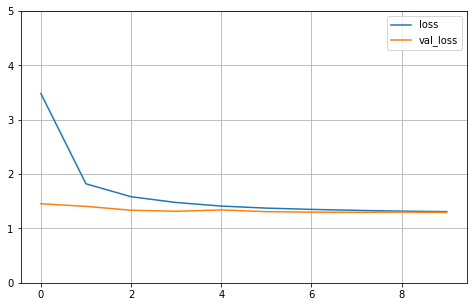

In [51]:
pd.DataFrame(history_3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5)
plt.show()

## Demo
To demonstrate the capabilities of this model we can generate recommendations for a random user (id = 228)

First, let's see what he liked the most

In [82]:
watched = joined_big[joined_big["user_id"] == 228]
watched.sort_values("rating", ascending=False).head(15)

,user_id,anime_id,rating,name,genre,type,episodes,rating_avg,members
18063,228,1,10,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
18163,228,30240,10,Prison School,"Comedy, Ecchi, Romance, School, Seinen",TV,12,8.03,227734
18113,228,11757,10,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
18116,228,13759,10,Sakurasou no Pet na Kanojo,"Comedy, Drama, Romance, School, Slice of Life",TV,24,8.40,380375
18084,228,4224,10,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817
18104,228,9989,10,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...,"Drama, Slice of Life, Supernatural",TV,11,8.62,463835
18078,228,2904,10,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,25,8.98,572888
18147,228,23273,10,Shigatsu wa Kimi no Uso,"Drama, Music, Romance, School, Shounen",TV,22,8.92,416397
18069,228,1535,10,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
18169,228,31043,10,Boku dake ga Inai Machi,"Mystery, Psychological, Seinen, Supernatural",TV,12,8.65,402381


Now we can generate a list of anime he didn't watch

In [87]:
did_not_watch = anime[(~anime.anime_id.isin(watched.anime_id)) & anime.anime_id.isin(joined_big.anime_id)].copy()
did_not_watch = did_not_watch.rename(columns={"rating": "rating_avg"})
did_not_watch.insert(loc=0, column="user_id", value=228)
did_not_watch

,user_id,anime_id,name,genre,type,episodes,rating_avg,members
0,228,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
2,228,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
4,228,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,228,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,228,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
...,...,...,...,...,...,...,...,...
12242,228,6025,Battle Can²,"Action, Hentai, Sci-Fi",OVA,1,4.69,484
12243,228,2990,Mini Skirt Gakuen,Hentai,OVA,1,4.64,657
12245,228,6903,Prima Donna Mai,Hentai,OVA,1,4.53,442
12246,228,5589,Offside Girl,"Hentai, Sports",OVA,2,4.30,945


Finally, we can use this data to predict 228's scores for each anime and pick top 10 best and worst

In [88]:
input_data = preprocessing.transform(did_not_watch)
prediction = model_final.predict(input_data)
did_not_watch.insert(loc=4, column="rating", value=prediction)
rating_228 = did_not_watch.sort_values("rating", ascending=False)
rating_228.head(10)

,user_id,anime_id,name,genre,rating,type,episodes,rating_avg,members
8,228,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",9.985899,Movie,1,9.10,72534
37,228,31757,Kizumonogatari II: Nekketsu-hen,"Action, Mystery, Supernatural, Vampire",9.957376,Movie,1,8.73,34347
14,228,28891,Haikyuu!! Second Season,"Comedy, Drama, School, Shounen, Sports",9.914590,TV,25,8.93,179342
65,228,7472,Gintama Movie: Shinyaku Benizakura-hen,"Action, Comedy, Historical, Parody, Samurai, S...",9.910198,Movie,1,8.59,51185
47,228,22135,Ping Pong The Animation,"Psychological, Seinen, Sports",9.902949,TV,11,8.67,97187
5,228,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",9.876781,TV,10,9.15,93351
48,228,21329,Mushishi Special: Hihamukage,"Adventure, Fantasy, Historical, Mystery, Seine...",9.628196,Special,1,8.66,49036
0,228,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",9.513012,Movie,1,9.37,200630
2,228,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",9.511528,TV,51,9.25,114262
263,228,18,Initial D Fourth Stage,"Action, Cars, Drama, Seinen, Sports",9.509234,TV,24,8.24,41584


In [89]:
rating_228.tail(10)

,user_id,anime_id,name,genre,rating,type,episodes,rating_avg,members
8277,228,16786,Bulsajo Robot Phoenix King,"Action, Mecha, Shounen, Space",4.762112,Movie,1,3.11,133
8043,228,2792,Panzer Dragoon,"Adventure, Fantasy",4.699286,OVA,1,3.47,1047
7448,228,1285,Soukihei MD Geist,"Mecha, Military, Sci-Fi",4.604631,OVA,1,5.42,7802
8055,228,29949,Nami,Dementia,4.549297,Movie,1,2.67,1817
8056,228,413,Hametsu no Mars,"Horror, Sci-Fi",4.151085,OVA,1,2.37,27557
8051,228,5877,Abunai Sisters: Koko &amp; Mika,"Action, Comedy, Ecchi",4.143262,OVA,10,2.95,1461
12248,228,5569,Tsui no Sora,Hentai,3.795539,OVA,1,2.98,934
10434,228,14529,Super Majingga 3,"Action, Mecha, Sci-Fi, Space",3.792733,Movie,1,3.72,123
12246,228,5589,Offside Girl,"Hentai, Sports",3.744515,OVA,2,4.30,945
8058,228,3287,Tenkuu Danzai Skelter+Heaven,"Mecha, Sci-Fi",2.492246,OVA,1,2.00,7680


## Results analysis
As this dataset is outdated, we have a lot of new info about user ratings from [MyAnimeList](https://myanimelist.net), for user 228 in particular

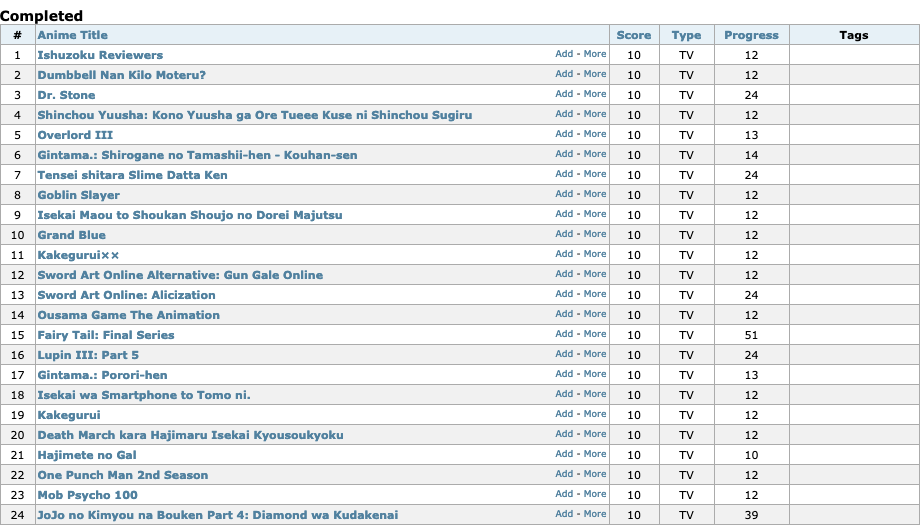

Let's check if he watched the top 10 predicted anime and how he liked it:

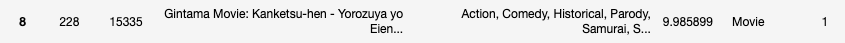


---




---




---

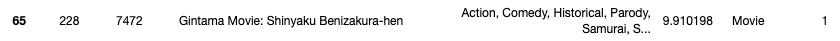


---




---

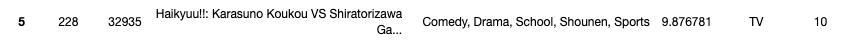


---

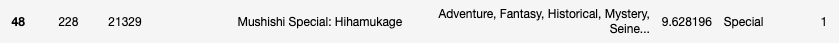


---




---

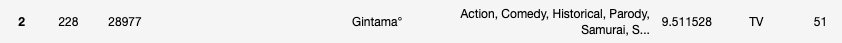


_He didn't watch Gintama° (4th season), but he watched 1st season of Gintama_

---




## Conclusion
The model shows promising results and can be trained on full dataset with the right tools.

Loss value of ~1.3 is a good result for mse of predicted rating, which lies between 1 and 10. The demo confirms that, as the predictions for a random user were accurate most of the times.

Also, the model can recommend not that popular anime, which potentially wouldn't have been discovered by the user.